In [1]:
!pip install --upgrade pip
!pip install lightgbm
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install hyperopt
!pip install \
    'dask>2023.3.2' \
    'distributed>2023.3.2'

  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


In [1]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
curr_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(curr_dir,'Data')
model_dir = os.path.join(curr_dir,'Models')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
df_oot = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_days.csv'))
model = lightgbm.Booster(model_file = os.path.join(model_dir,'lgbm_cbr_model_2025-02-26.txt'))

In [4]:
df_oot

accounts_group  count_units  \
0       2021-09_Myanmar (Burma)_SHS with TV_Pantanaw_S...            1   
1               2021-10_Kenya_Cash Loans_Narok_Cash Loans            1   
2       2021-12_Kenya_SHS with TV_Eldama Ravine_Sun Ki...           12   
3       2021-09_Uganda_Lanterns_Jinja_Sun King Boom Ea...            9   
4       2021-09_Nigeria_SHS Entry-Level_Ogoja_Sun King...           68   
...                                                   ...          ...   
138465  2021-11_Nigeria_SHS Entry-Level_Benin_Sun King...          135   
138466  2021-10_Zambia_SHS Entry-Level_Ndola_Sun King ...          105   
138467  2022-01_Kenya_SHS with TV_Hindi_Sun King Home ...            1   
138468  2021-12_Kenya_SHS Entry-Level Upgrade_Kuria_Su...           17   
138469  2021-12_Kenya_SHS Entry-Level Upgrade_Kwale_Su...            2   

        avg_planned_repayment_days  frr_3_years     actual_fr  \
0                              560     0.459620    149.996647   
1                              147     1.000000    214.661797   
2                              639     0.879487   6538.895988   
3                              259     1.000000    458.920698   
4                              259     1.000000   8334.838594   
...                            ...          ...           ...   
138465                         259     0.991115  16414.360870   
138466                         371     0.840353  18836.746546   
138467                         634     1.000000    555.543313   
138468                         371     0.898836   1723.241830   
138469                         371     0.553571    178.370133   

        total_follow_on_revenue_usd reg_month          country  \
0                        326.349260   2021-09  Myanmar (Burma)   
1                        214.661797   2021-10            Kenya   
2                       7434.897830   2021-12            Kenya   
3                        458.835813   2021-09           Uganda   
4                       8329.008288   2021-09          Nigeria   
...                             ...       ...              ...   
138465                 16561.509885   2021-11          Nigeria   
138466                 22415.278515   2021-10           Zambia   
138467                   555.543313   2022-01            Kenya   
138468                  1917.192714   2021-12            Kenya   
138469                   322.217264   2021-12            Kenya   

                  product_group           area  ... backtesting       frr  \
0                   SHS with TV       Pantanaw  ...          30  0.054945   
1                    Cash Loans          Narok  ...         450  1.000000   
2                   SHS with TV  Eldama Ravine  ...          90  0.101806   
3                      Lanterns          Jinja  ...          60  0.166667   
4               SHS Entry-Level          Ogoja  ...         720  0.997461   
...                         ...            ...  ...         ...       ...   
138465          SHS Entry-Level          Benin  ...          90  0.351381   
138466          SHS Entry-Level          Ndola  ...          60  0.130511   
138467              SHS with TV          Hindi  ...         180  0.209524   
138468  SHS Entry-Level Upgrade          Kuria  ...          30  0.062102   
138469  SHS Entry-Level Upgrade          Kwale  ...          60  0.047253   

        repayment_speed  avg_cum_days_disabled  at_risk_rate  \
0                1.8750                    0.0      0.000000   
1                1.0000                   13.0      0.000000   
2                0.7445                   22.0      0.000000   
3                0.7927                    8.0      0.111111   
4                0.9974                   62.0      0.000000   
...                 ...                    ...           ...   
138465           1.0668                    6.0      0.000000   
138466           0.8963                    5.0      0.038095   
138467           0.7500                   45.0      0.000000   
138468         

In [5]:
df_oot['backtesting'].value_counts()

backtesting
30     13847
450    13847
90     13847
60     13847
720    13847
180    13847
630    13847
540    13847
360    13847
270    13847
Name: count, dtype: int64

In [6]:
X_oot = df_oot.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_oot = df_oot[:]['frr_3_years']

print('shape of the input data: ',X_oot.shape)
print('shape of the output data: ',y_oot.shape)

shape of the input data:  (138470, 11)
shape of the output data:  (138470,)


In [7]:
y_pred_oot = model.predict(X_oot)

X_oot_copy = df_oot.copy()
X_oot_copy['actual_frr'] = y_oot
X_oot_copy['predicted_frr'] = y_pred_oot

In [8]:
X_oot_copy

accounts_group  count_units  \
0       2021-09_Myanmar (Burma)_SHS with TV_Pantanaw_S...            1   
1               2021-10_Kenya_Cash Loans_Narok_Cash Loans            1   
2       2021-12_Kenya_SHS with TV_Eldama Ravine_Sun Ki...           12   
3       2021-09_Uganda_Lanterns_Jinja_Sun King Boom Ea...            9   
4       2021-09_Nigeria_SHS Entry-Level_Ogoja_Sun King...           68   
...                                                   ...          ...   
138465  2021-11_Nigeria_SHS Entry-Level_Benin_Sun King...          135   
138466  2021-10_Zambia_SHS Entry-Level_Ndola_Sun King ...          105   
138467  2022-01_Kenya_SHS with TV_Hindi_Sun King Home ...            1   
138468  2021-12_Kenya_SHS Entry-Level Upgrade_Kuria_Su...           17   
138469  2021-12_Kenya_SHS Entry-Level Upgrade_Kwale_Su...            2   

        avg_planned_repayment_days  frr_3_years     actual_fr  \
0                              560     0.459620    149.996647   
1                              147     1.000000    214.661797   
2                              639     0.879487   6538.895988   
3                              259     1.000000    458.920698   
4                              259     1.000000   8334.838594   
...                            ...          ...           ...   
138465                         259     0.991115  16414.360870   
138466                         371     0.840353  18836.746546   
138467                         634     1.000000    555.543313   
138468                         371     0.898836   1723.241830   
138469                         371     0.553571    178.370133   

        total_follow_on_revenue_usd reg_month          country  \
0                        326.349260   2021-09  Myanmar (Burma)   
1                        214.661797   2021-10            Kenya   
2                       7434.897830   2021-12            Kenya   
3                        458.835813   2021-09           Uganda   
4                       8329.008288   2021-09          Nigeria   
...                             ...       ...              ...   
138465                 16561.509885   2021-11          Nigeria   
138466                 22415.278515   2021-10           Zambia   
138467                   555.543313   2022-01            Kenya   
138468                  1917.192714   2021-12            Kenya   
138469                   322.217264   2021-12            Kenya   

                  product_group           area  ... repayment_speed  \
0                   SHS with TV       Pantanaw  ...          1.8750   
1                    Cash Loans          Narok  ...          1.0000   
2                   SHS with TV  Eldama Ravine  ...          0.7445   
3                      Lanterns          Jinja  ...          0.7927   
4               SHS Entry-Level          Ogoja  ...          0.9974   
...                         ...            ...  ...             ...   
138465          SHS Entry-Level          Benin  ...          1.0668   
138466          SHS Entry-Level          Ndola  ...          0.8963   
138467              SHS with TV          Hindi  ...          0.7500   
138468  SHS Entry-Level Upgrade          Kuria  ...          0.9828   
138469  SHS Entry-Level Upgrade          Kwale  ...          0.3245   

        avg_cum_days_disabled  at_risk_rate  disabled_gt_two_week_rate  \
0                         0.0      0.000000                   0.000000   
1                        13.0      0.000000                   0.000000   
2                        22.0      0.000000                   0.000000   
3                         8.0      0.111111                   0.000000   
4                        62.0      0.000000                   0.014706   
...                       ...           ...                        ...   
138465                    6.0      0.000000                   0.014815   
138466                    5.0      0.038095                   0.066667   
138467                   45.0      0.000000                  

In [9]:
def fix_predictions(df_to_predict):
    
    # df_to_predict['predicted_frr'] = y_pred_test['0.5']
    
    df_to_predict.loc[df_to_predict['predicted_frr']<0,'predicted_frr'] =0
    df_to_predict.loc[df_to_predict['predicted_frr']>1,'predicted_frr'] =1
    
    df_to_predict.loc[df_to_predict['frr_3_years']<0,'frr_3_years'] =0
    df_to_predict.loc[df_to_predict['frr_3_years']>1,'frr_3_years'] =1
    
    df_to_predict['predicted_revenue_USD'] = np.round(df_to_predict['predicted_frr']*df_to_predict['total_follow_on_revenue_usd'],2)

    return df_to_predict

def compare_preds_vs_actuals(df_oot):
    
    total_fr = df_oot['actual_fr'].sum()
    total_follow_on_price = df_oot['total_follow_on_revenue_usd'].sum()
    agg_actual_frr = np.round(total_fr/total_follow_on_price,4)
    
    total_predicted_fr = df_oot['predicted_revenue_USD'].sum()
    cbr_agg_predicted_frr = np.round(total_predicted_fr/total_follow_on_price,4)
    
    return agg_actual_frr, cbr_agg_predicted_frr

def comparision_by_months(list_backtesting, reg_months, df_oot_validation):
    
    months = []
    backtesting = []
    actual =[]
    CBR_pred =[]

    for btl in list_backtesting:
        
        for month in reg_months:
    
            df_oot_copy = df_oot_validation.loc[(df_oot_validation['reg_month']==month) & (df_oot_validation['backtesting']==btl)].copy()
            df_oot_copy.reset_index(drop=True, inplace=True)
            agg_actual_frr, cbr_agg_predicted_frr = compare_preds_vs_actuals(df_oot_copy)
    
            months.append(month)
            backtesting.append(btl)
            actual.append(agg_actual_frr)
            CBR_pred.append(cbr_agg_predicted_frr)
        
    dict_comparison = {
    'Month' : months,
    'Backtesting' : backtesting,
    'actual' : actual,
    'CBR_pred' : CBR_pred,
    }

    df_comparison = pd.DataFrame(dict_comparison, columns = ['Month','Backtesting','actual','CBR_pred'])
    
    return df_comparison


def comparison_by_months_countries(list_backtesting, reg_months, list_countries, df_oot_validation):
    
    months = []
    backtesting = []
    actual =[]
    countries = []
    CBR_pred =[]

    for btl in list_backtesting:
        
        for month in reg_months:
    
            for country in list_countries:
                
                df_oot_copy = df_oot_validation.loc[(df_oot_validation['backtesting']==btl) & 
                (df_oot_validation['reg_month']==month) & (df_oot_validation['country']==country)]
                if(df_oot_copy.shape[0]>0): 
    
                    agg_actual_frr, cbr_agg_predicted_frr = compare_preds_vs_actuals(df_oot_copy)
                    #print('--------------------------------------------------')
                    months.append(month)
                    backtesting.append(btl)
                    countries.append(country)
                    actual.append(agg_actual_frr)
                    CBR_pred.append(cbr_agg_predicted_frr)
                                                                          
    
    dict_comparison_country_wise = {
        'Month' : months,
        'Backtesting' : backtesting,
        'Country': countries,
        'actual' : actual,
        'CBR_pred' : CBR_pred,
    }
    df_comparison_country_wise = pd.DataFrame(dict_comparison_country_wise, columns = ['Month','Backtesting','Country','actual','CBR_pred'])
    
    return df_comparison_country_wise


def comparison_by_months_countries_products(list_backtesting, reg_months, list_countries, list_products, df_oot_validation):
    
    months = []
    backtesting = []
    countries =[]
    products = []
    actual =[]
    CBR_pred =[]

    for btl in list_backtesting:
        
        for month in reg_months:
    
            for country in list_countries:
                
                for product in list_products:
                    
                    df_oot_copy = df_oot_validation.loc[(df_oot_validation['backtesting']==btl) & 
                    (df_oot_validation['reg_month']==month) & (df_oot_validation['country']==country) & (df_oot_validation['product_group']==product)]
                    if(df_oot_copy.shape[0]>0): 
    
                        agg_actual_frr, cbr_agg_predicted_frr = compare_preds_vs_actuals(df_oot_copy)
                        #print('--------------------------------------------------')
                        months.append(month)
                        backtesting.append(btl)
                        countries.append(country)
                        products.append(product)
                        actual.append(agg_actual_frr)
                        CBR_pred.append(cbr_agg_predicted_frr)
    
    dict_comparison_product_wise = {
        'Month' : months,
        'Backtesting' : backtesting,
        'Country': countries,
        'Product' : products,
        'actual' : actual,
        'CBR_pred' : CBR_pred,
    }
    df_comparison_product_wise = pd.DataFrame(dict_comparison_product_wise, columns = ['Month','Backtesting','Country','actual','Product','CBR_pred'])
    
    return df_comparison_product_wise

In [10]:
df_to_predict = fix_predictions(X_oot_copy)

In [11]:
df_to_predict.to_csv(os.path.join(data_dir, 'data_preds.csv'), index=False)
df_to_predict

accounts_group  count_units  \
0       2021-09_Myanmar (Burma)_SHS with TV_Pantanaw_S...            1   
1               2021-10_Kenya_Cash Loans_Narok_Cash Loans            1   
2       2021-12_Kenya_SHS with TV_Eldama Ravine_Sun Ki...           12   
3       2021-09_Uganda_Lanterns_Jinja_Sun King Boom Ea...            9   
4       2021-09_Nigeria_SHS Entry-Level_Ogoja_Sun King...           68   
...                                                   ...          ...   
138465  2021-11_Nigeria_SHS Entry-Level_Benin_Sun King...          135   
138466  2021-10_Zambia_SHS Entry-Level_Ndola_Sun King ...          105   
138467  2022-01_Kenya_SHS with TV_Hindi_Sun King Home ...            1   
138468  2021-12_Kenya_SHS Entry-Level Upgrade_Kuria_Su...           17   
138469  2021-12_Kenya_SHS Entry-Level Upgrade_Kwale_Su...            2   

        avg_planned_repayment_days  frr_3_years     actual_fr  \
0                              560     0.459620    149.996647   
1                              147     1.000000    214.661797   
2                              639     0.879487   6538.895988   
3                              259     1.000000    458.920698   
4                              259     1.000000   8334.838594   
...                            ...          ...           ...   
138465                         259     0.991115  16414.360870   
138466                         371     0.840353  18836.746546   
138467                         634     1.000000    555.543313   
138468                         371     0.898836   1723.241830   
138469                         371     0.553571    178.370133   

        total_follow_on_revenue_usd reg_month          country  \
0                        326.349260   2021-09  Myanmar (Burma)   
1                        214.661797   2021-10            Kenya   
2                       7434.897830   2021-12            Kenya   
3                        458.835813   2021-09           Uganda   
4                       8329.008288   2021-09          Nigeria   
...                             ...       ...              ...   
138465                 16561.509885   2021-11          Nigeria   
138466                 22415.278515   2021-10           Zambia   
138467                   555.543313   2022-01            Kenya   
138468                  1917.192714   2021-12            Kenya   
138469                   322.217264   2021-12            Kenya   

                  product_group           area  ... avg_cum_days_disabled  \
0                   SHS with TV       Pantanaw  ...                   0.0   
1                    Cash Loans          Narok  ...                  13.0   
2                   SHS with TV  Eldama Ravine  ...                  22.0   
3                      Lanterns          Jinja  ...                   8.0   
4               SHS Entry-Level          Ogoja  ...                  62.0   
...                         ...            ...  ...                   ...   
138465          SHS Entry-Level          Benin  ...                   6.0   
138466          SHS Entry-Level          Ndola  ...                   5.0   
138467              SHS with TV          Hindi  ...                  45.0   
138468  SHS Entry-Level Upgrade          Kuria  ...                   2.0   
138469  SHS Entry-Level Upgrade          Kwale  ...                  26.0   

        at_risk_rate  disabled_gt_two_week_rate  unlocked_rate  disabled_rate  \
0           0.000000                   0.000000       0.000000       0.000000   
1           0.000000                   0.000000       1.000000       0.000000   
2           0.000000                   0.000000       0.000000       0.583333   
3           0.111111                   0.000000       0.000000       0.222222   
4           0.000000                   0.014706       0.985294       0.014706   
...              ...                        ...            ...            ...   
138465      0.000000                   0.014815       0.029630       0.155556   
138466 

In [12]:
df_to_predict.columns

Index(['accounts_group', 'count_units', 'avg_planned_repayment_days',
       'frr_3_years', 'actual_fr', 'total_follow_on_revenue_usd', 'reg_month',
       'country', 'product_group', 'area', 'primary_product', 'backtesting',
       'frr', 'repayment_speed', 'avg_cum_days_disabled', 'at_risk_rate',
       'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate',
       'avg_upfront_price_usd', 'avg_unlock_price_usd', 'actual_frr',
       'predicted_frr', 'predicted_revenue_USD'],
      dtype='object')

In [13]:
list_countries = ['Kenya','Nigeria','Tanzania','Uganda','Zambia']
product_list = ['Lanterns', 'SHS with TV', 'SHS without TV', 'SHS Entry-Level']
# primary_product_list = ['Sun King Home 60 EasyBuy','Sun King Home 400 Easybuy GSM','Sun King Home 120 EasyBuy','Sun King Boom EasyBuy']
list_backtesting = [30, 60, 90, 180, 270, 360, 450, 540, 630, 720]
reg_months = list(df_to_predict['reg_month'].unique())
reg_months.sort()

In [14]:
reg_months

['2021-08', '2021-09', '2021-10', '2021-11', '2021-12', '2022-01']

In [15]:
df_comparison = comparision_by_months(list_backtesting, reg_months, df_to_predict)
df_comparison_country_wise = comparison_by_months_countries(list_backtesting, reg_months, list_countries, df_to_predict)
df_comparison_product_wise = comparison_by_months_countries_products(list_backtesting, reg_months, list_countries, product_list, df_to_predict)

In [16]:
df_comparison.to_csv(os.path.join(data_dir, 'df_comparison.csv'), index=False)
df_comparison_country_wise.to_csv(os.path.join(data_dir, 'df_comparison_country_wise.csv'), index=False)
df_comparison_product_wise.to_csv(os.path.join(data_dir, 'df_comparison_product_wise.csv'), index=False)

In [19]:
df_comparison_country_wise

Month  Backtesting   Country  actual  CBR_pred
0    2021-08           30     Kenya  0.8511    0.8490
1    2021-08           30   Nigeria  0.9814    0.9506
2    2021-08           30  Tanzania  0.7710    0.7785
3    2021-08           30    Uganda  0.6963    0.7912
4    2021-08           30    Zambia  0.7578    0.8740
..       ...          ...       ...     ...       ...
295  2022-01          720     Kenya  0.8708    0.8760
296  2022-01          720   Nigeria  0.9868    0.9833
297  2022-01          720  Tanzania  0.8238    0.8319
298  2022-01          720    Uganda  0.6989    0.7086
299  2022-01          720    Zambia  0.8688    0.8736

[300 rows x 5 columns]

In [20]:
df_to_predict['backtesting'].value_counts()

backtesting
30     13847
450    13847
90     13847
60     13847
720    13847
180    13847
630    13847
540    13847
360    13847
270    13847
Name: count, dtype: int64

In [21]:
def plot_preds_actuals(df_comparison, x_axis, y_axis, x_label, y_label, title):
    
    
    if(df_comparison.shape[0]>0):
        
        plt.rcParams['figure.figsize'] = [20, 10]
        df_comparison.plot(x=x_axis, y=y_axis, 
                                            kind="line", style='o-')
            
        for i in range(len(df_comparison[x_axis])):
            
            plt.text(i, df_comparison[y_axis[0]][i], df_comparison[y_axis[0]][i], ha='center', va='bottom')
            plt.text(i, df_comparison[y_axis[1]][i], df_comparison[y_axis[1]][i], ha='center', va='bottom')
            

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)          
        plt.show()

Kenya
30
Avg error actual and pred: 0.0071


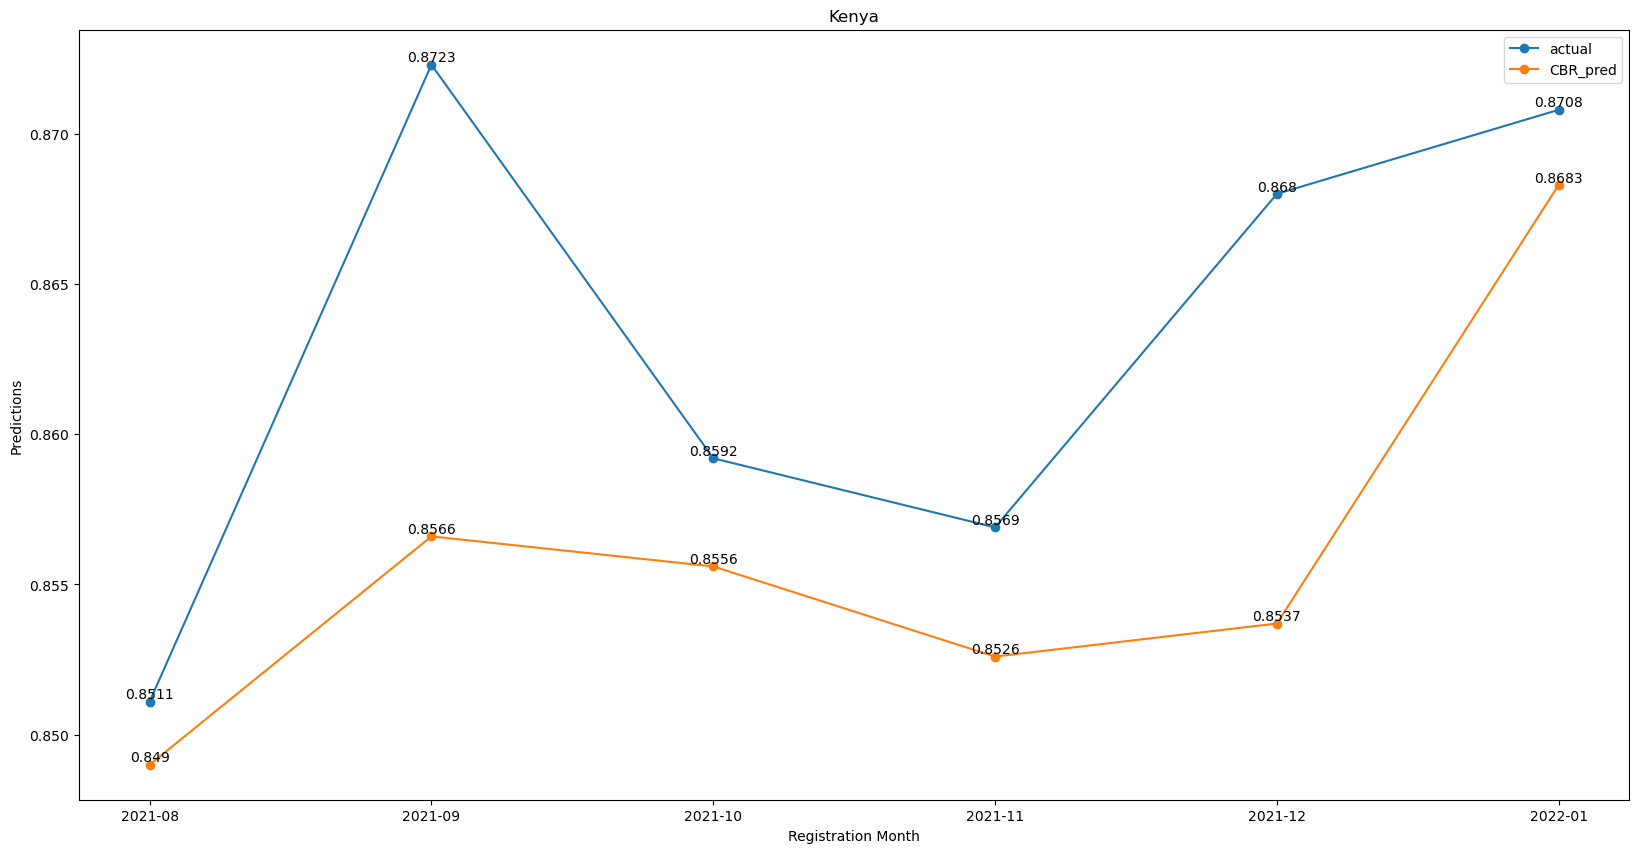

60
Avg error actual and pred: 0.0056


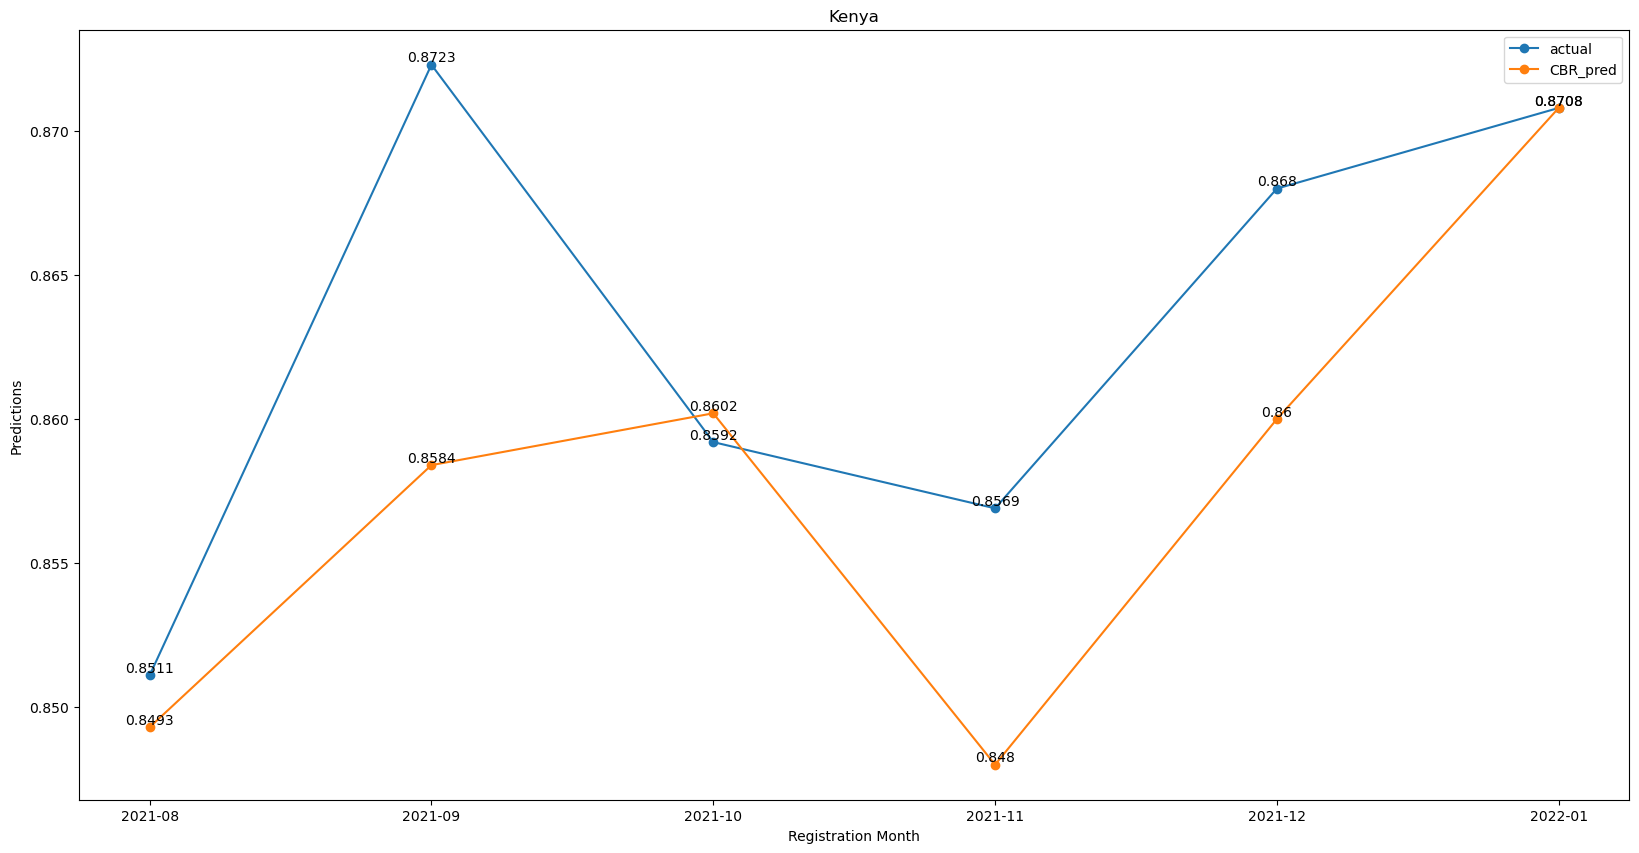

90
Avg error actual and pred: 0.0039


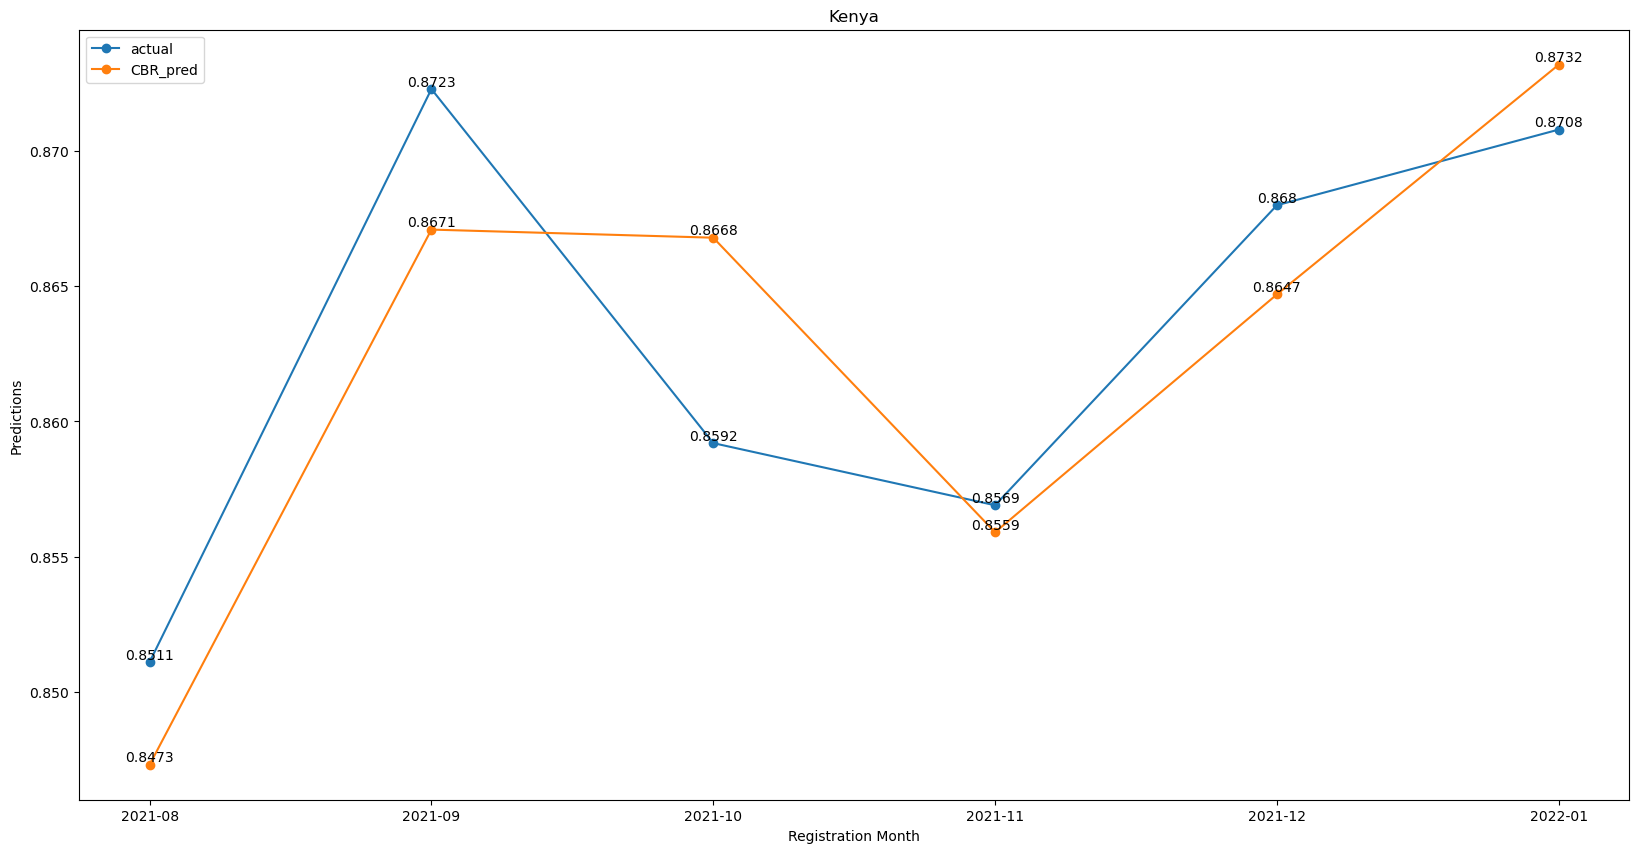

180
Avg error actual and pred: 0.0053


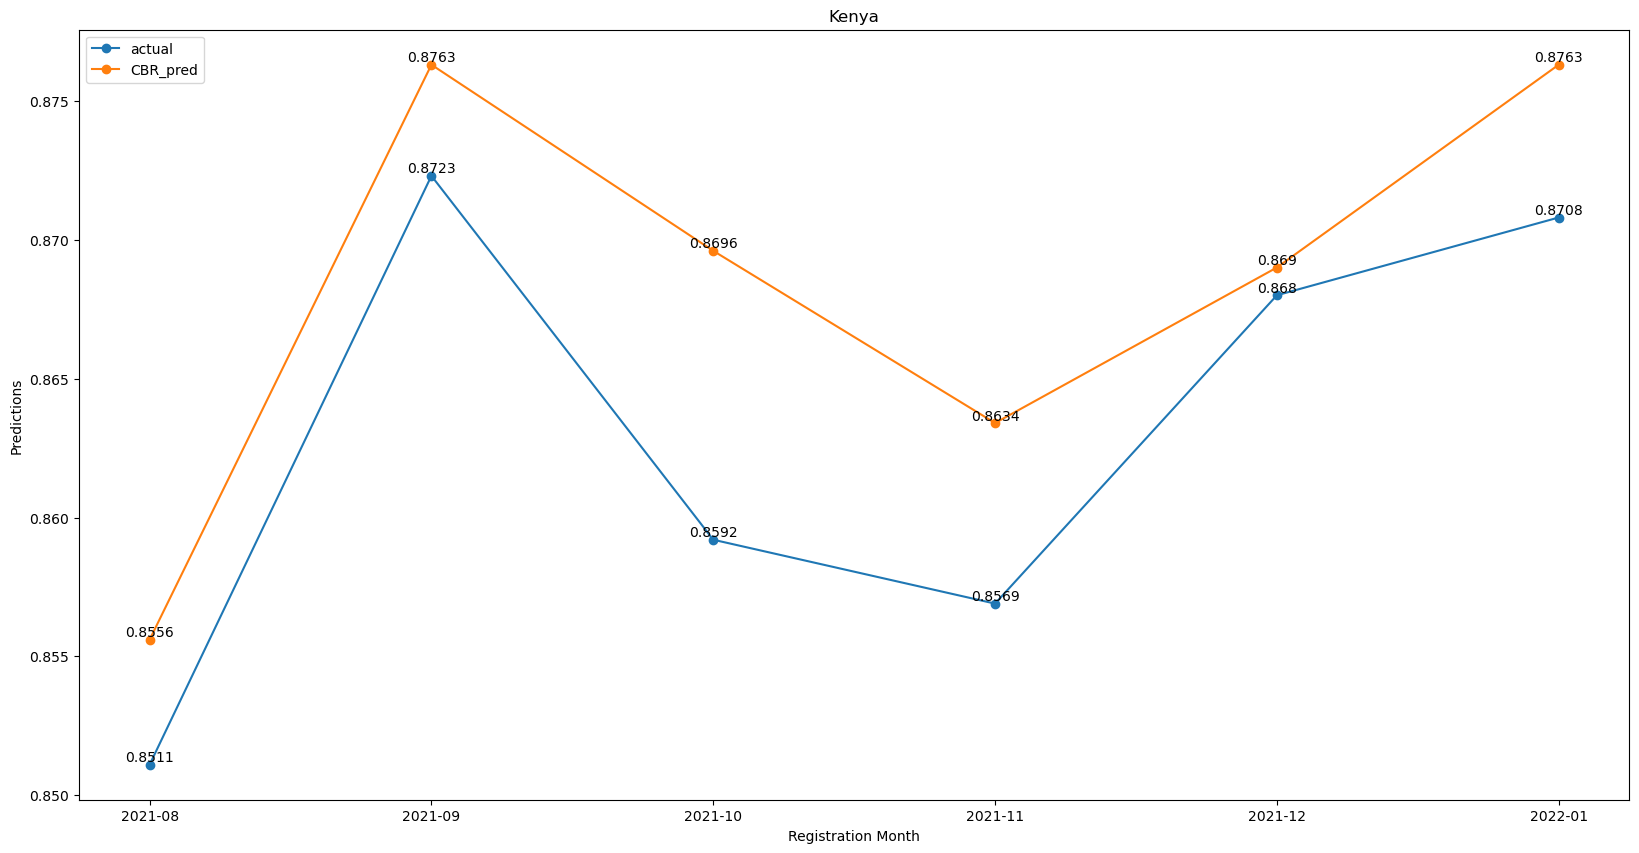

270
Avg error actual and pred: 0.0087


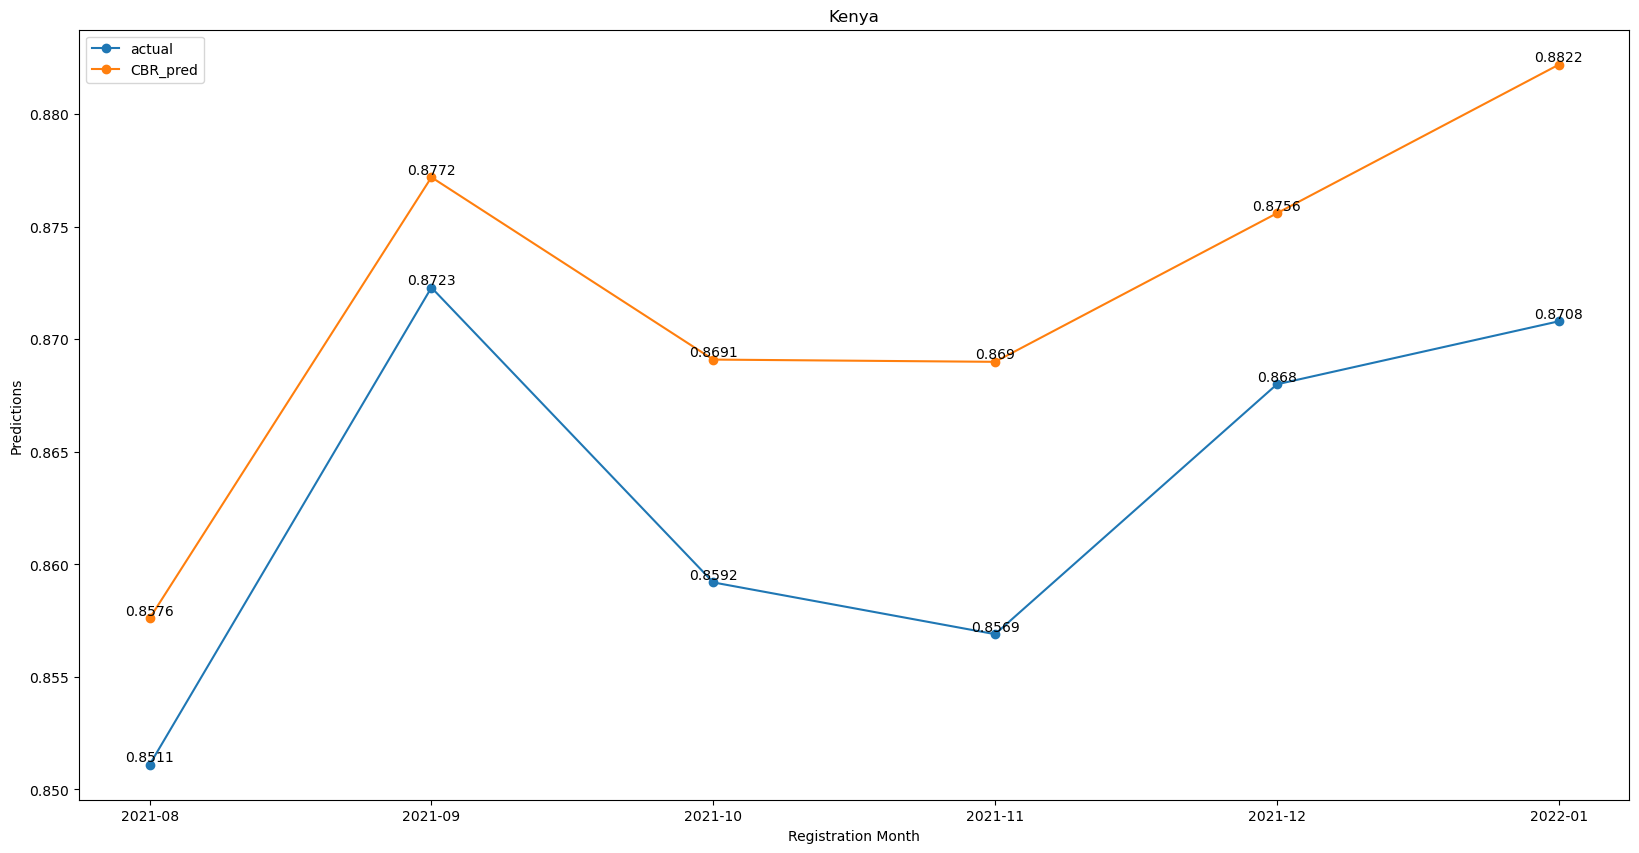

360
Avg error actual and pred: 0.0063


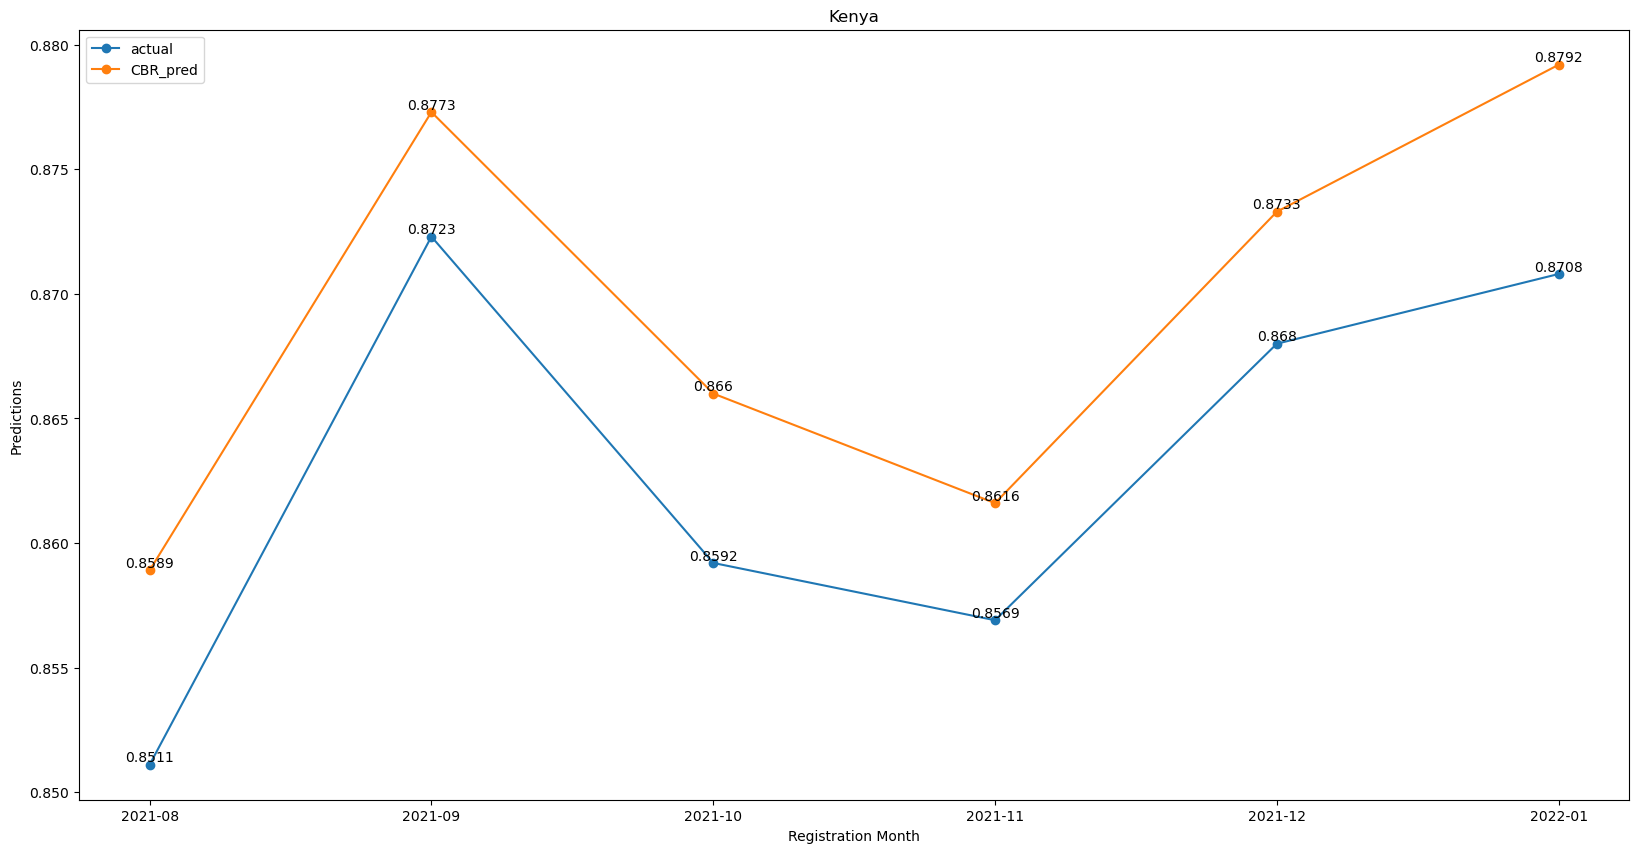

450
Avg error actual and pred: 0.0068


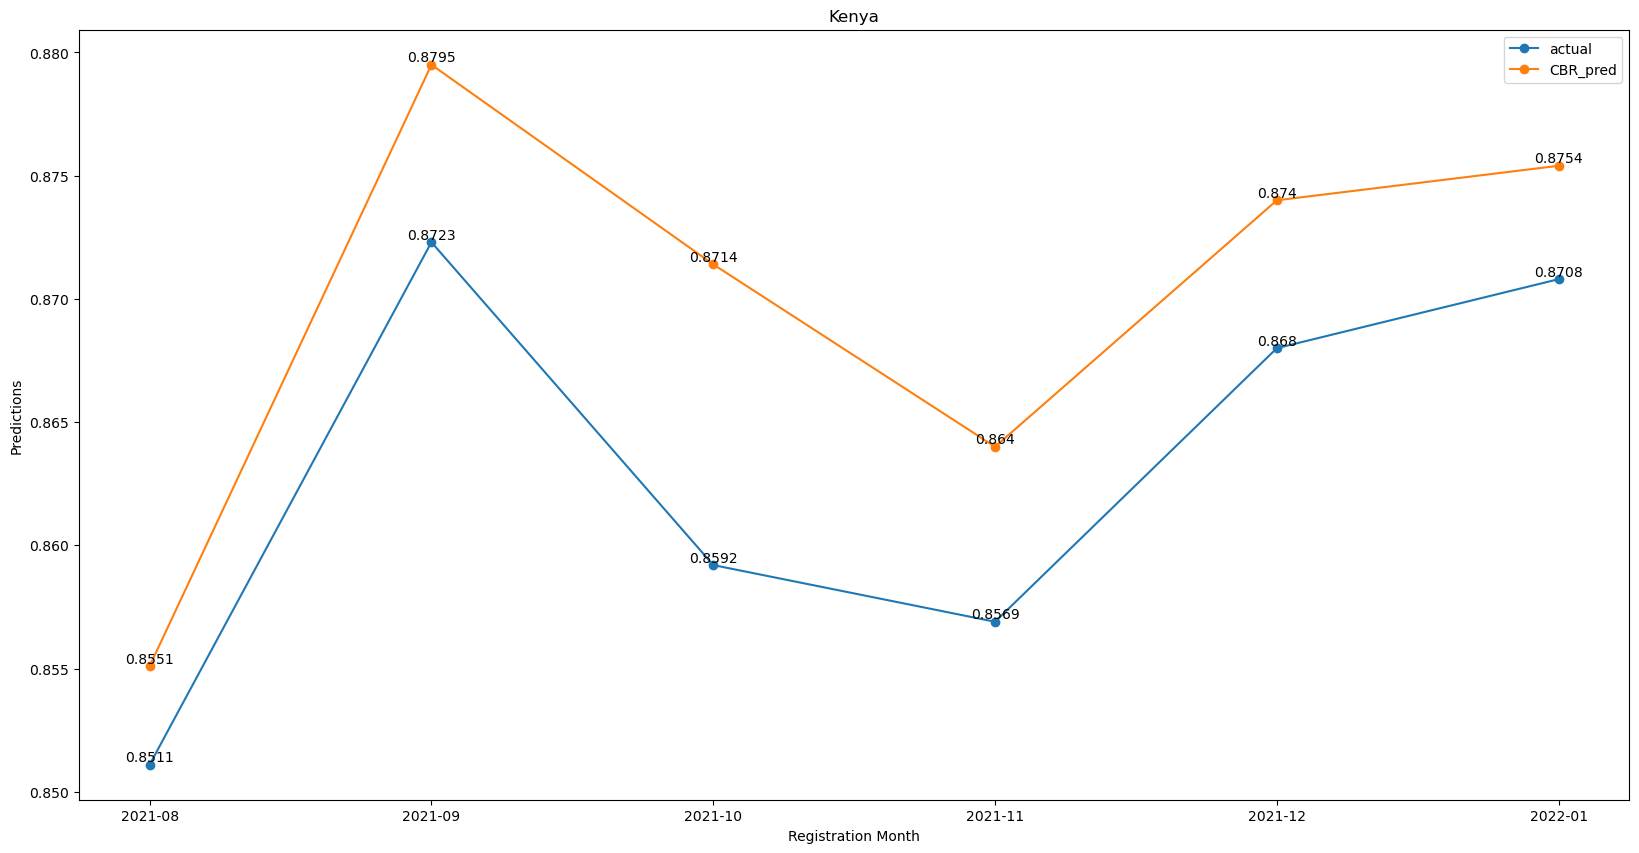

540
Avg error actual and pred: 0.0022


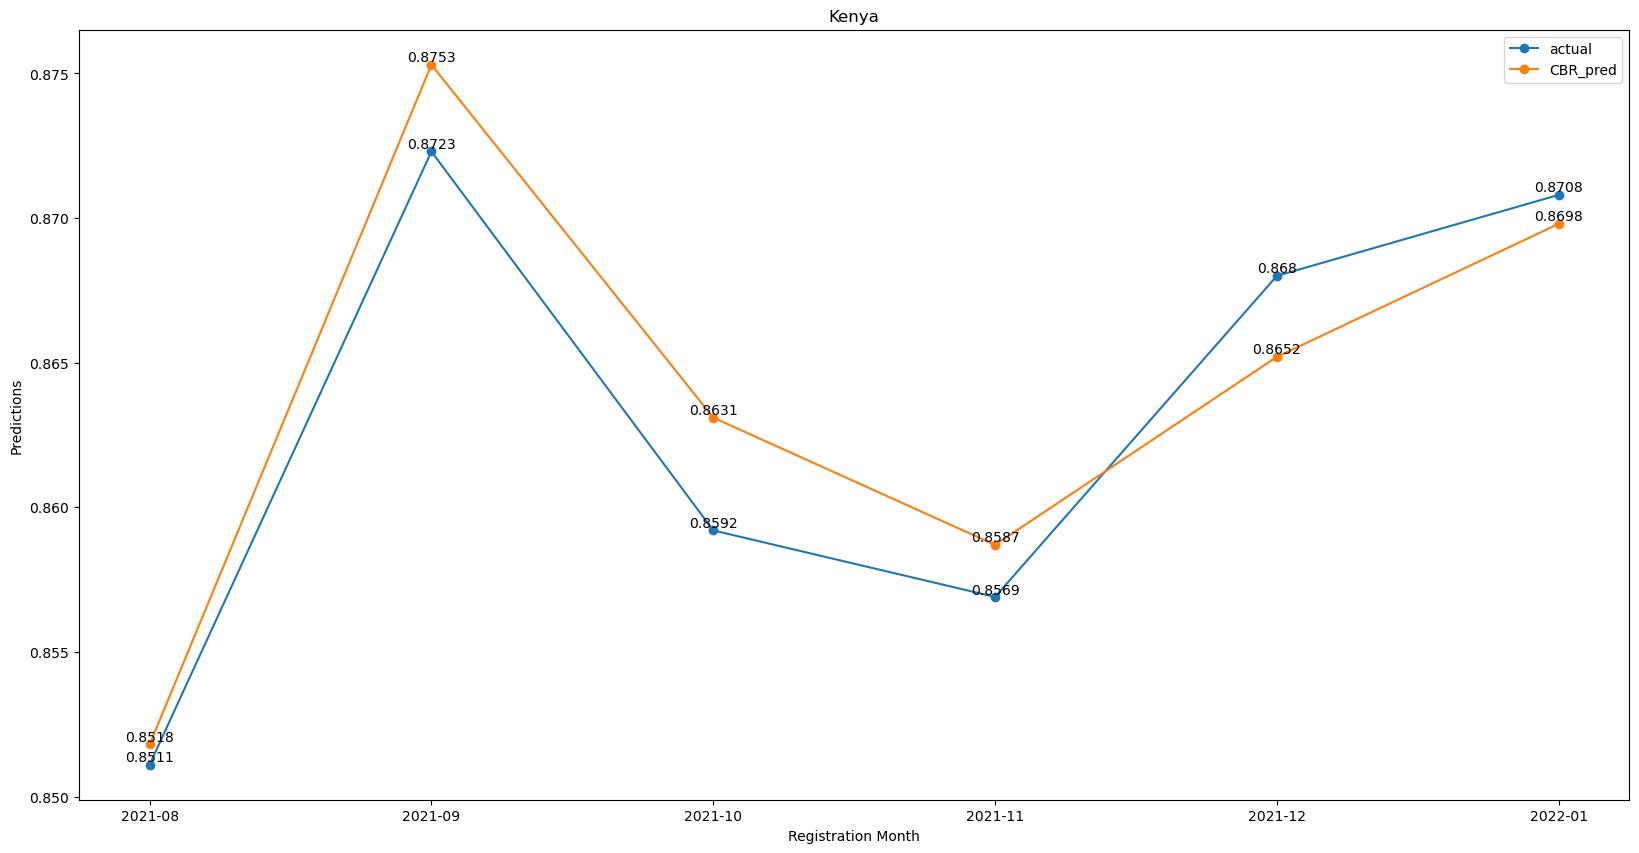

630
Avg error actual and pred: 0.0034


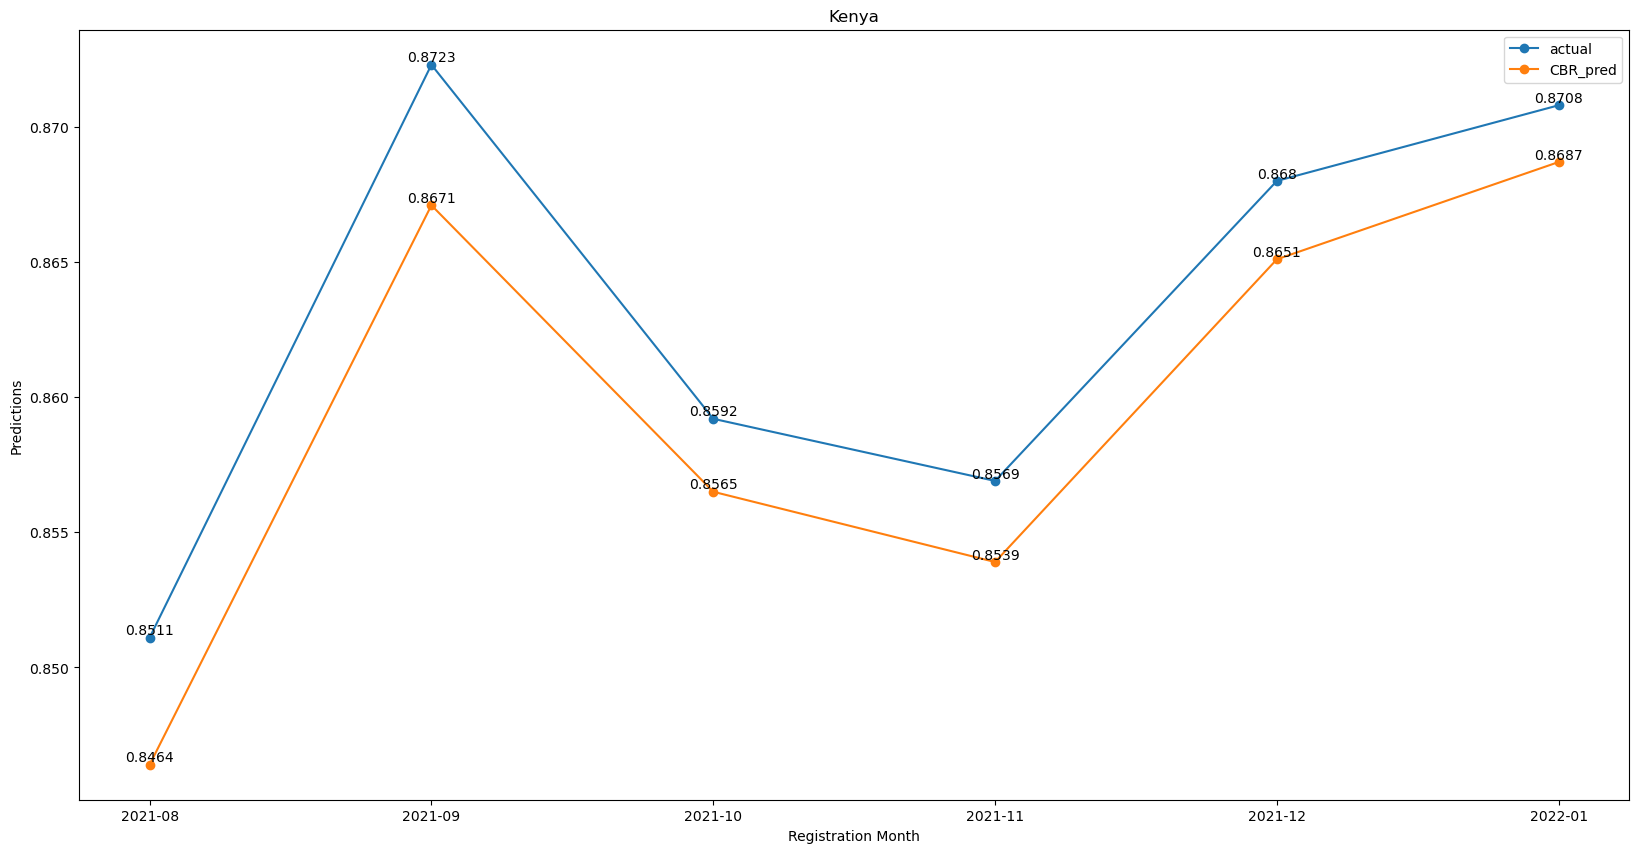

720
Avg error actual and pred: 0.0041


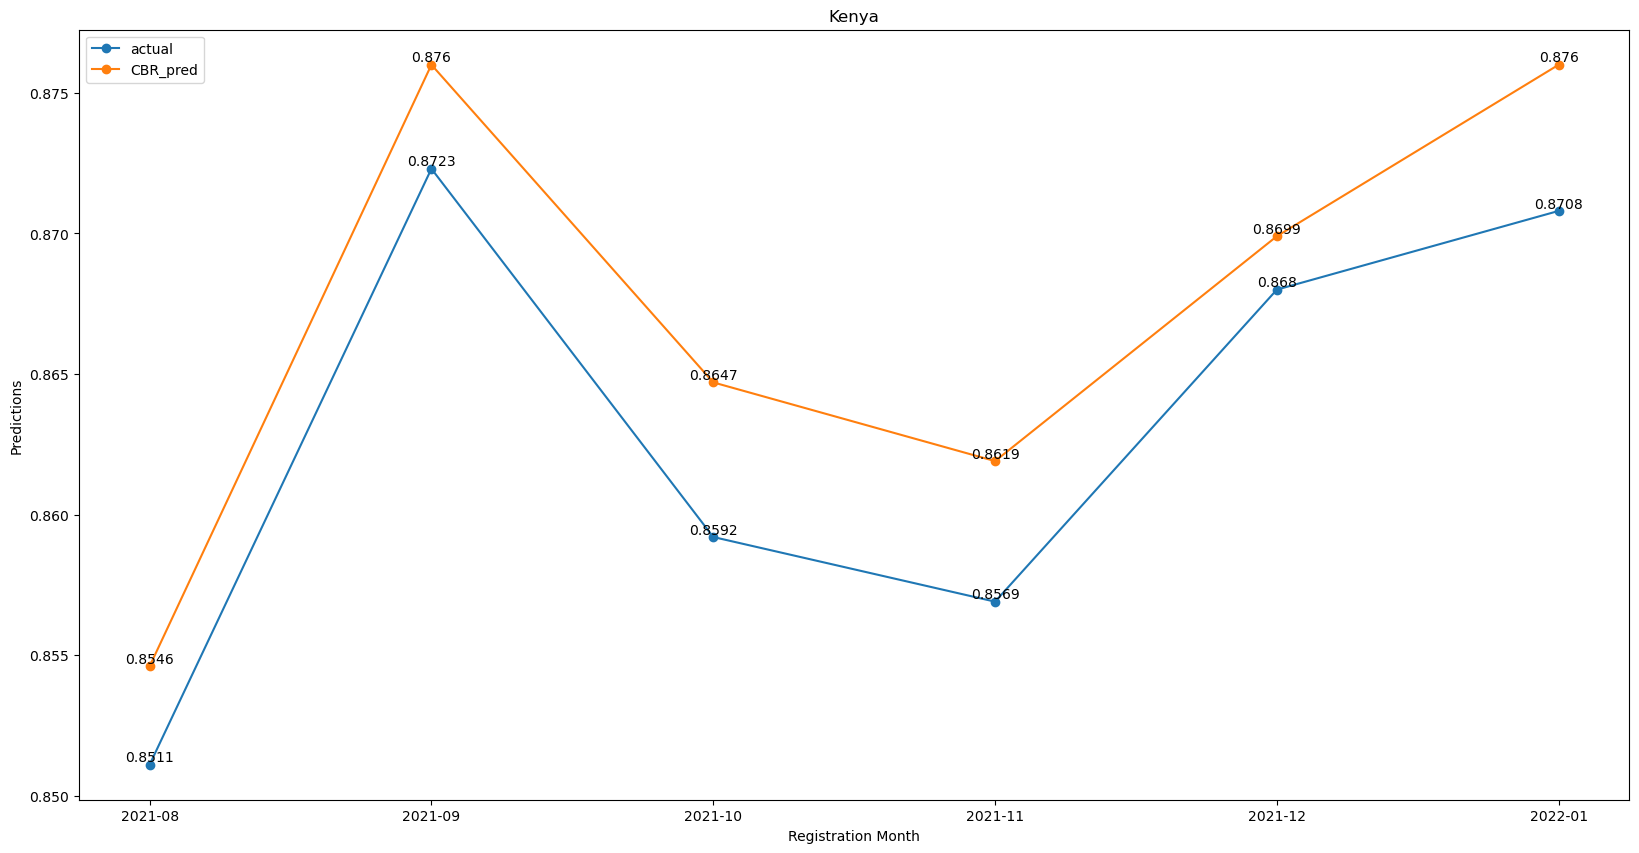

----------------------------------------------------------------------
Nigeria
30
Avg error actual and pred: 0.0331


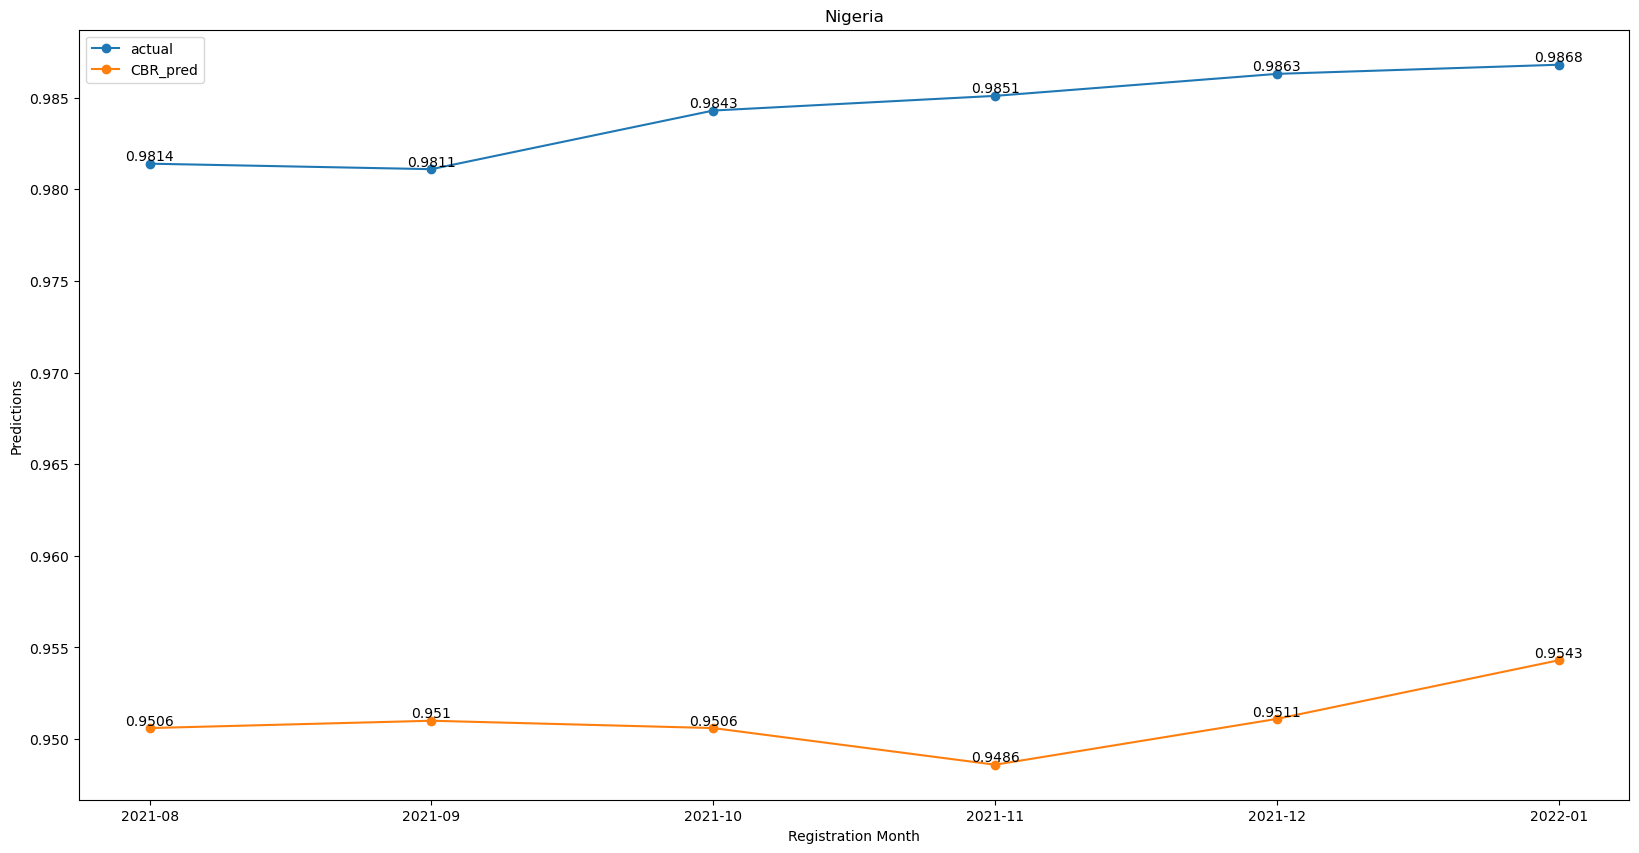

60
Avg error actual and pred: 0.0222


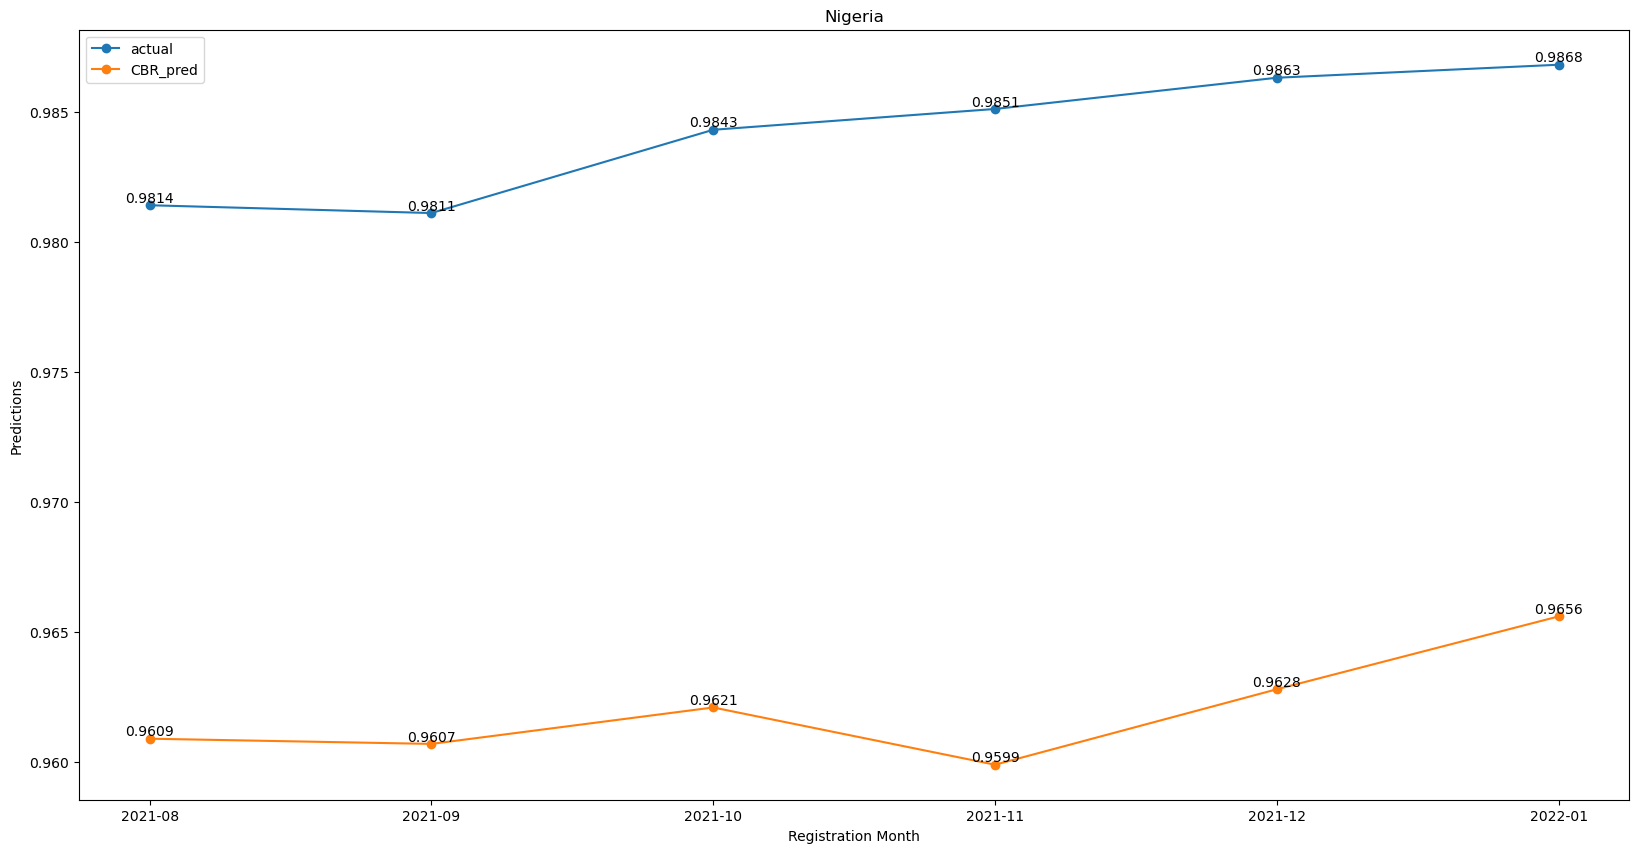

90
Avg error actual and pred: 0.0162


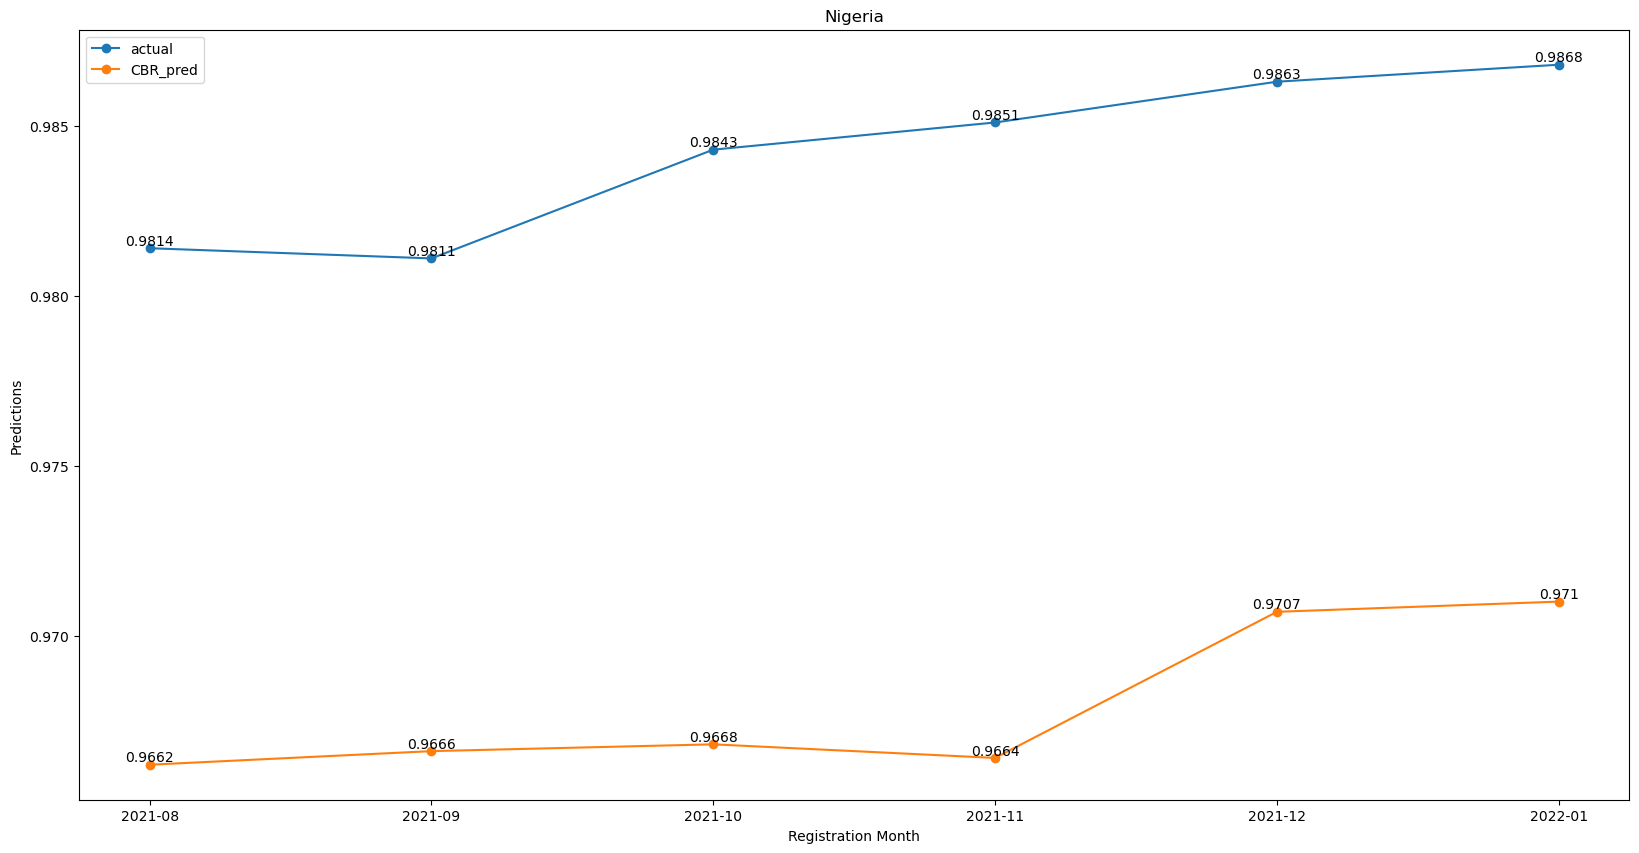

180
Avg error actual and pred: 0.0082


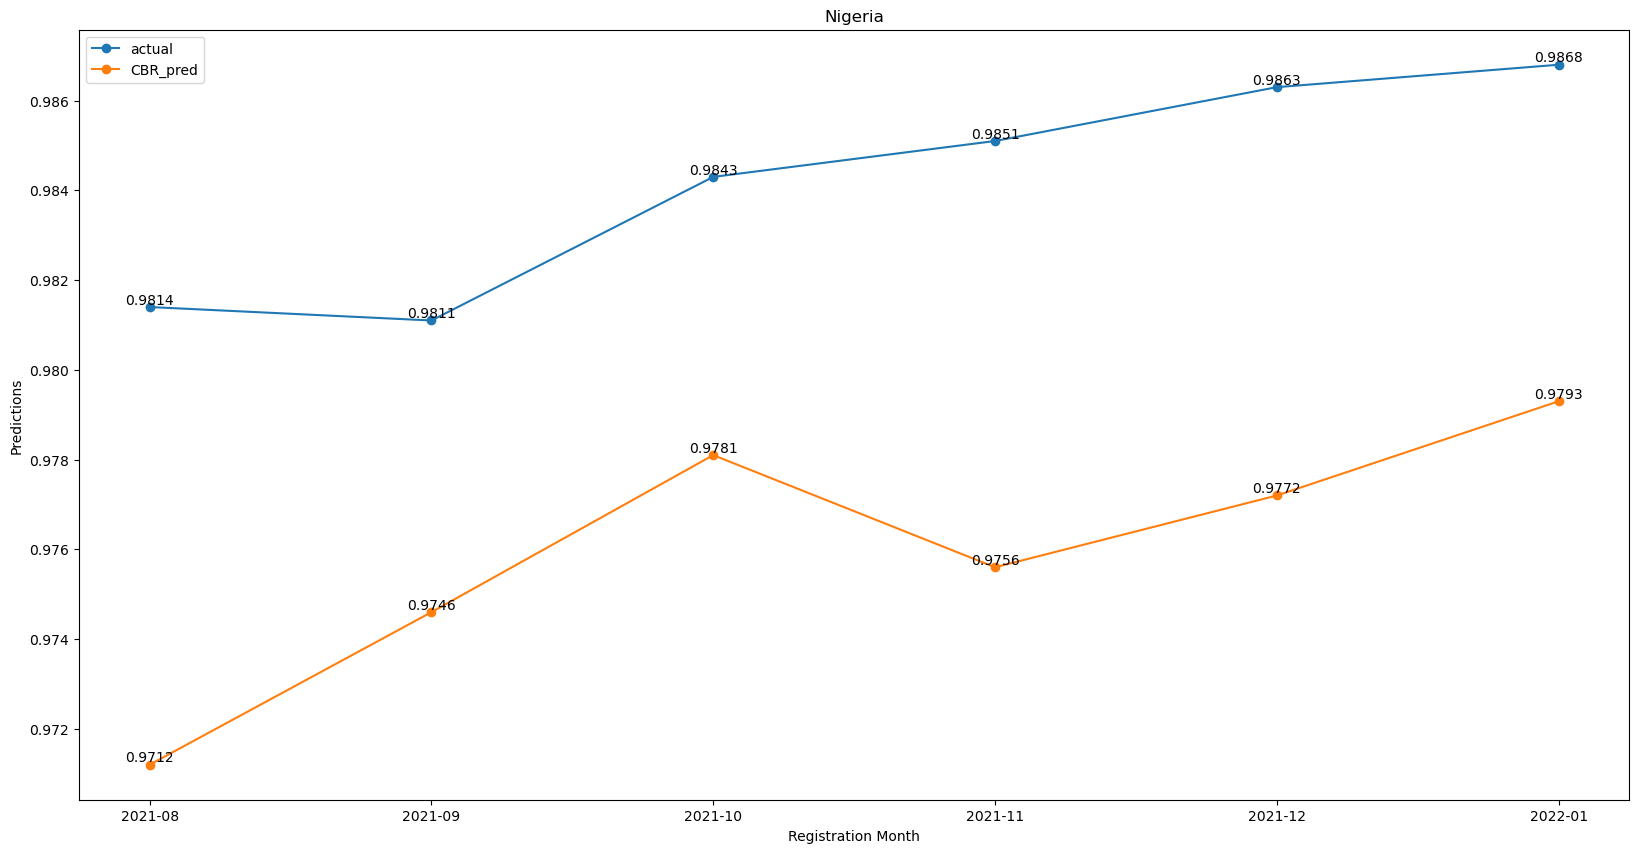

270
Avg error actual and pred: 0.0087


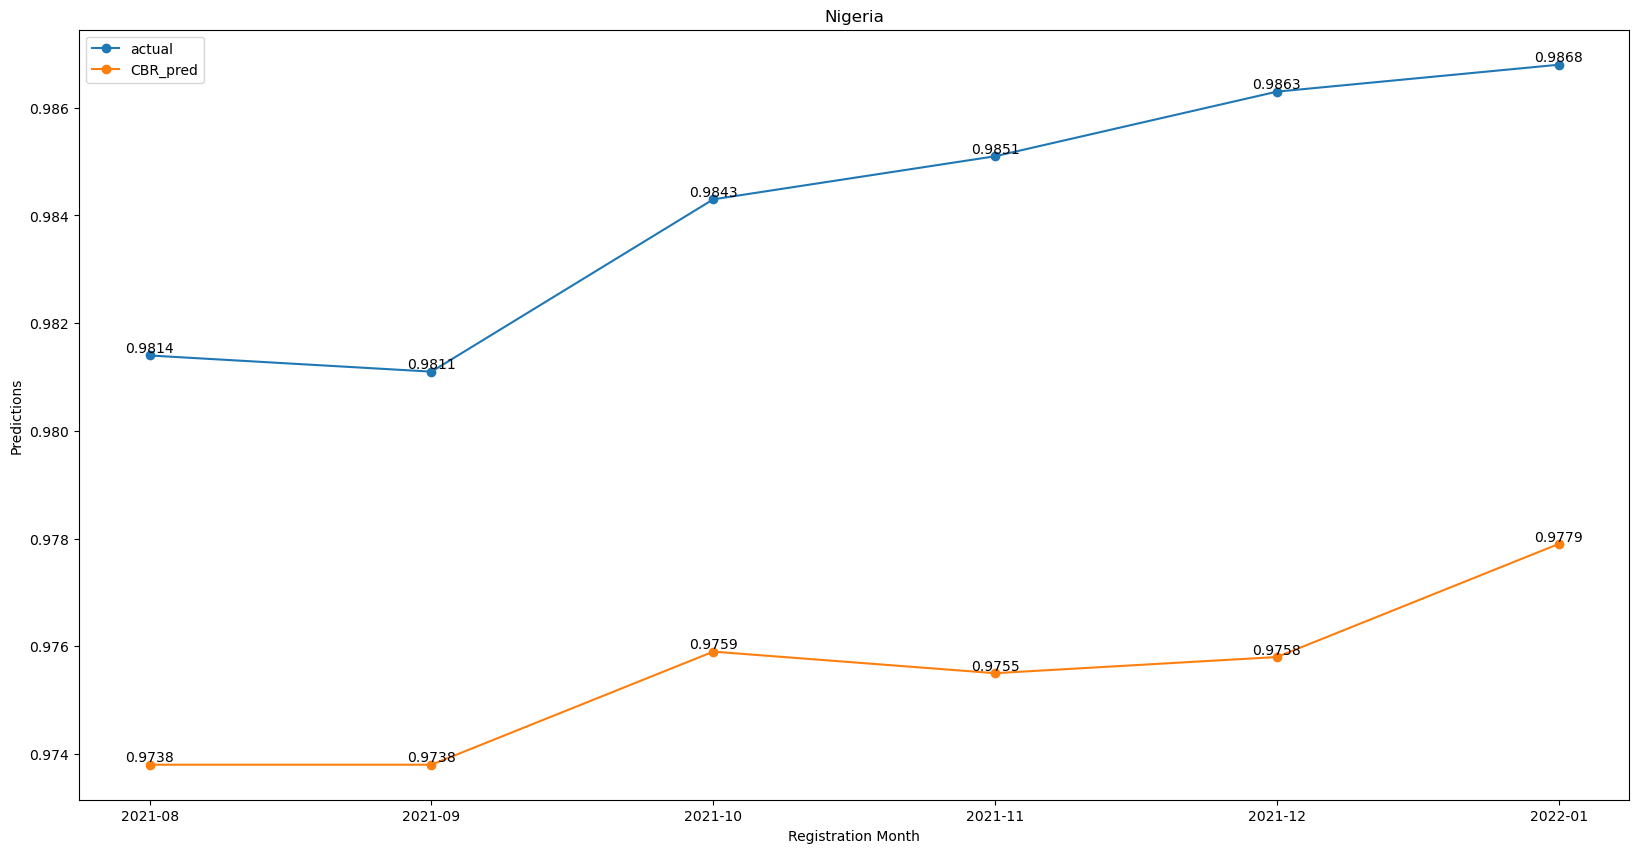

360
Avg error actual and pred: 0.0078


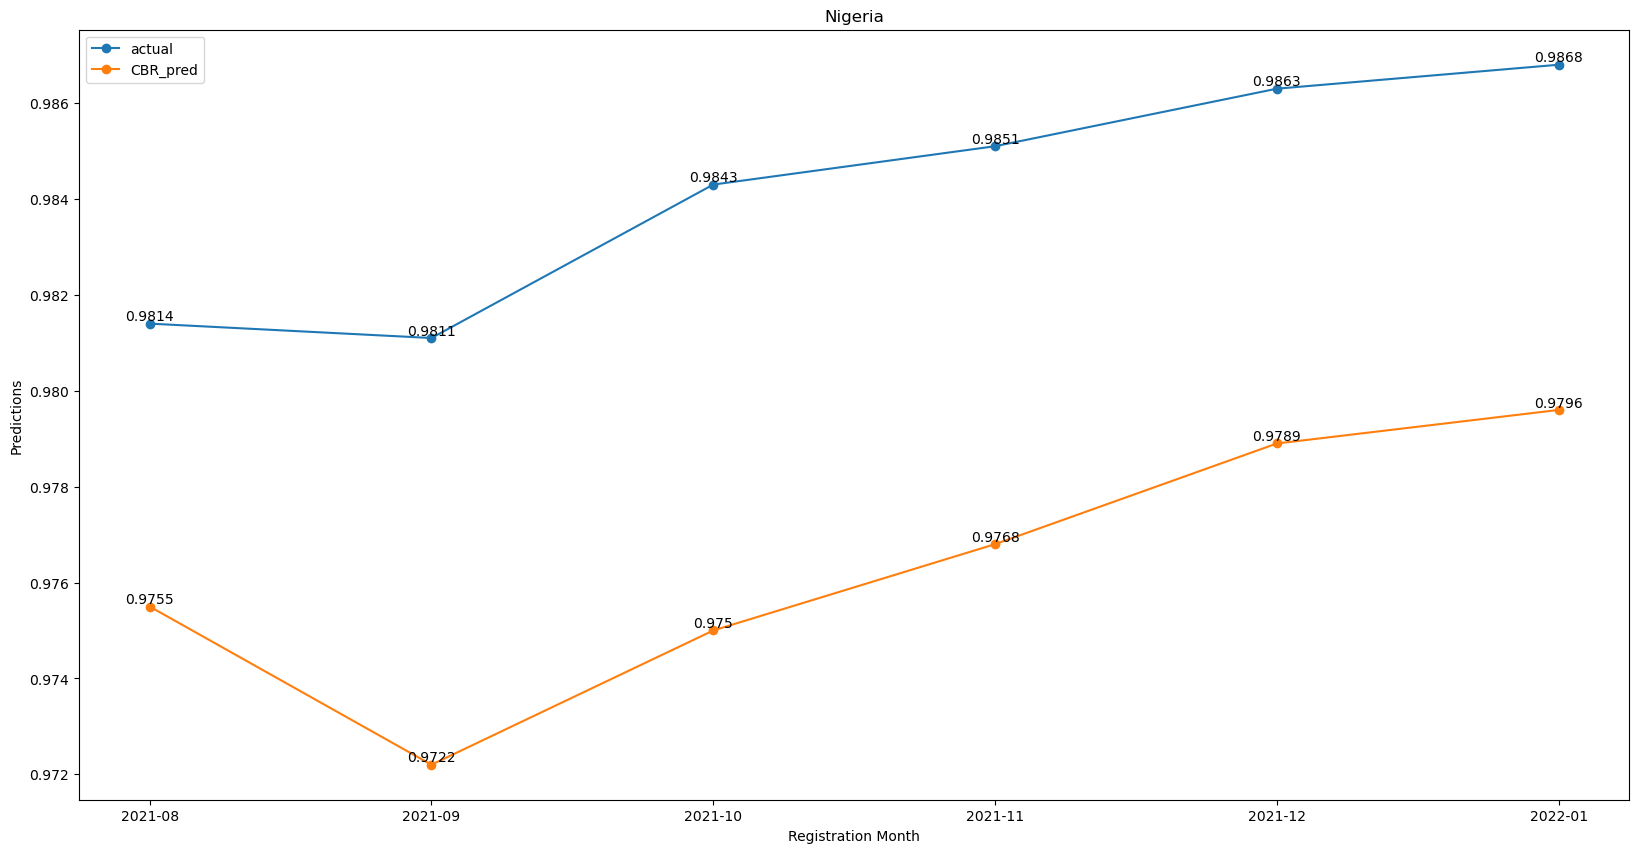

450
Avg error actual and pred: 0.0062


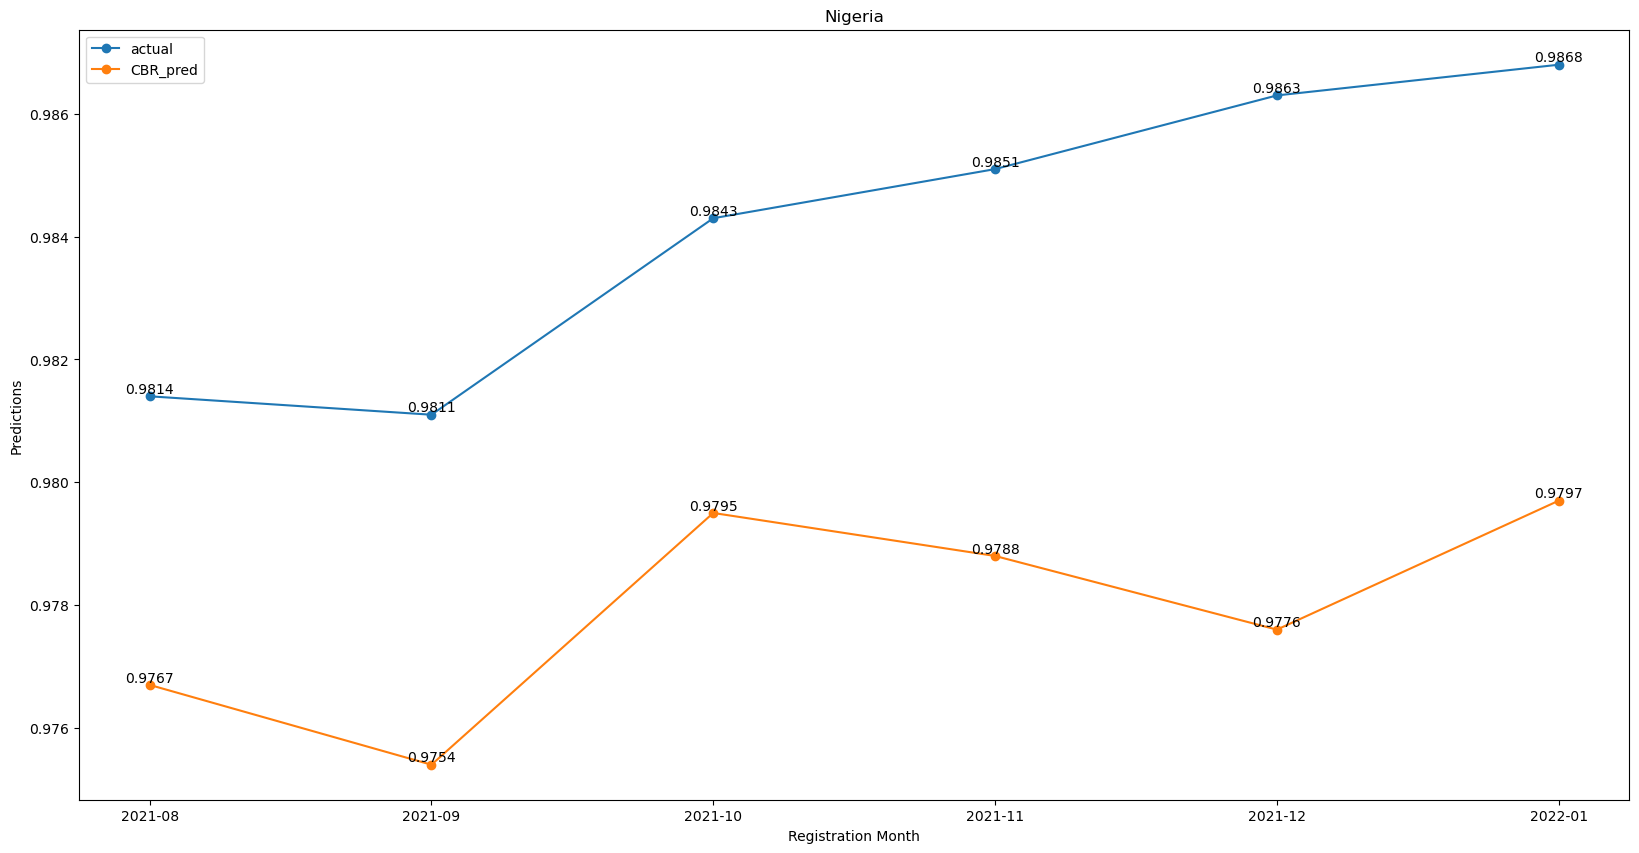

540
Avg error actual and pred: 0.0034


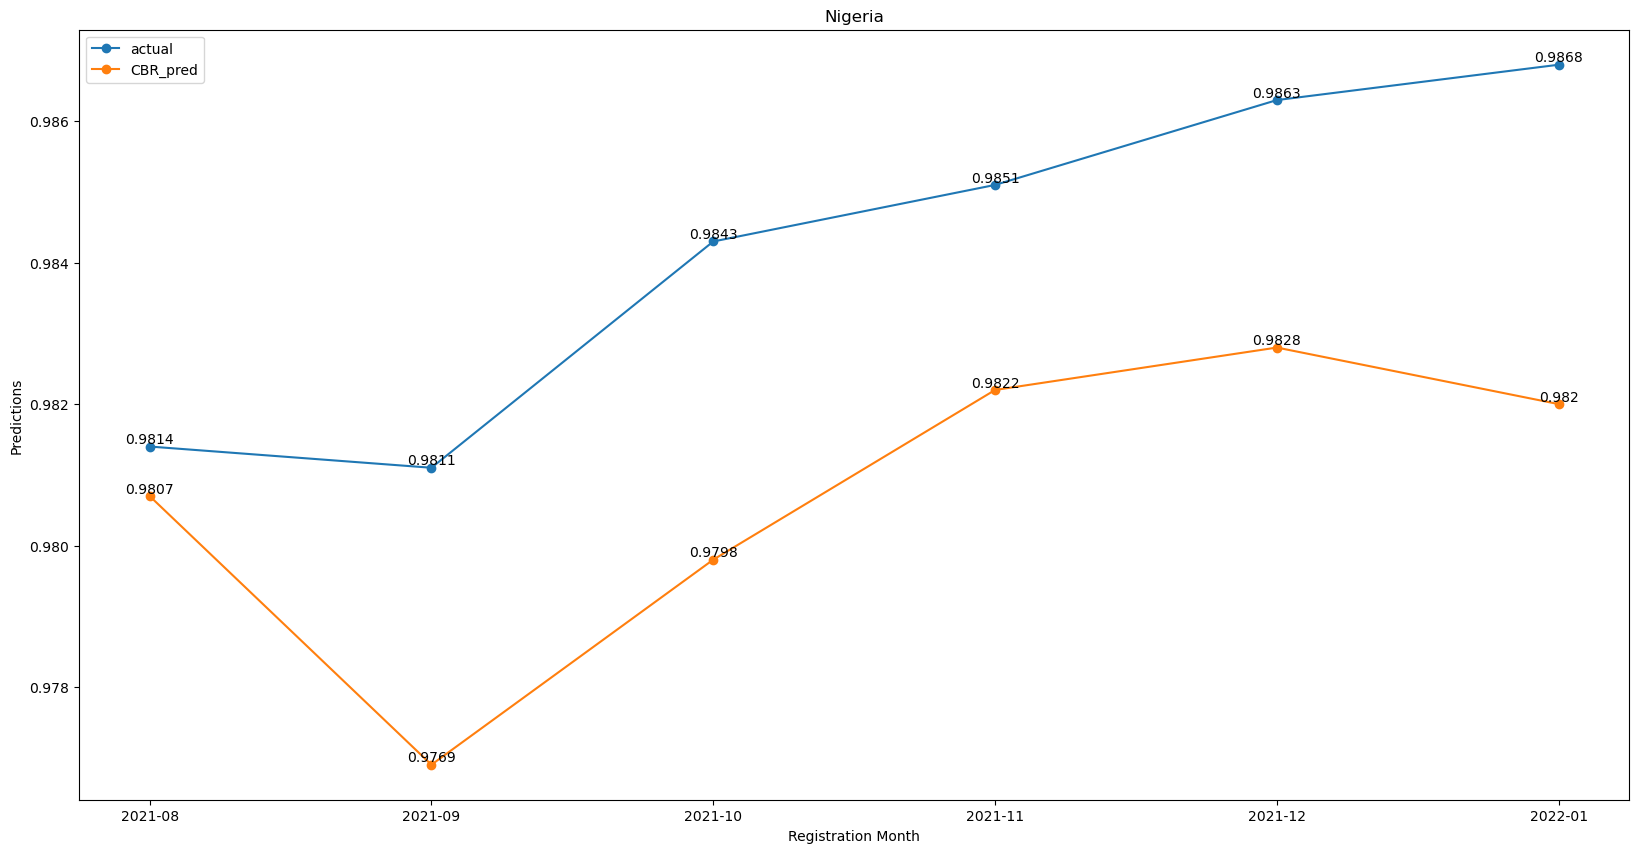

630
Avg error actual and pred: 0.0017


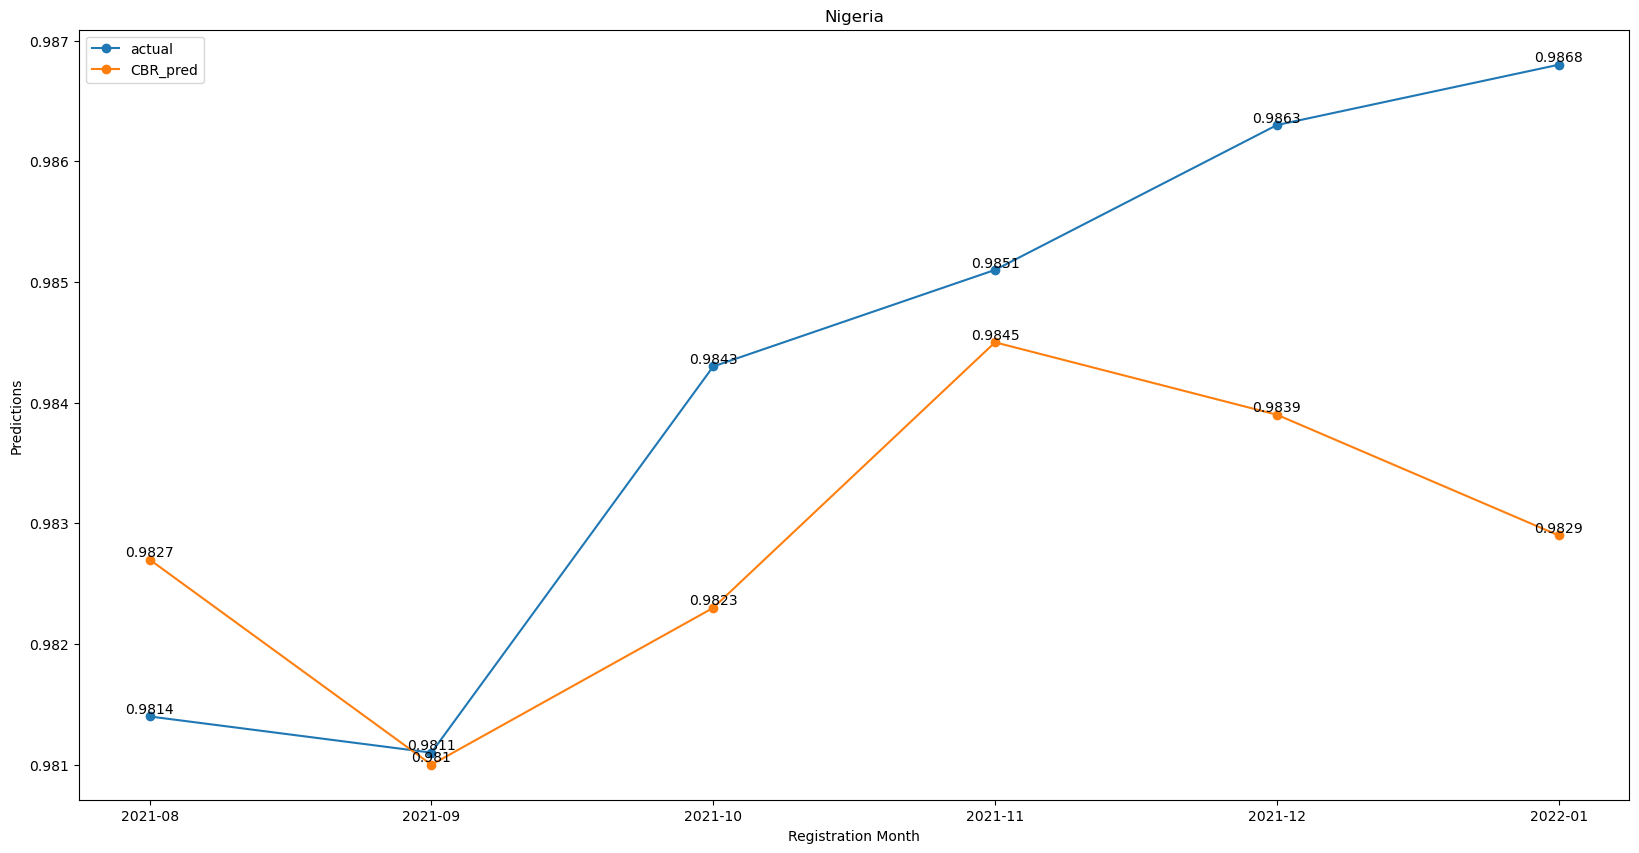

720
Avg error actual and pred: 0.0019


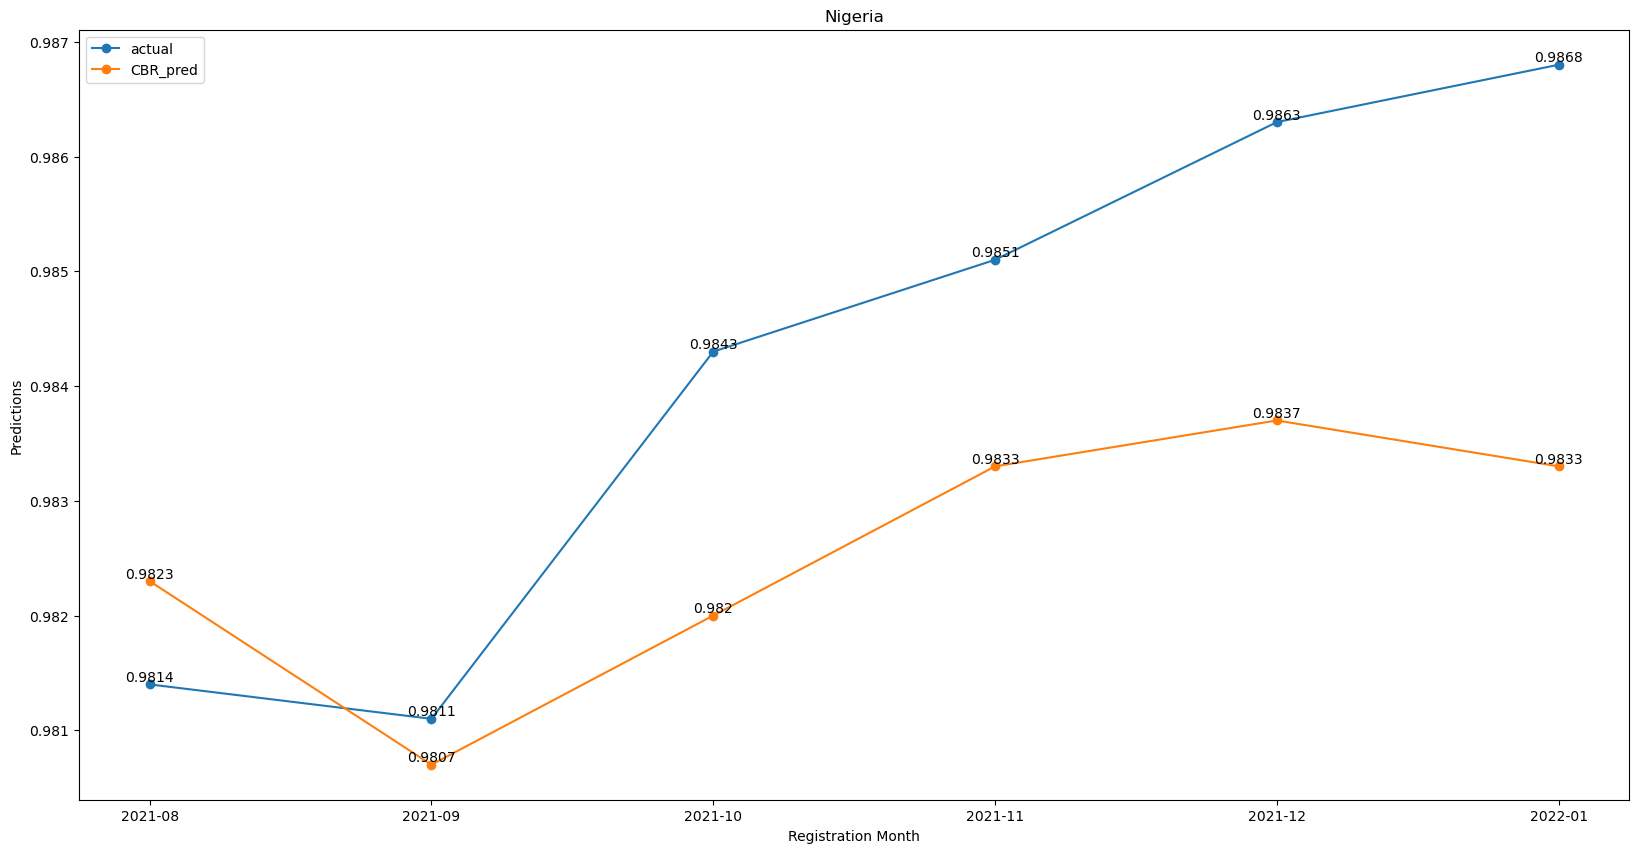

----------------------------------------------------------------------
Tanzania
30
Avg error actual and pred: 0.0103


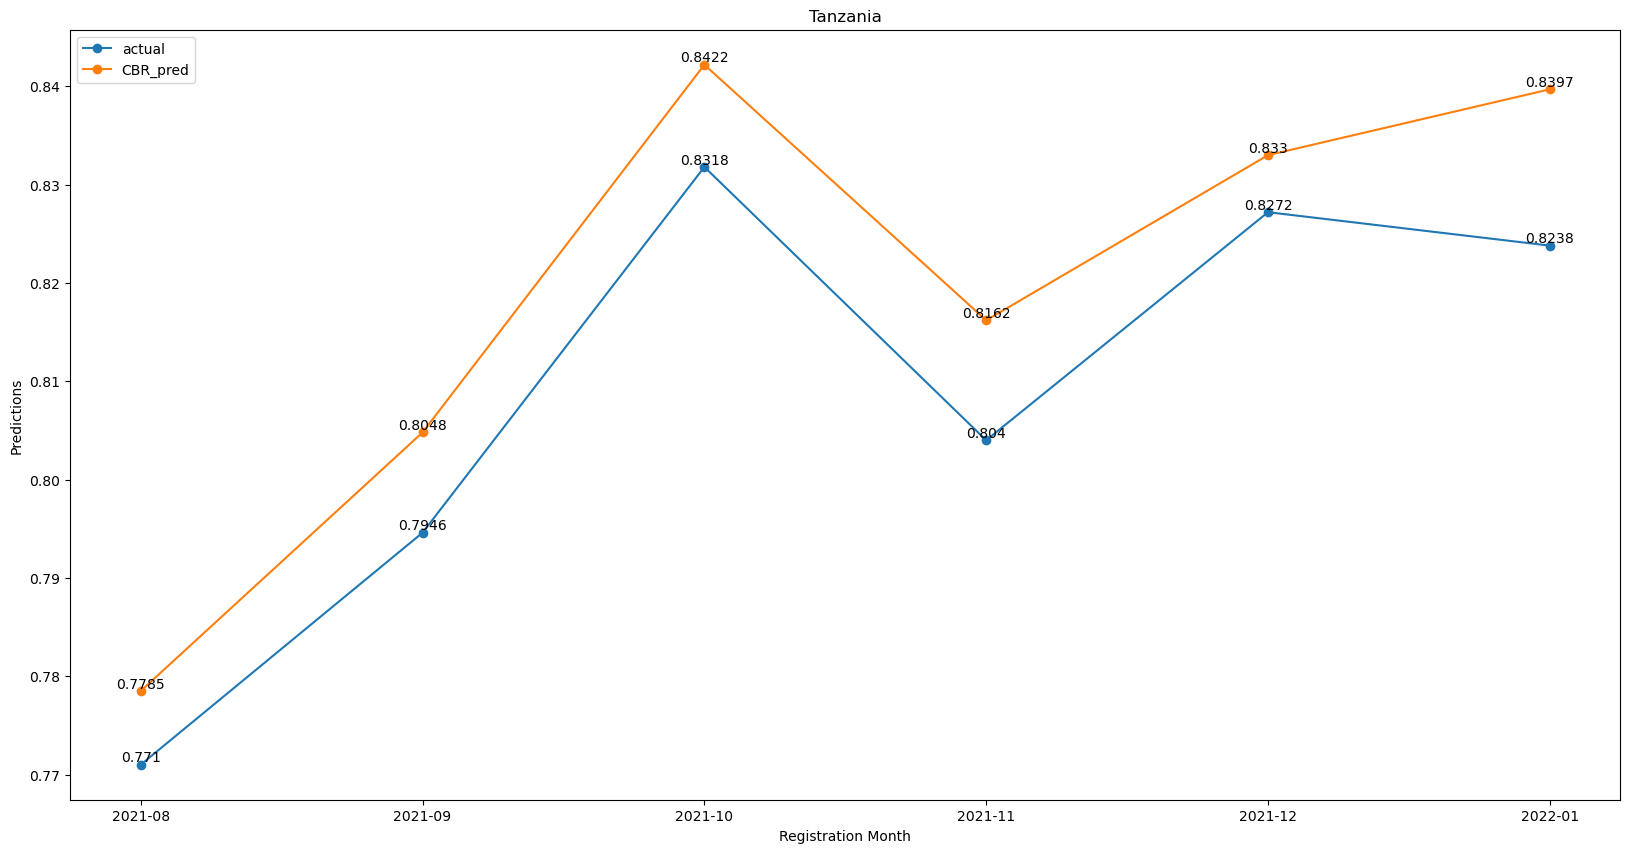

60
Avg error actual and pred: 0.0071


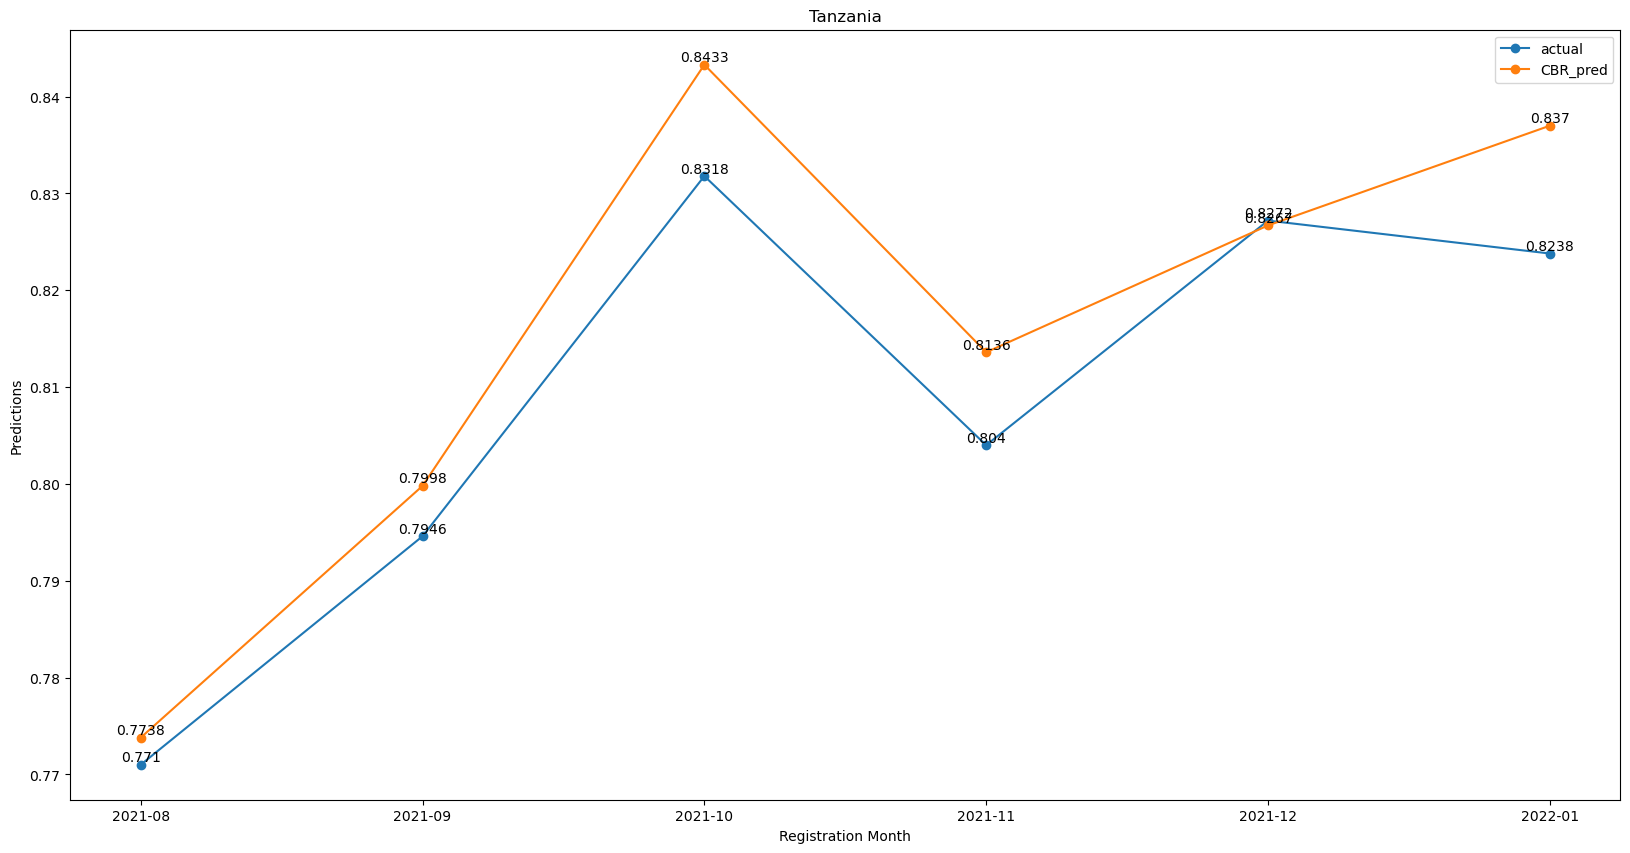

90
Avg error actual and pred: 0.0125


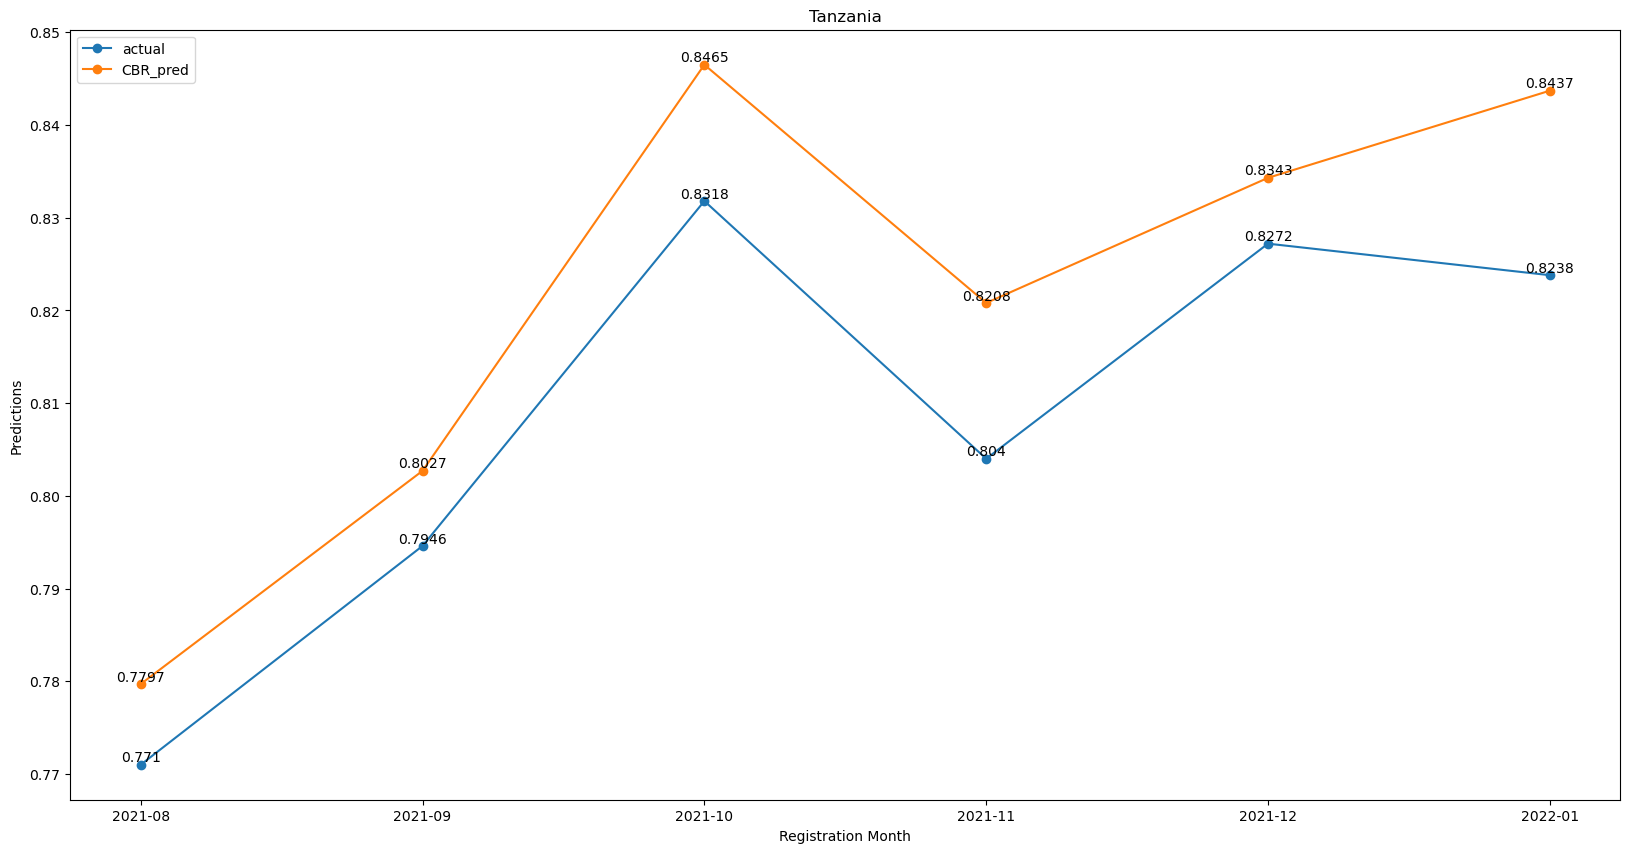

180
Avg error actual and pred: 0.0116


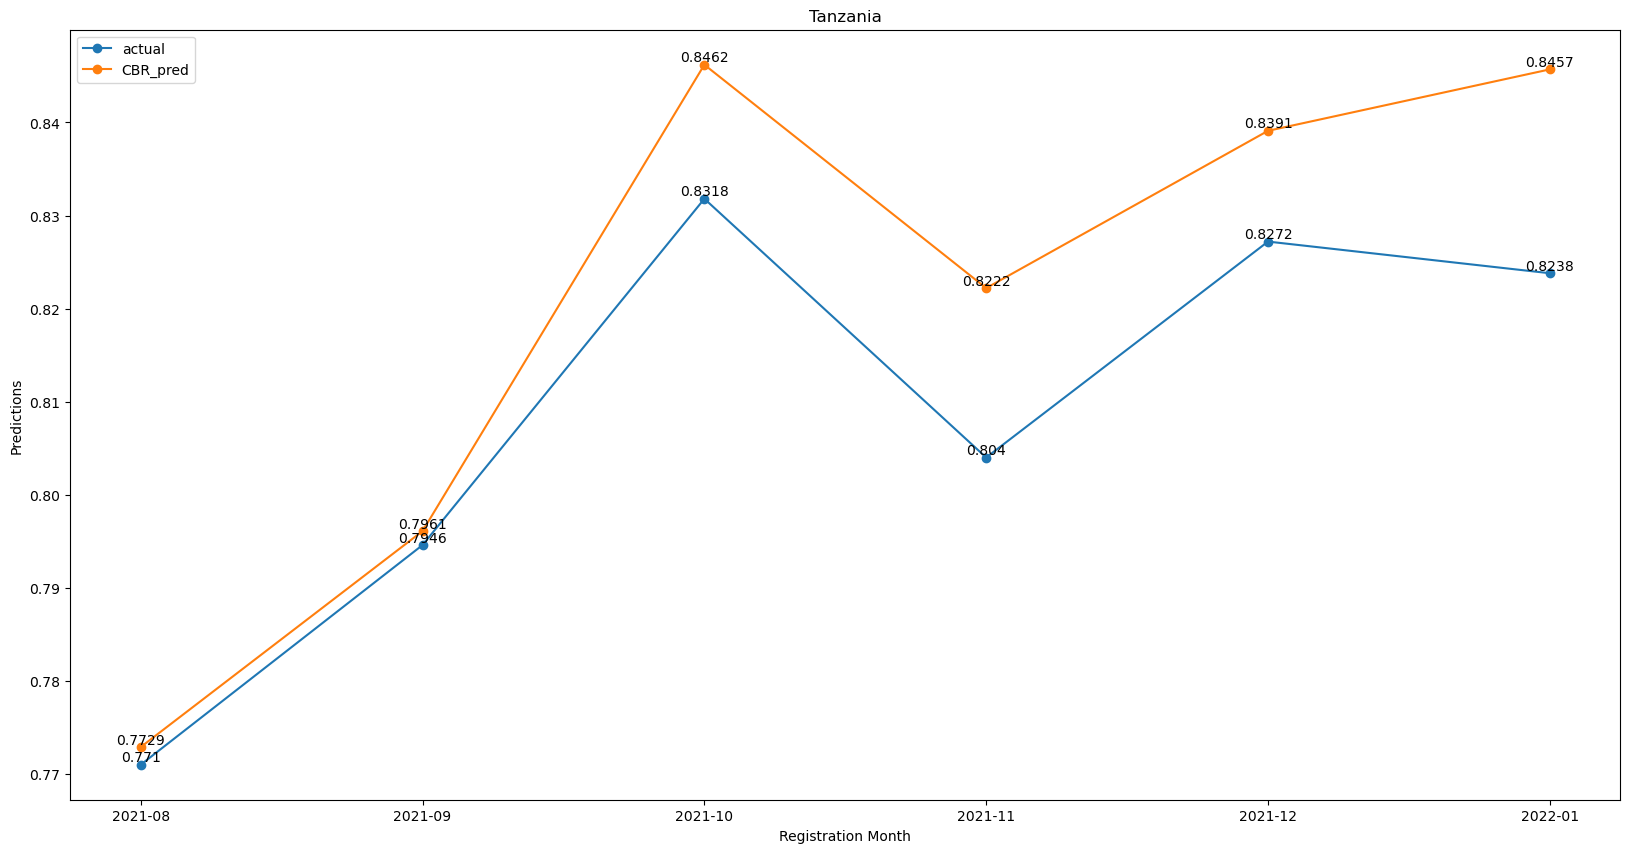

270
Avg error actual and pred: 0.0204


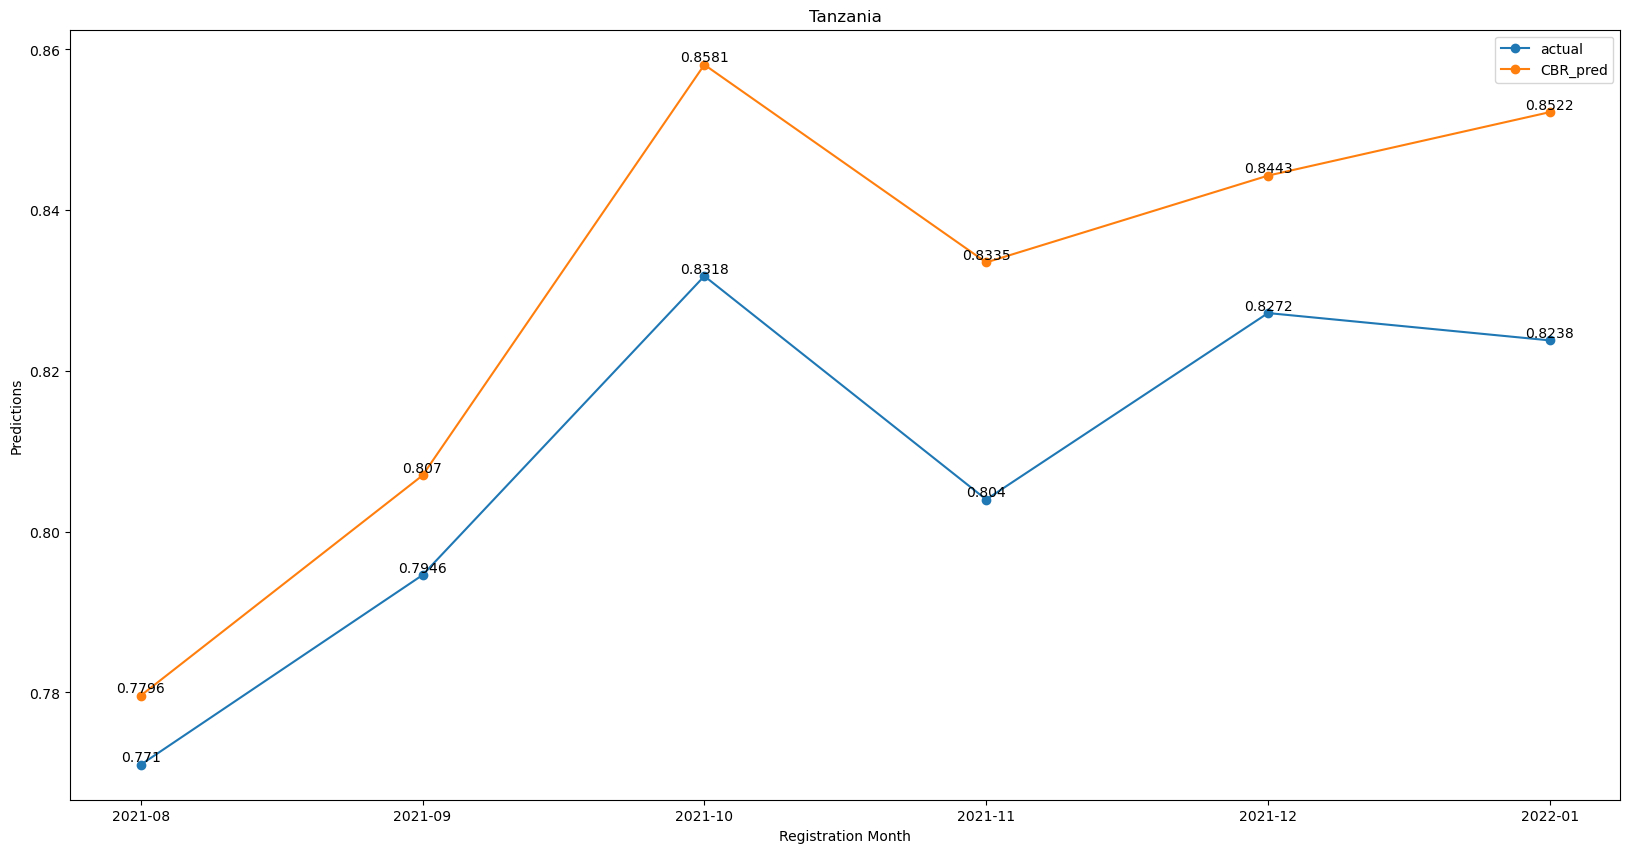

360
Avg error actual and pred: 0.0174


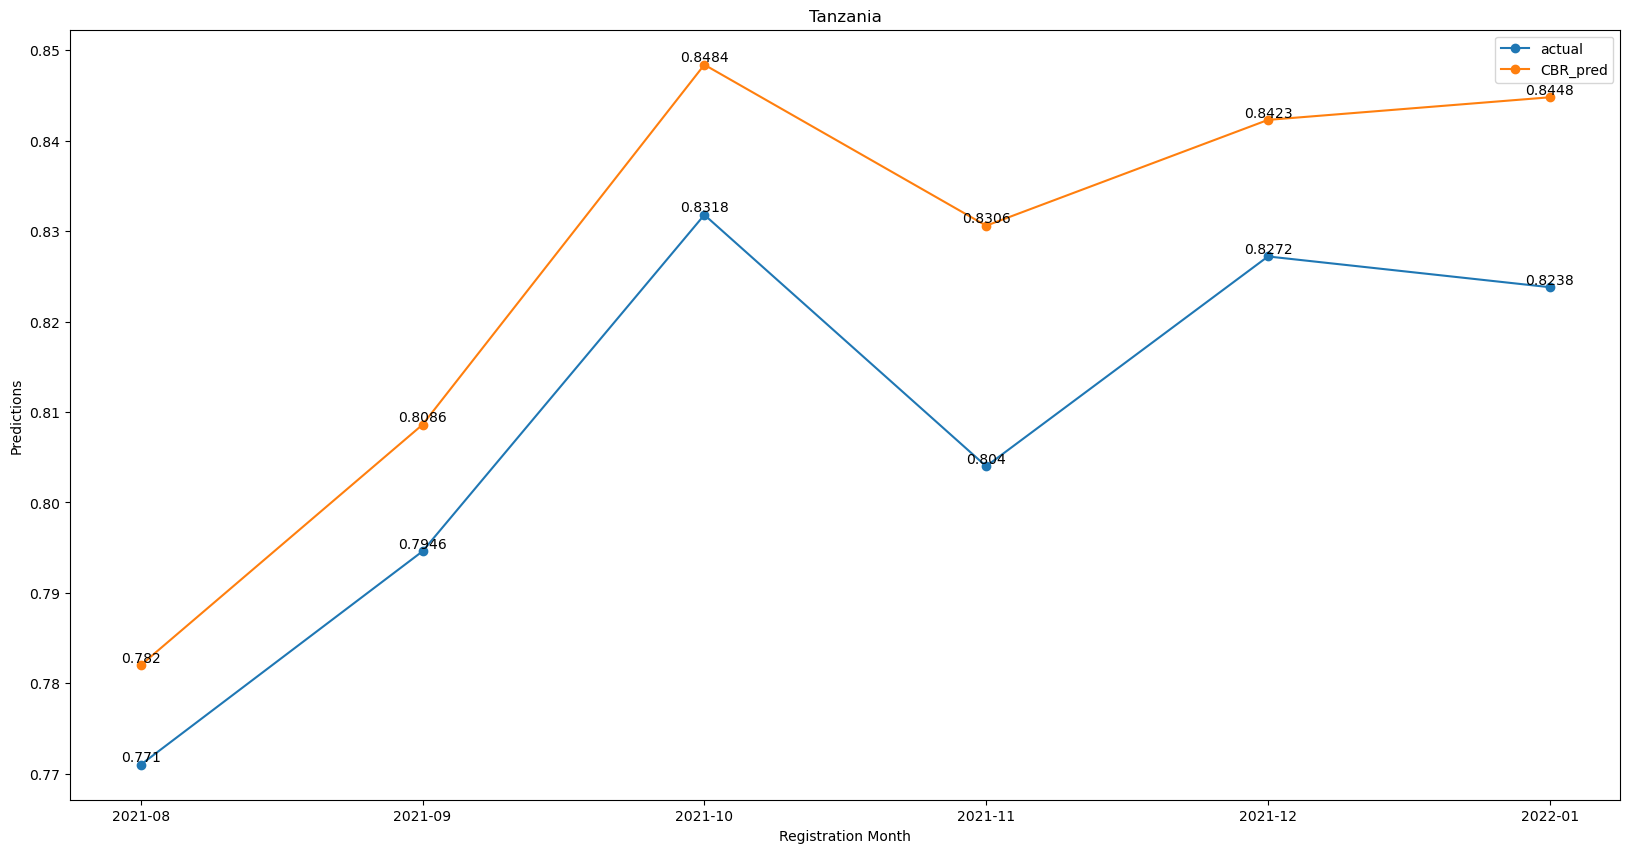

450
Avg error actual and pred: 0.0085


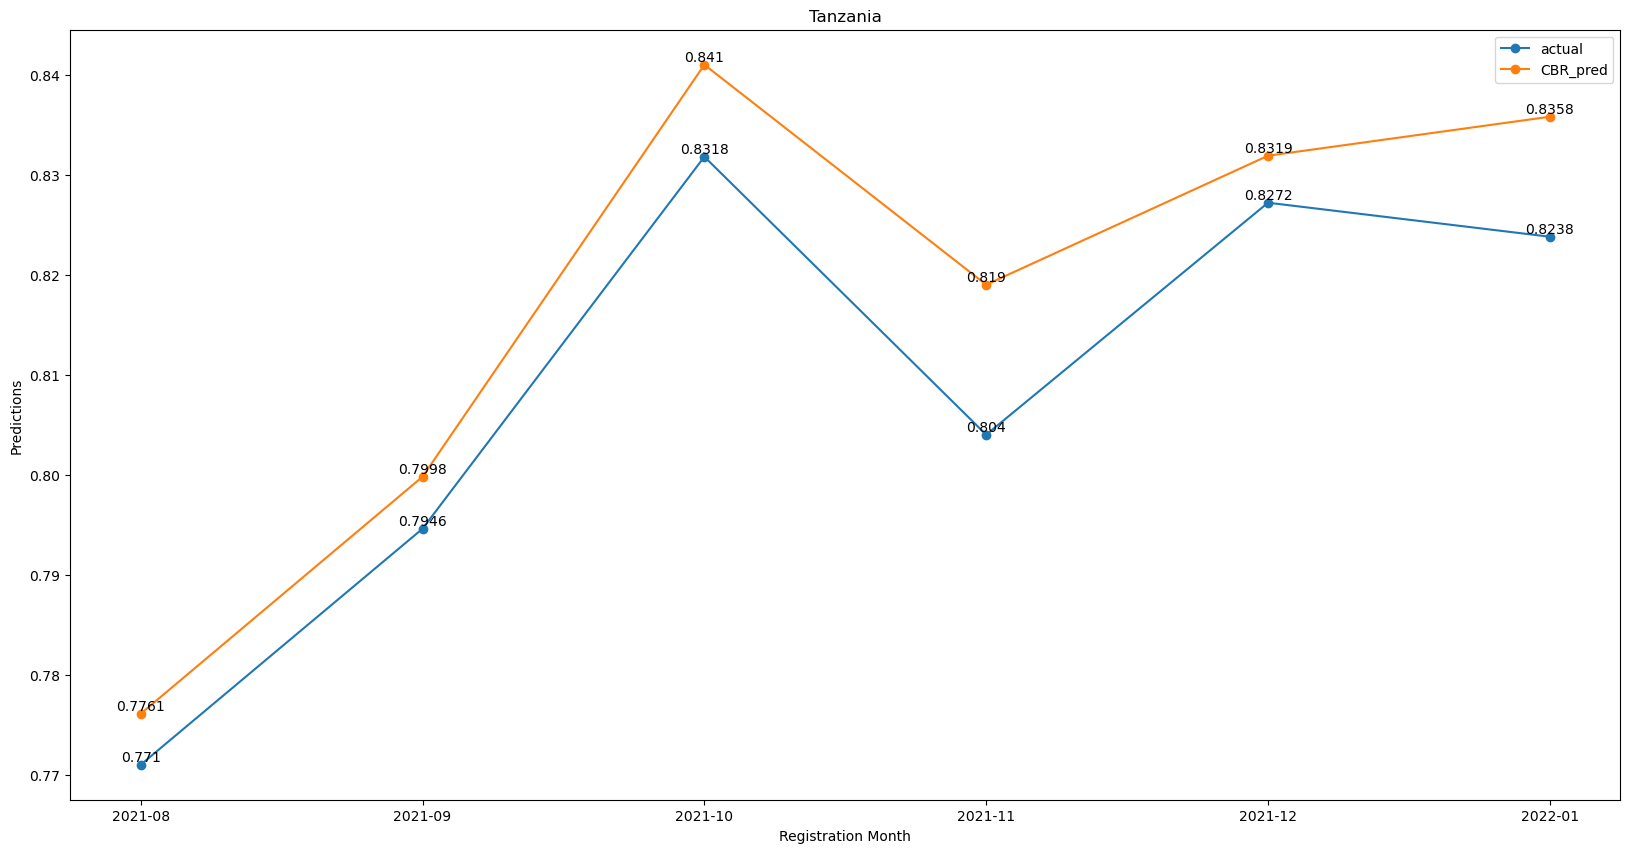

540
Avg error actual and pred: 0.0053


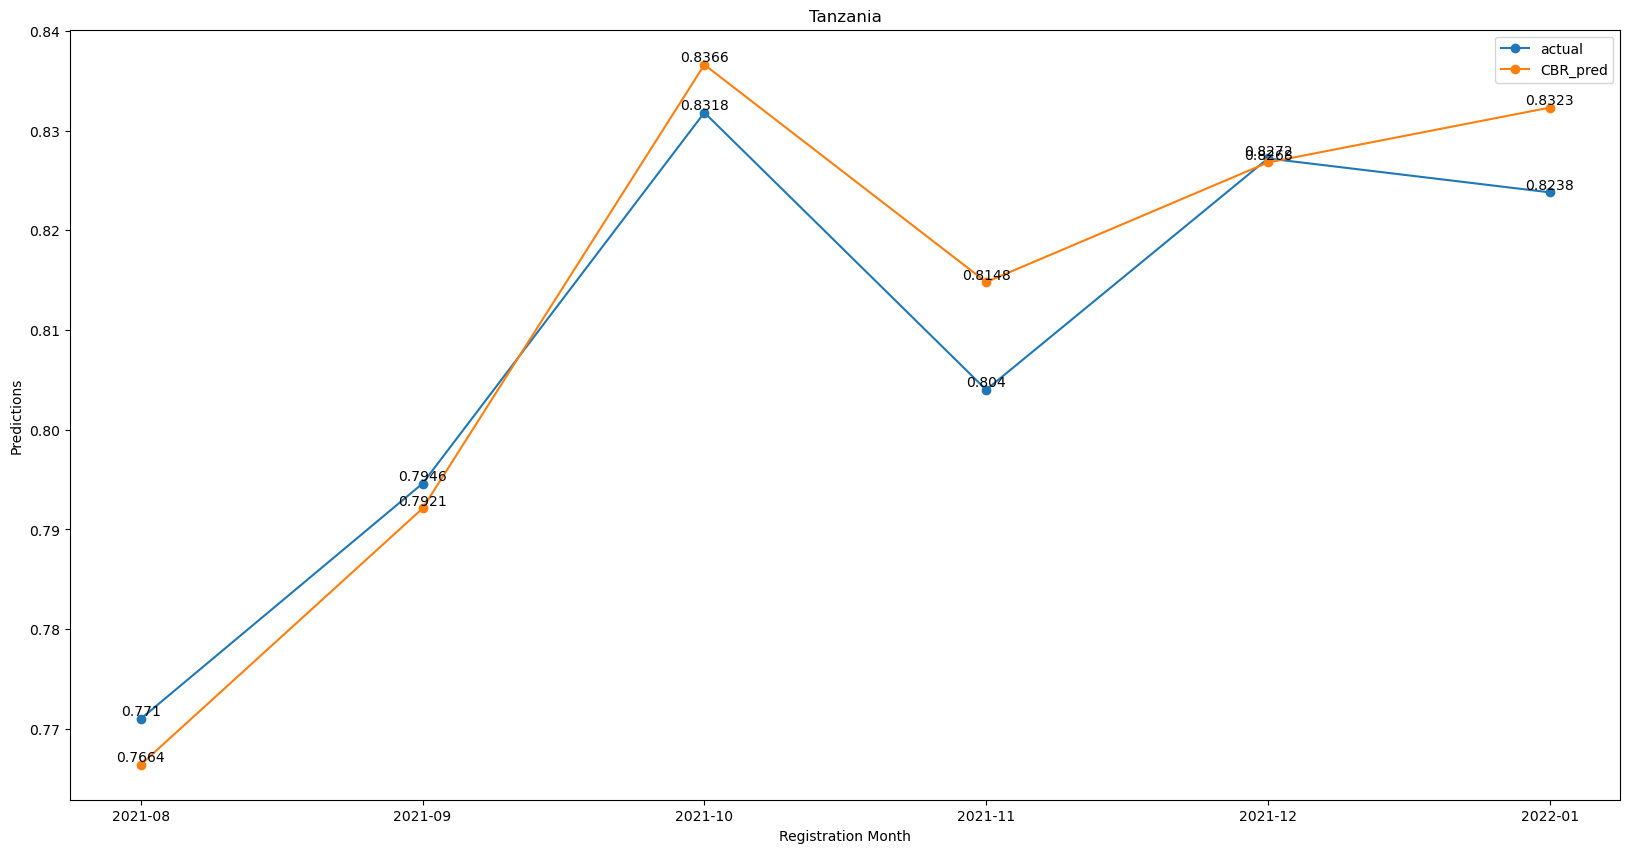

630
Avg error actual and pred: 0.0051


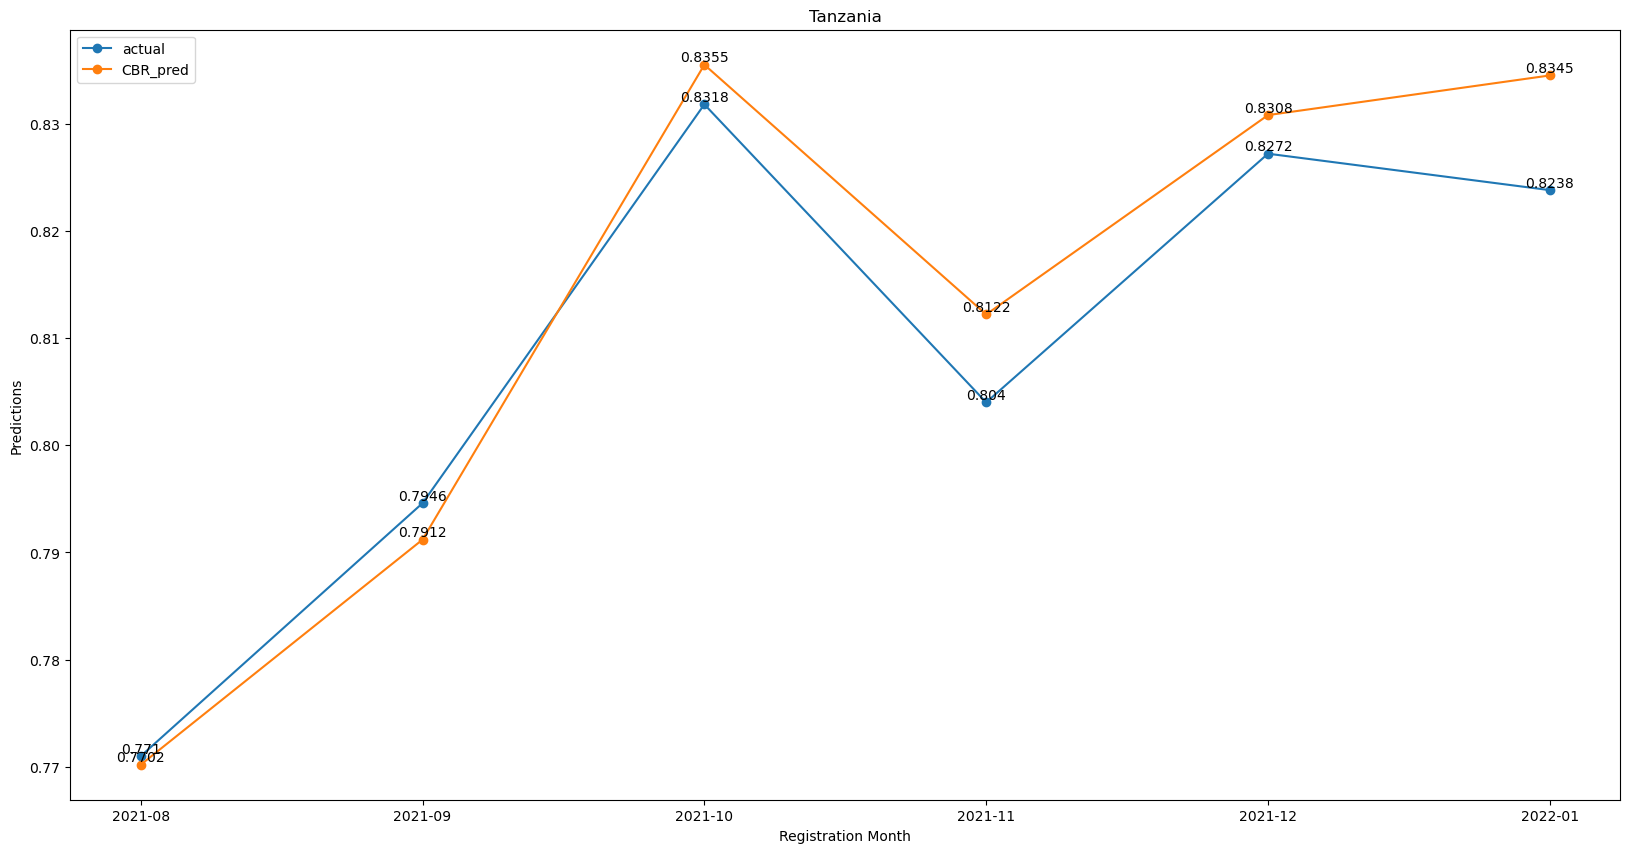

720
Avg error actual and pred: 0.0055


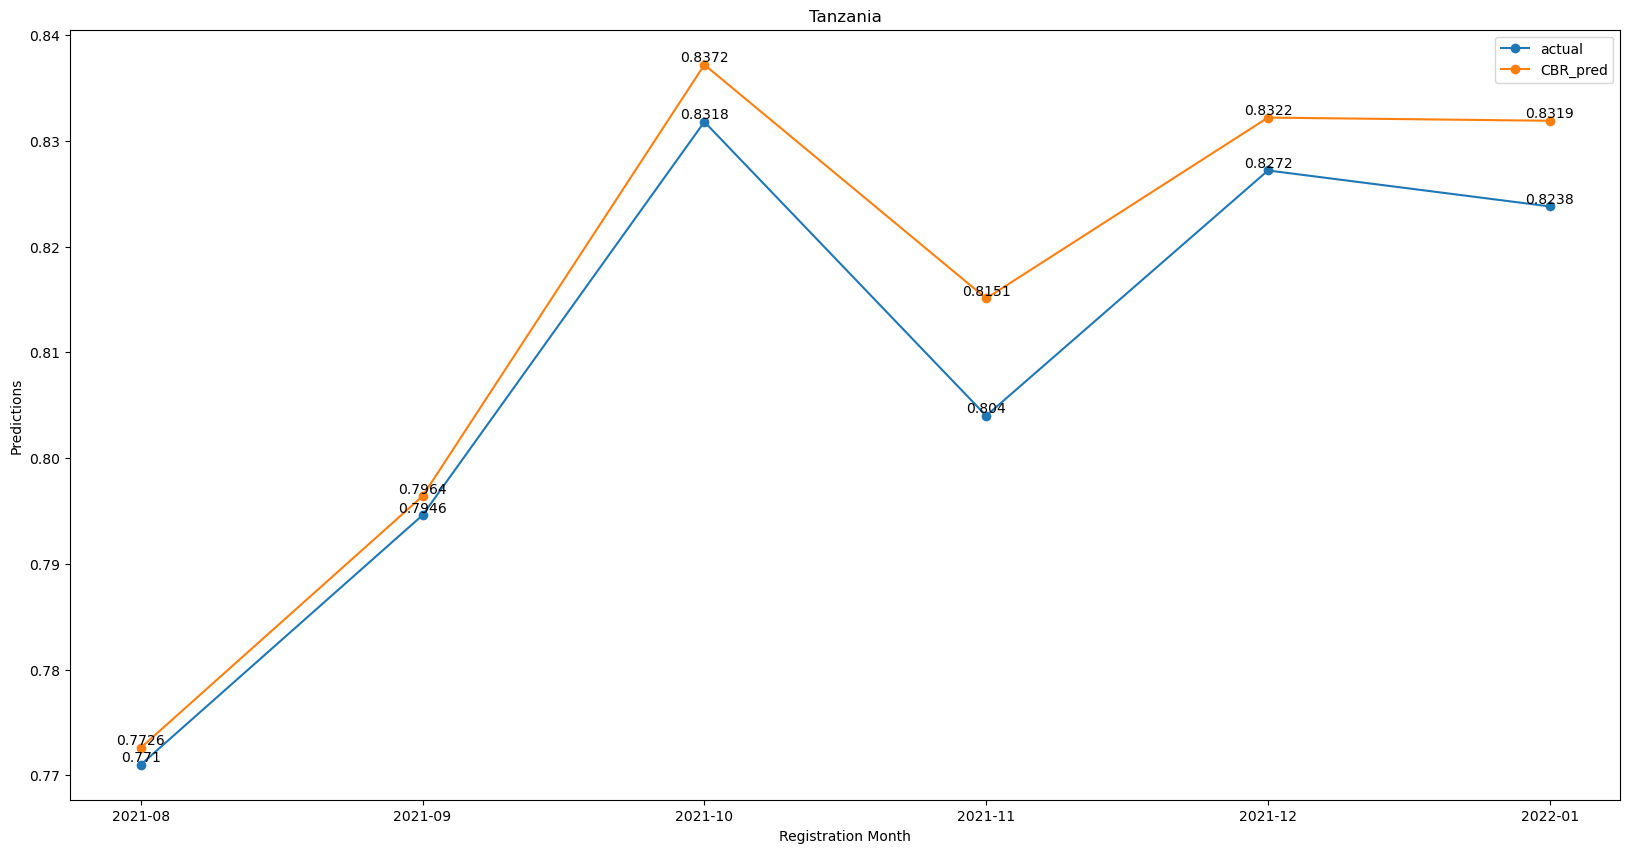

----------------------------------------------------------------------
Uganda
30
Avg error actual and pred: 0.088


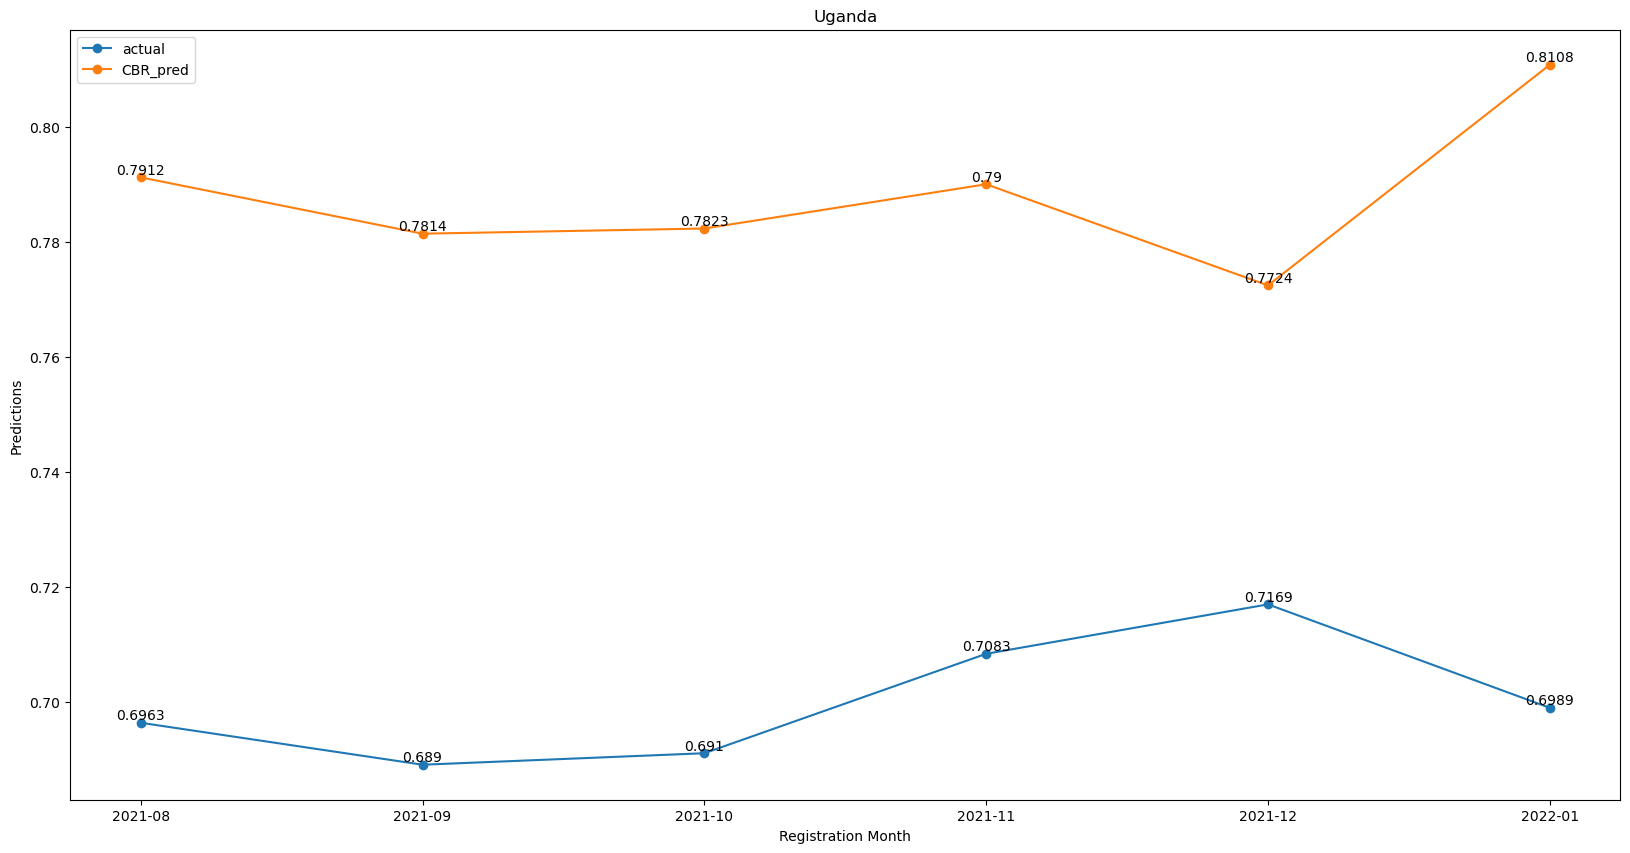

60
Avg error actual and pred: 0.0624


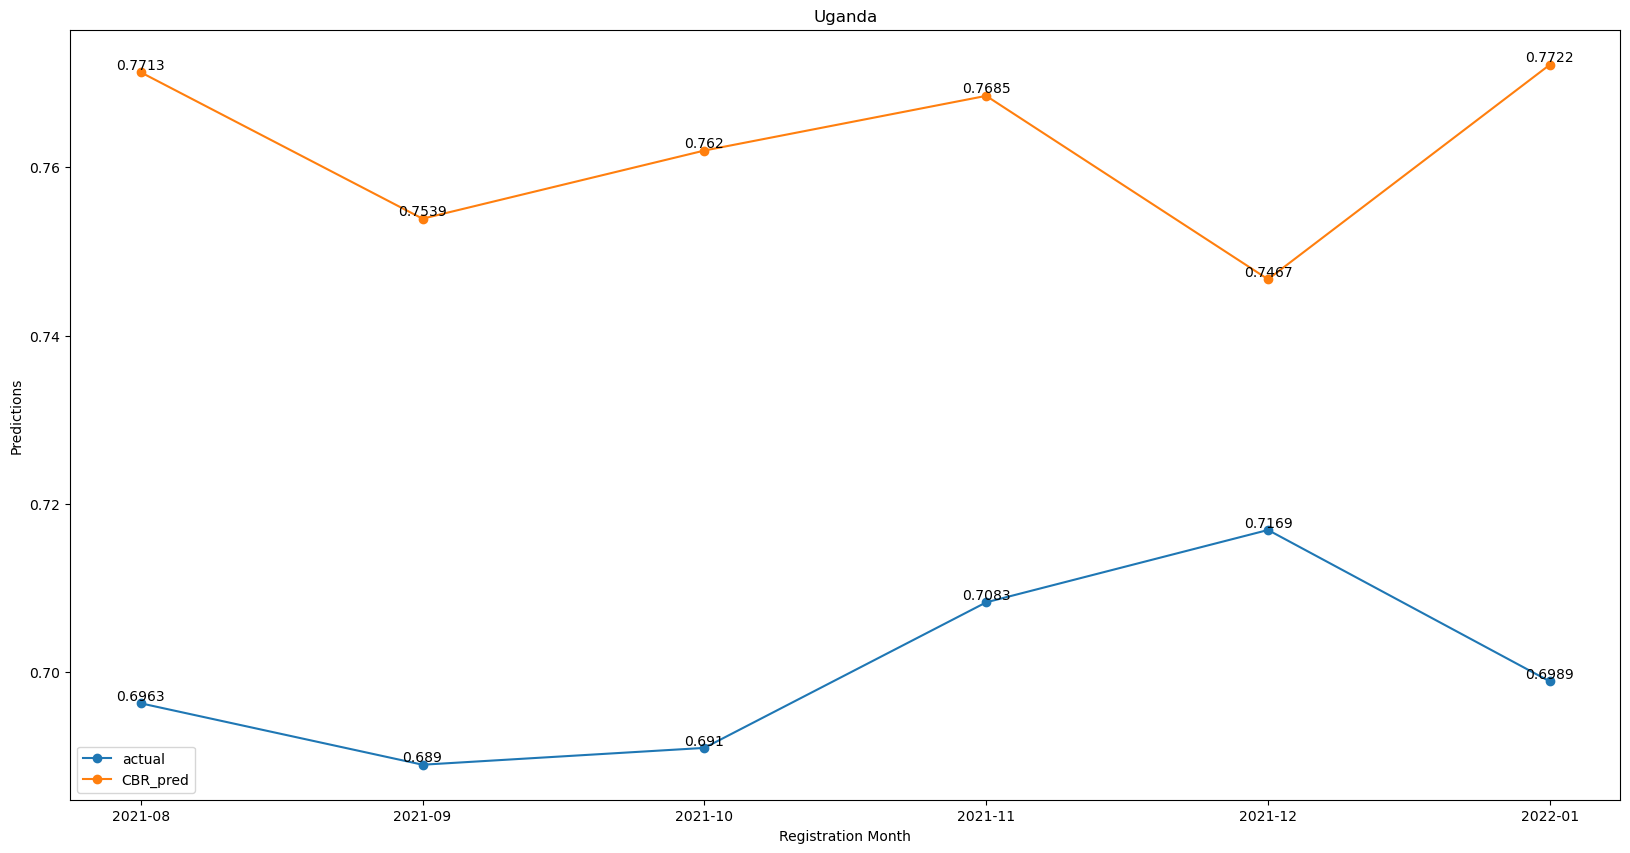

90
Avg error actual and pred: 0.056


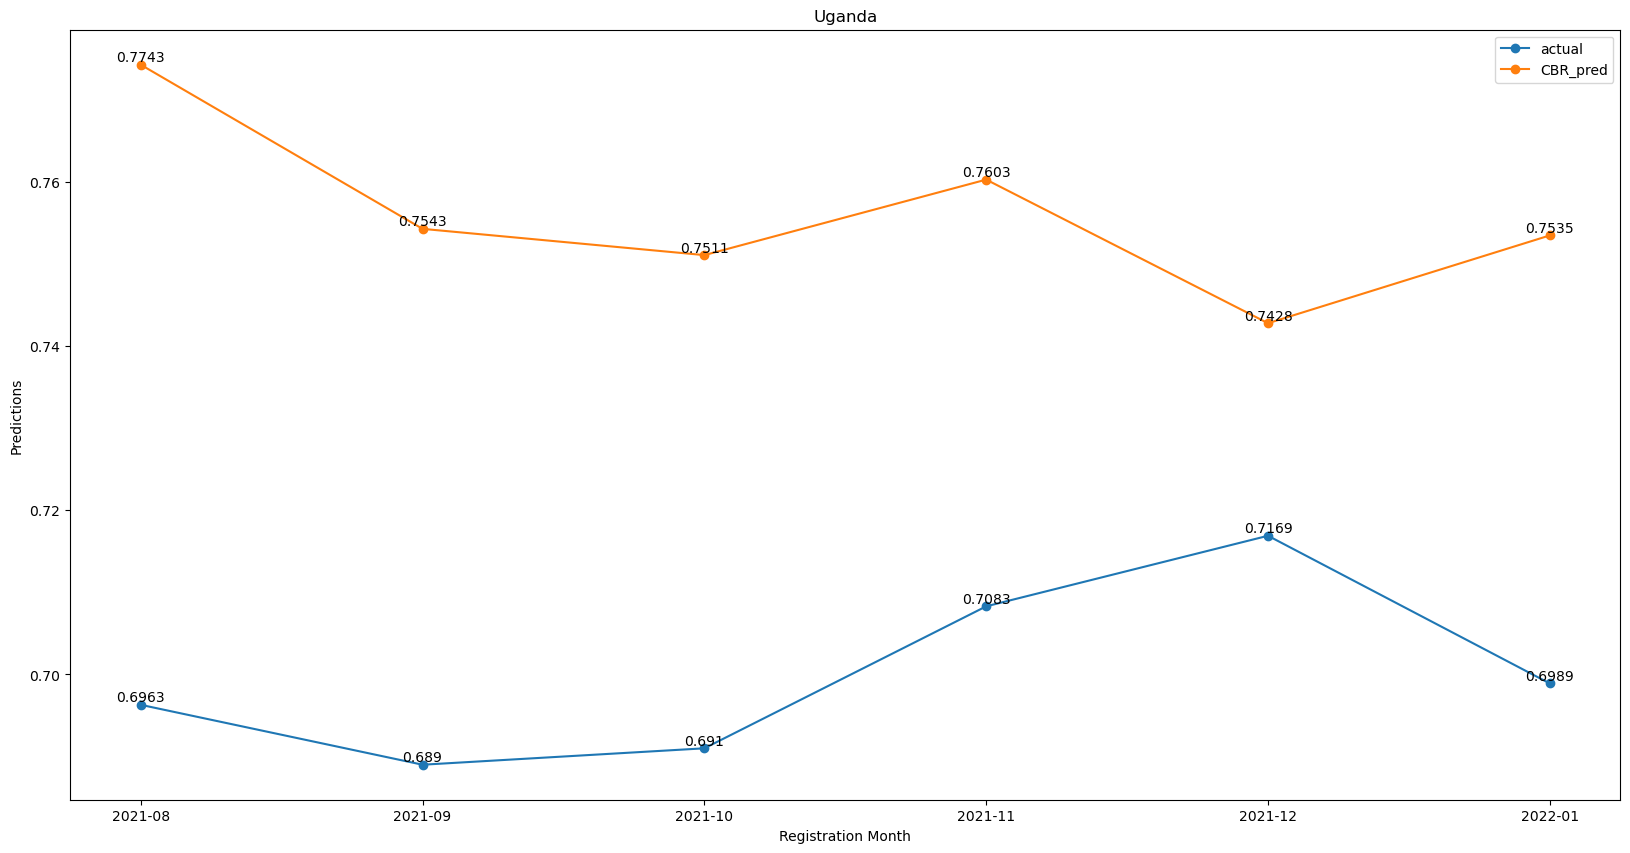

180
Avg error actual and pred: 0.0314


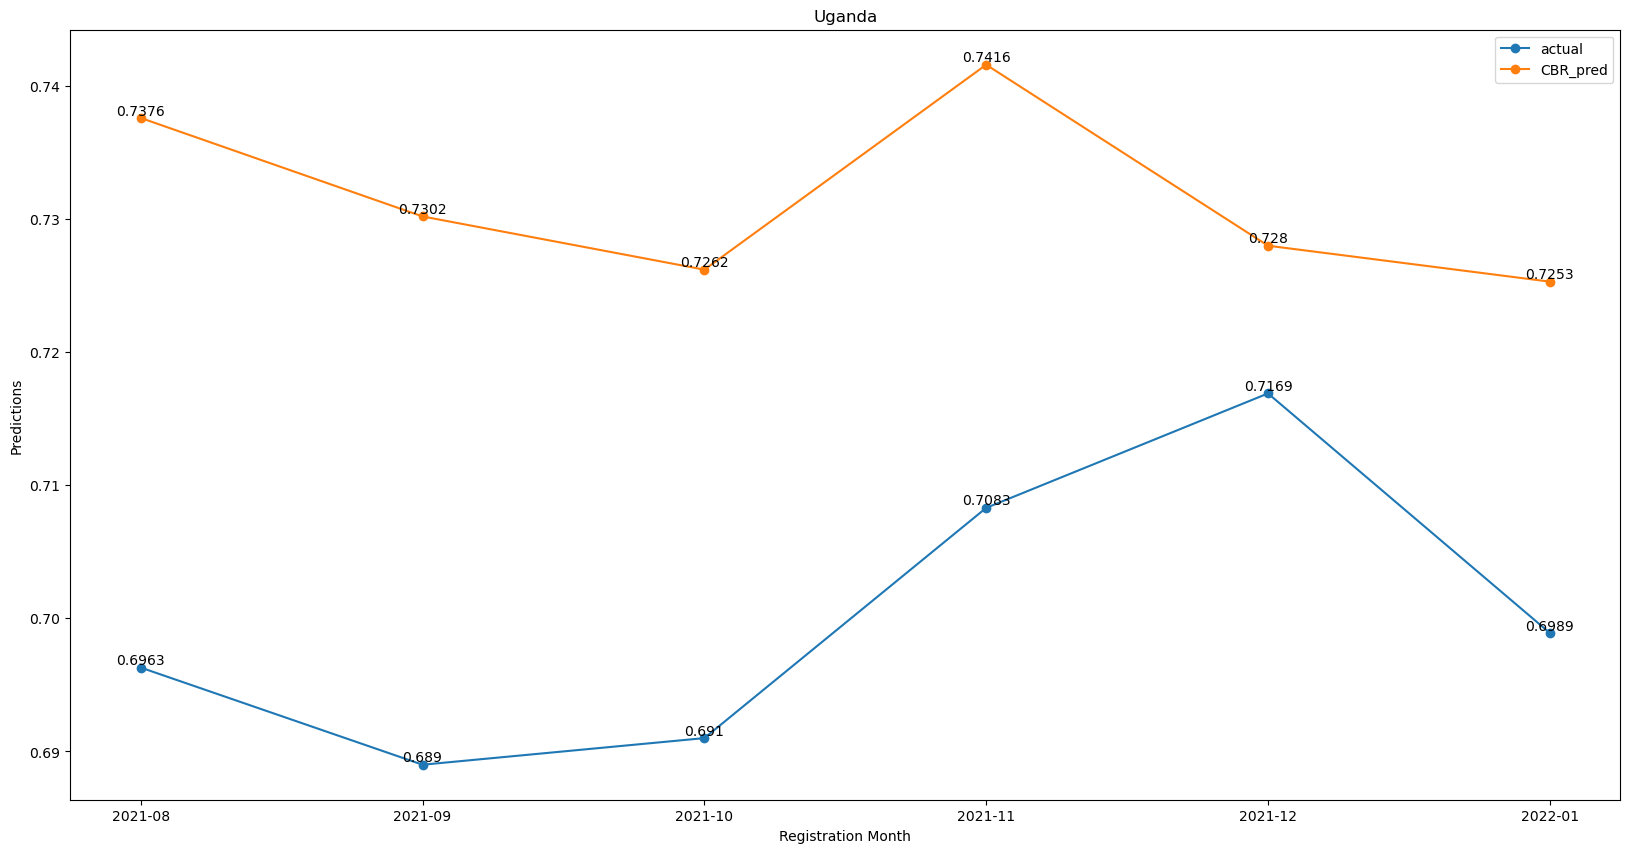

270
Avg error actual and pred: 0.0343


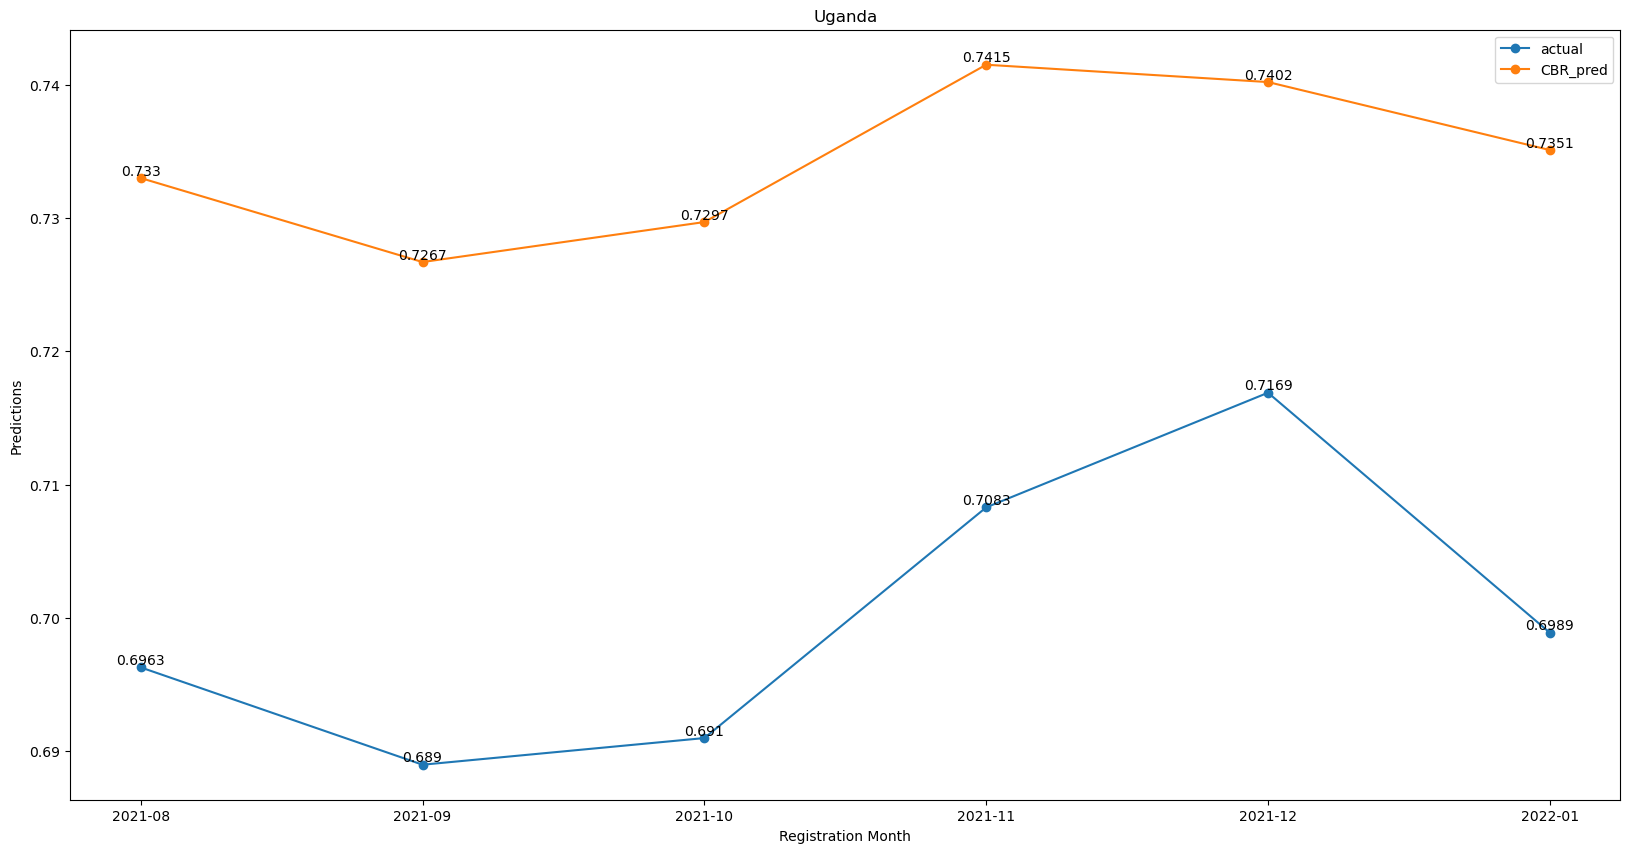

360
Avg error actual and pred: 0.0141


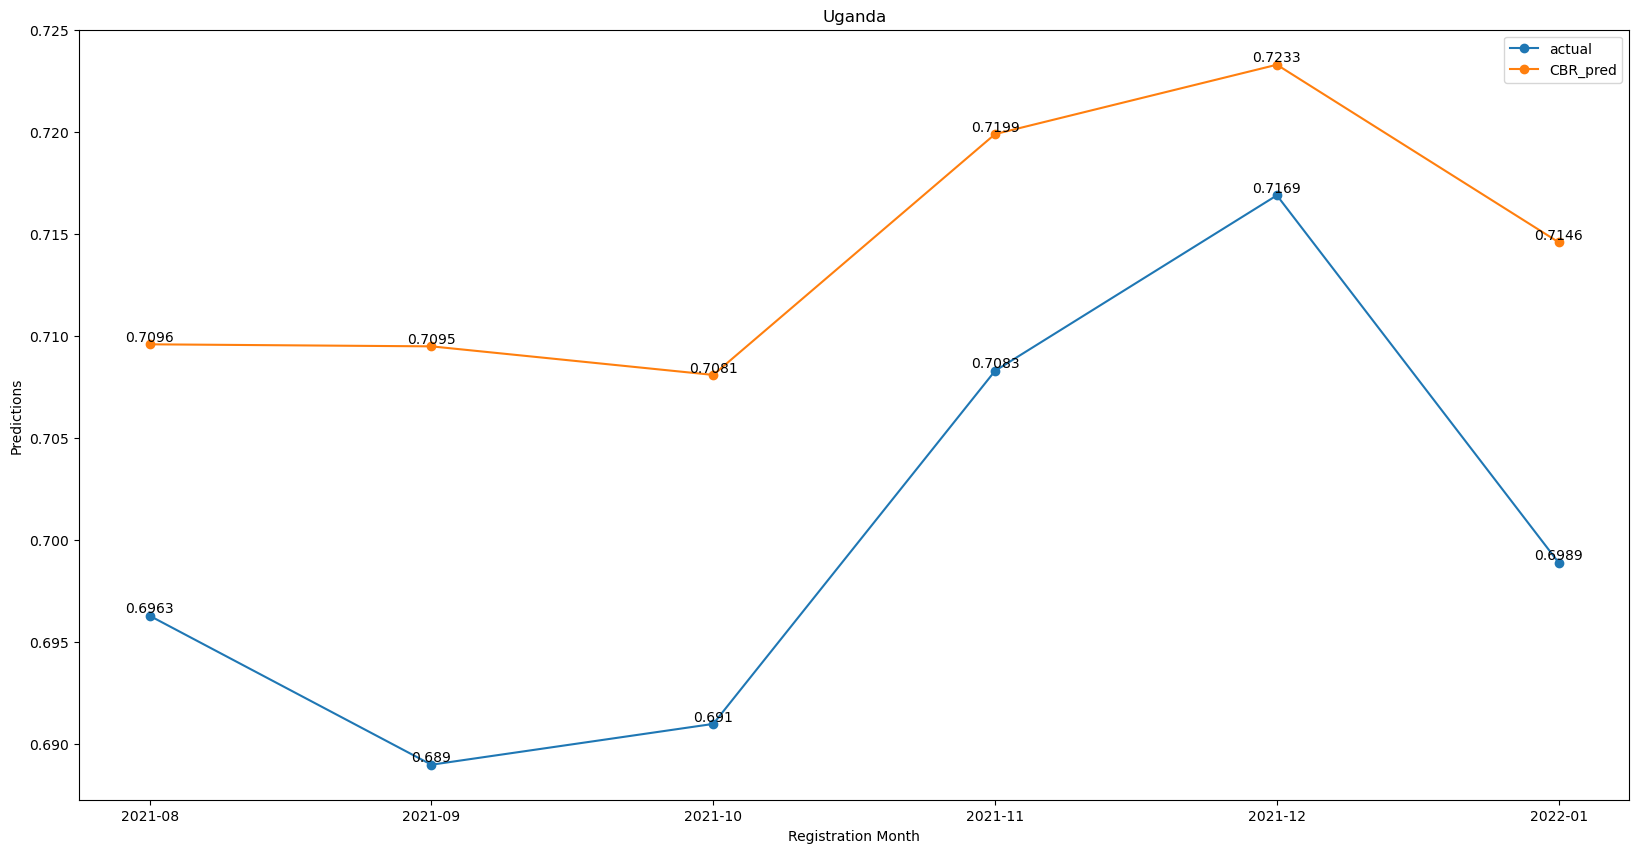

450
Avg error actual and pred: 0.0145


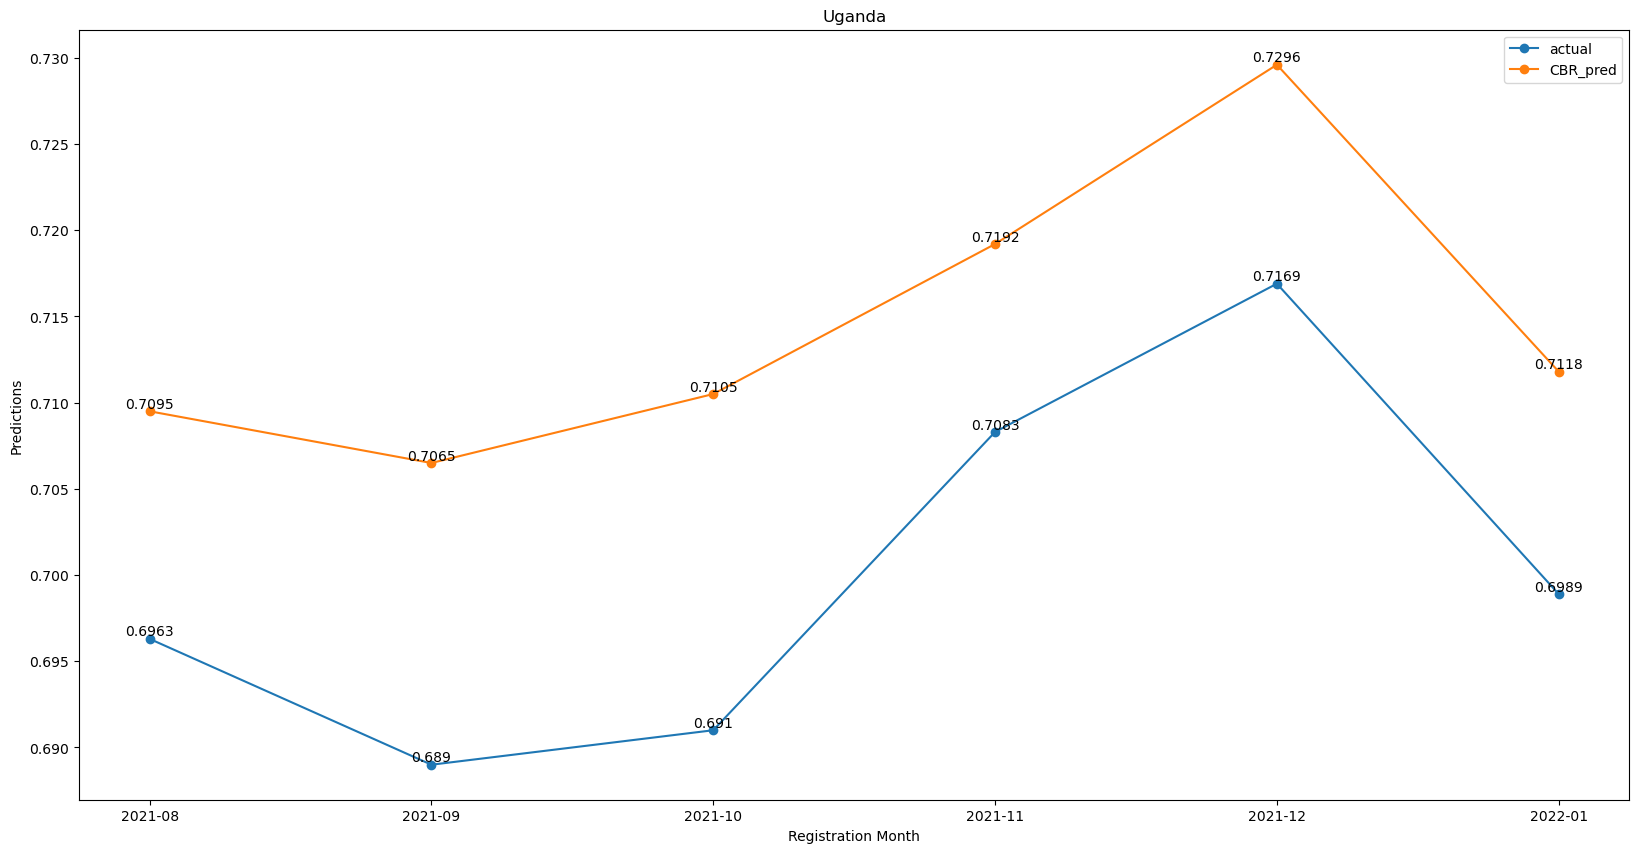

540
Avg error actual and pred: 0.0072


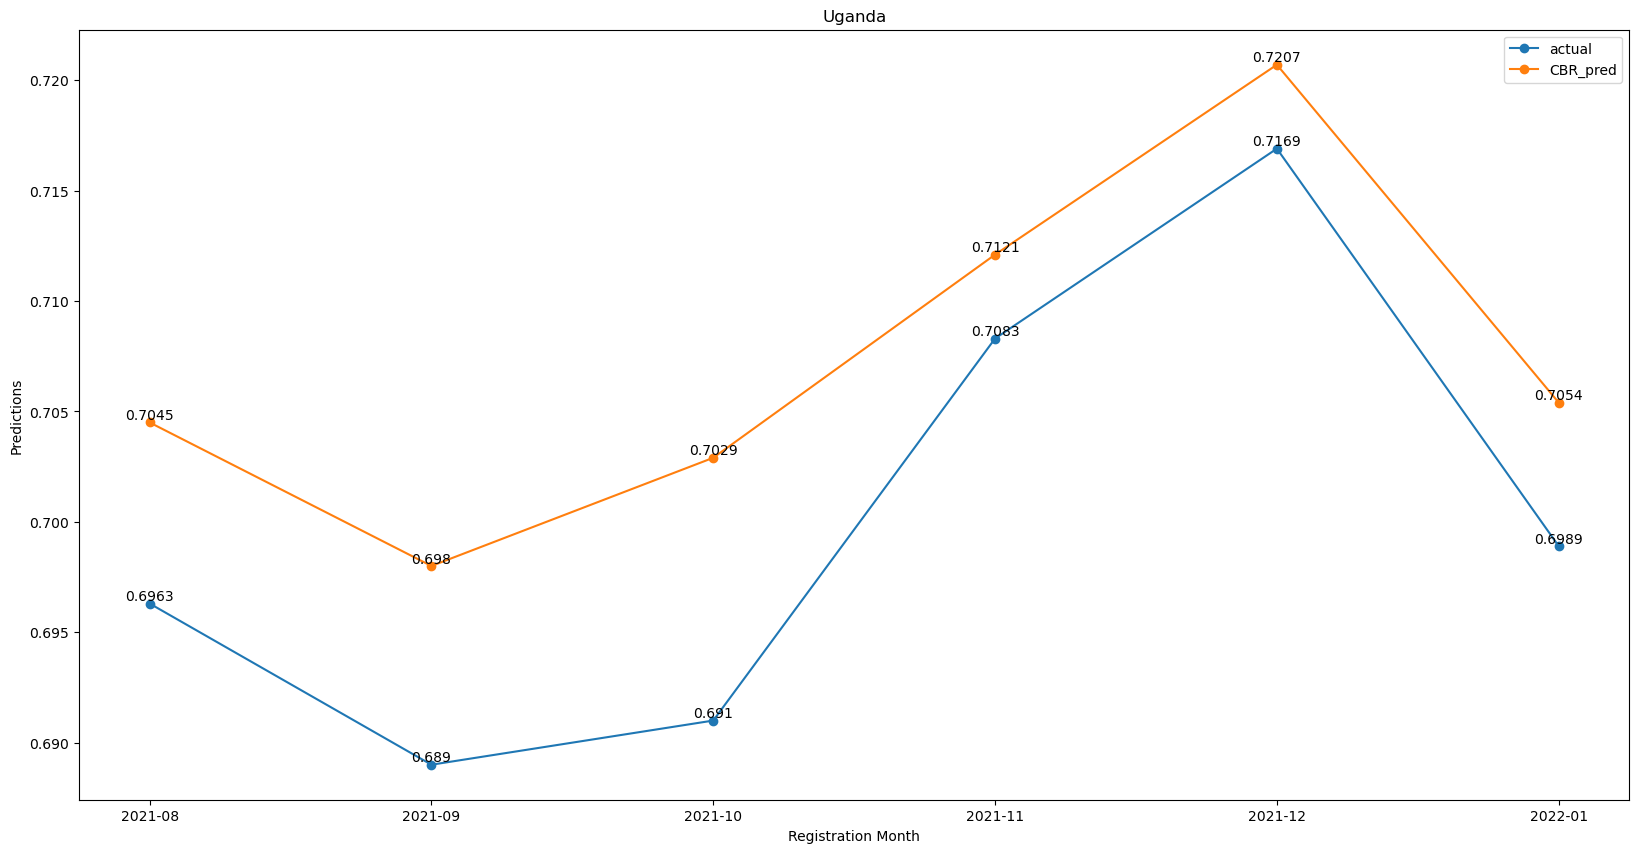

630
Avg error actual and pred: 0.0092


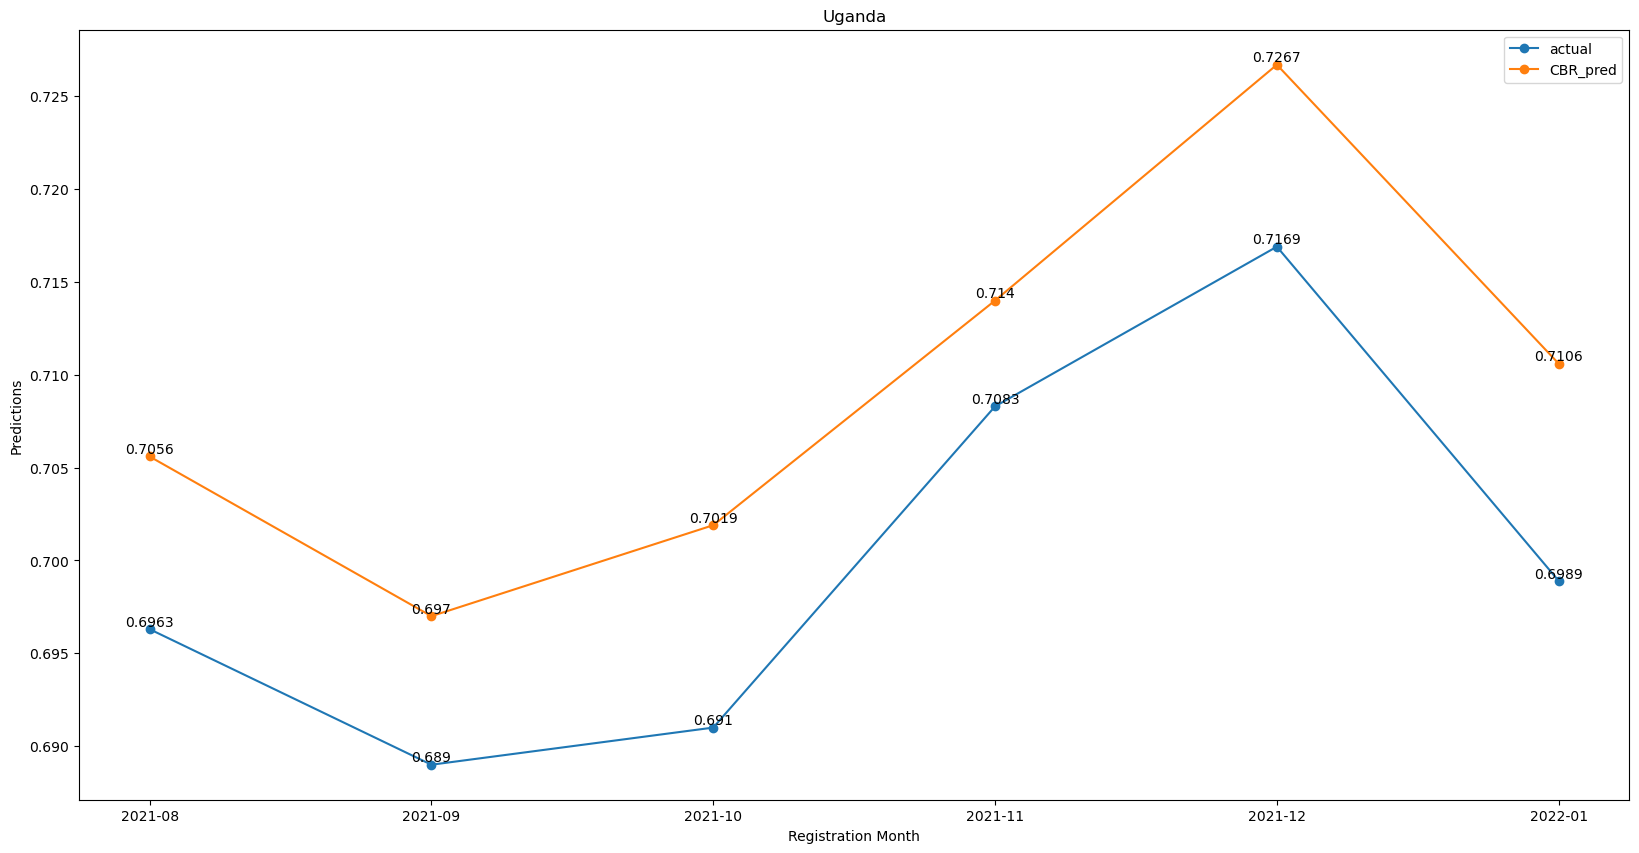

720
Avg error actual and pred: 0.0076


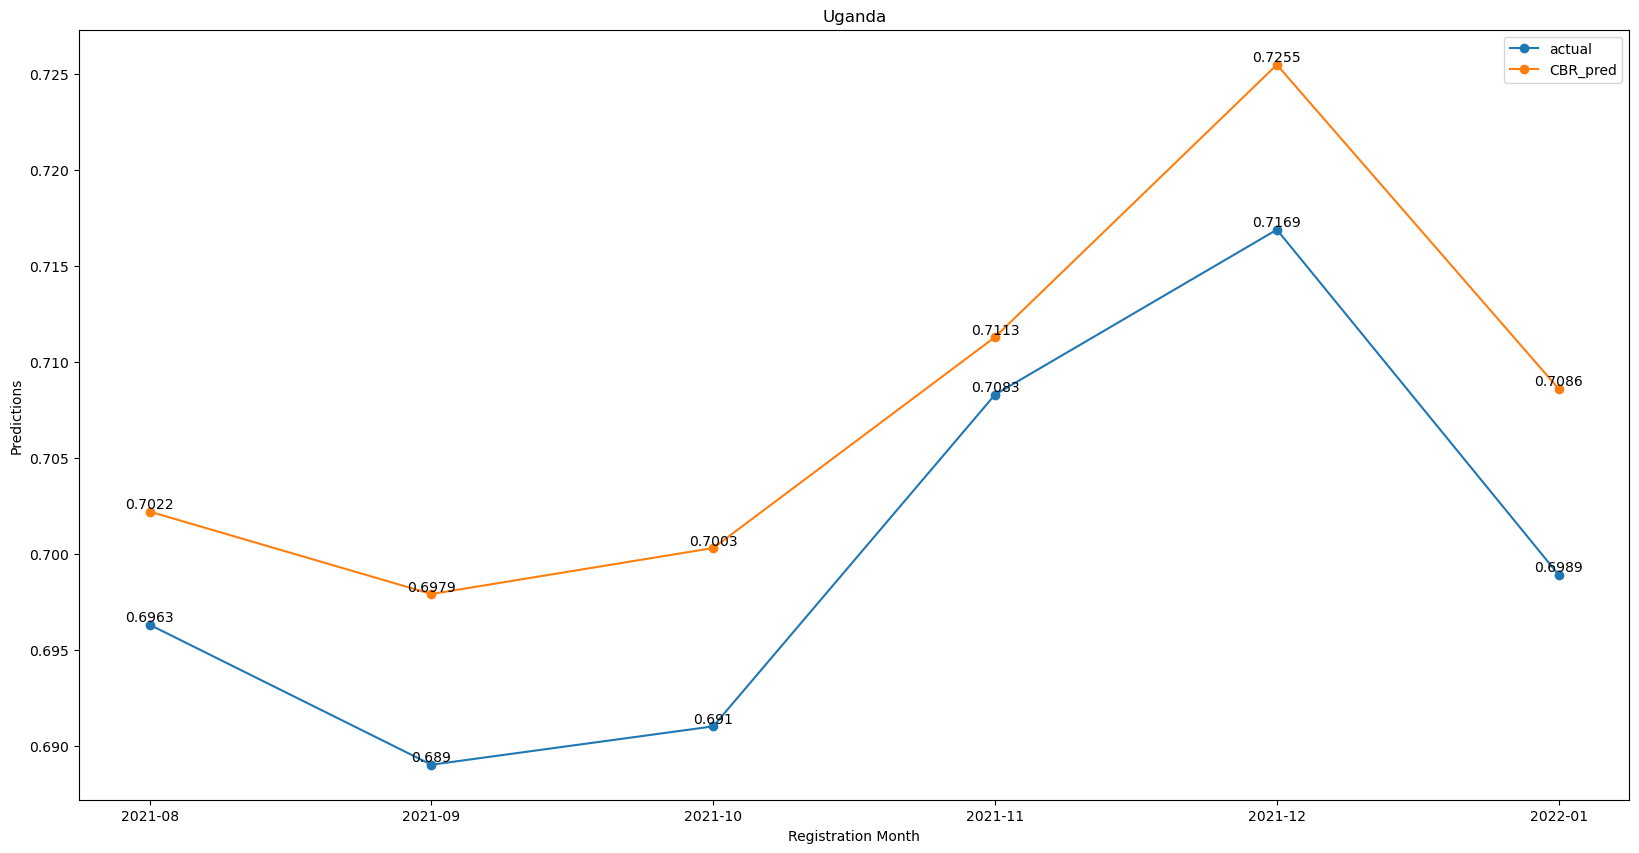

----------------------------------------------------------------------
Zambia
30
Avg error actual and pred: 0.0717


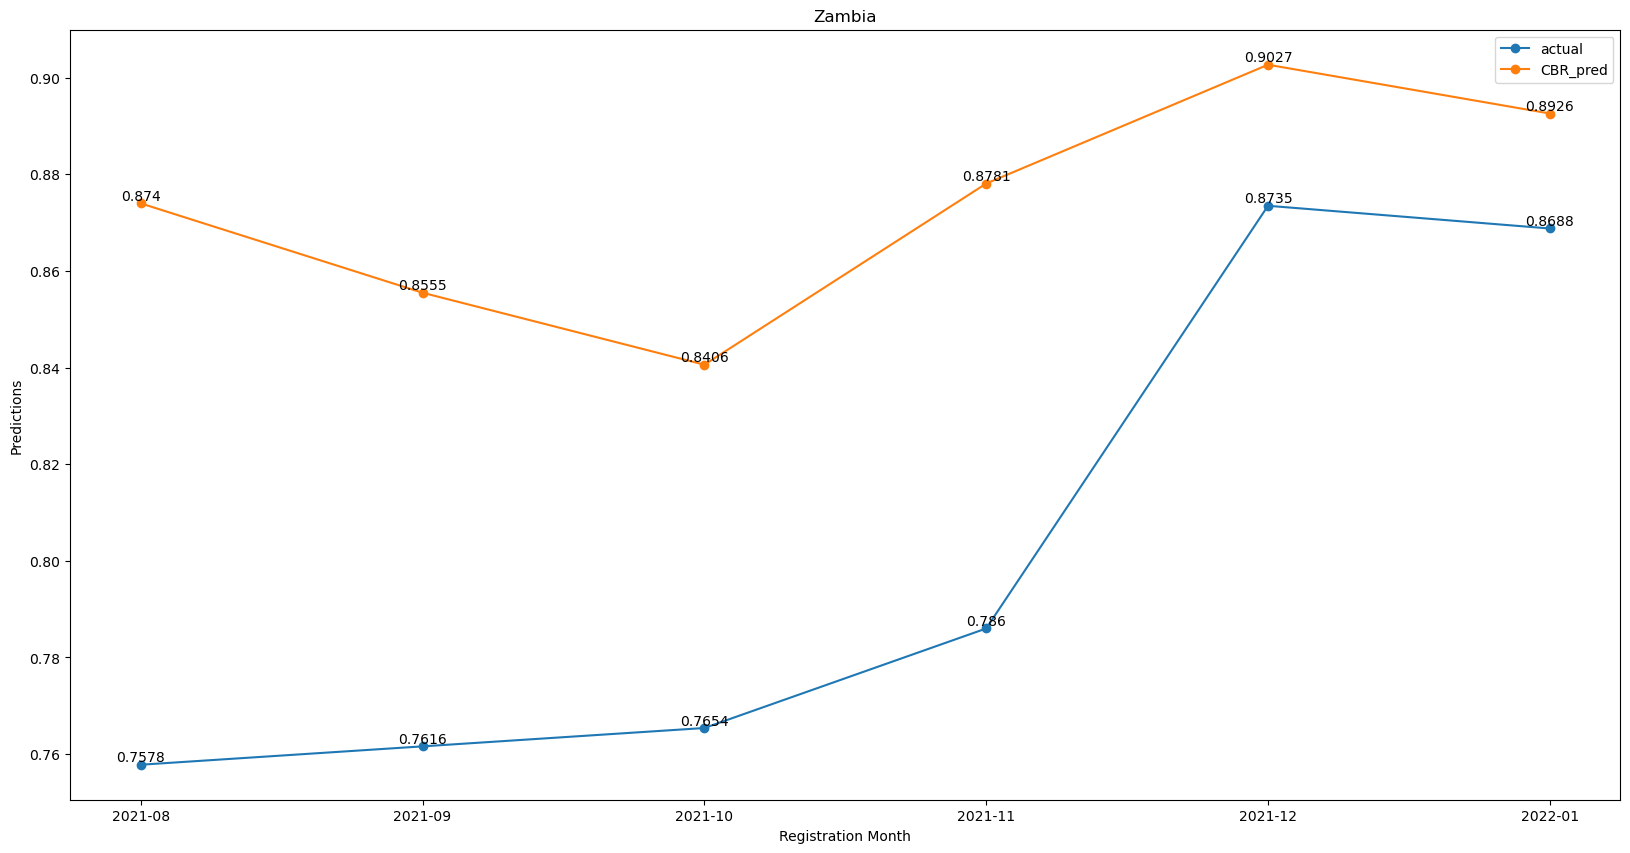

60
Avg error actual and pred: 0.045


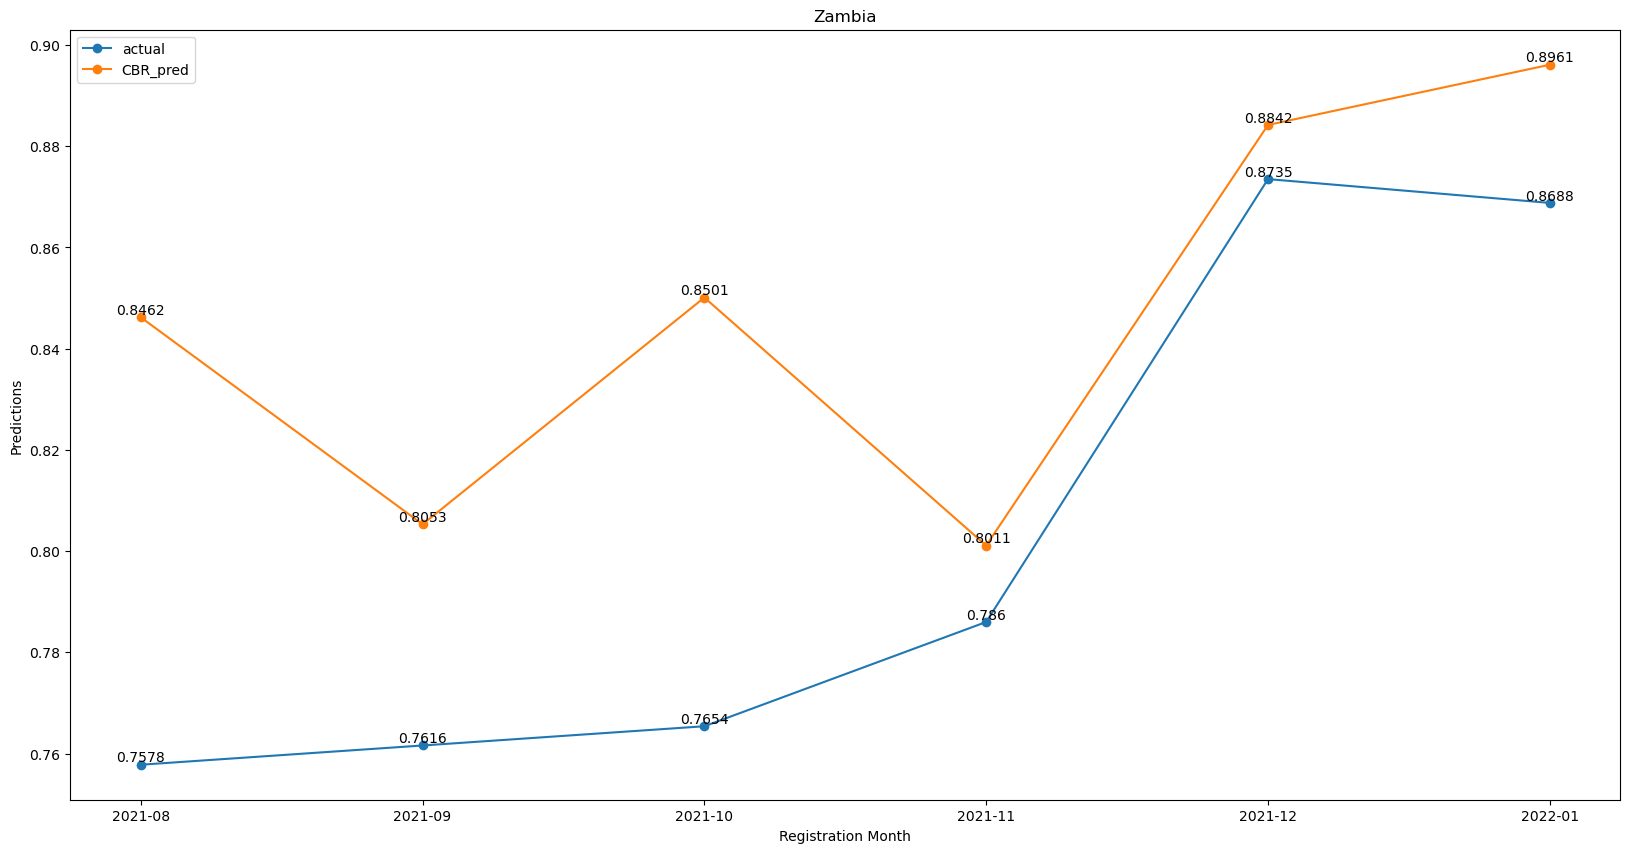

90
Avg error actual and pred: 0.048


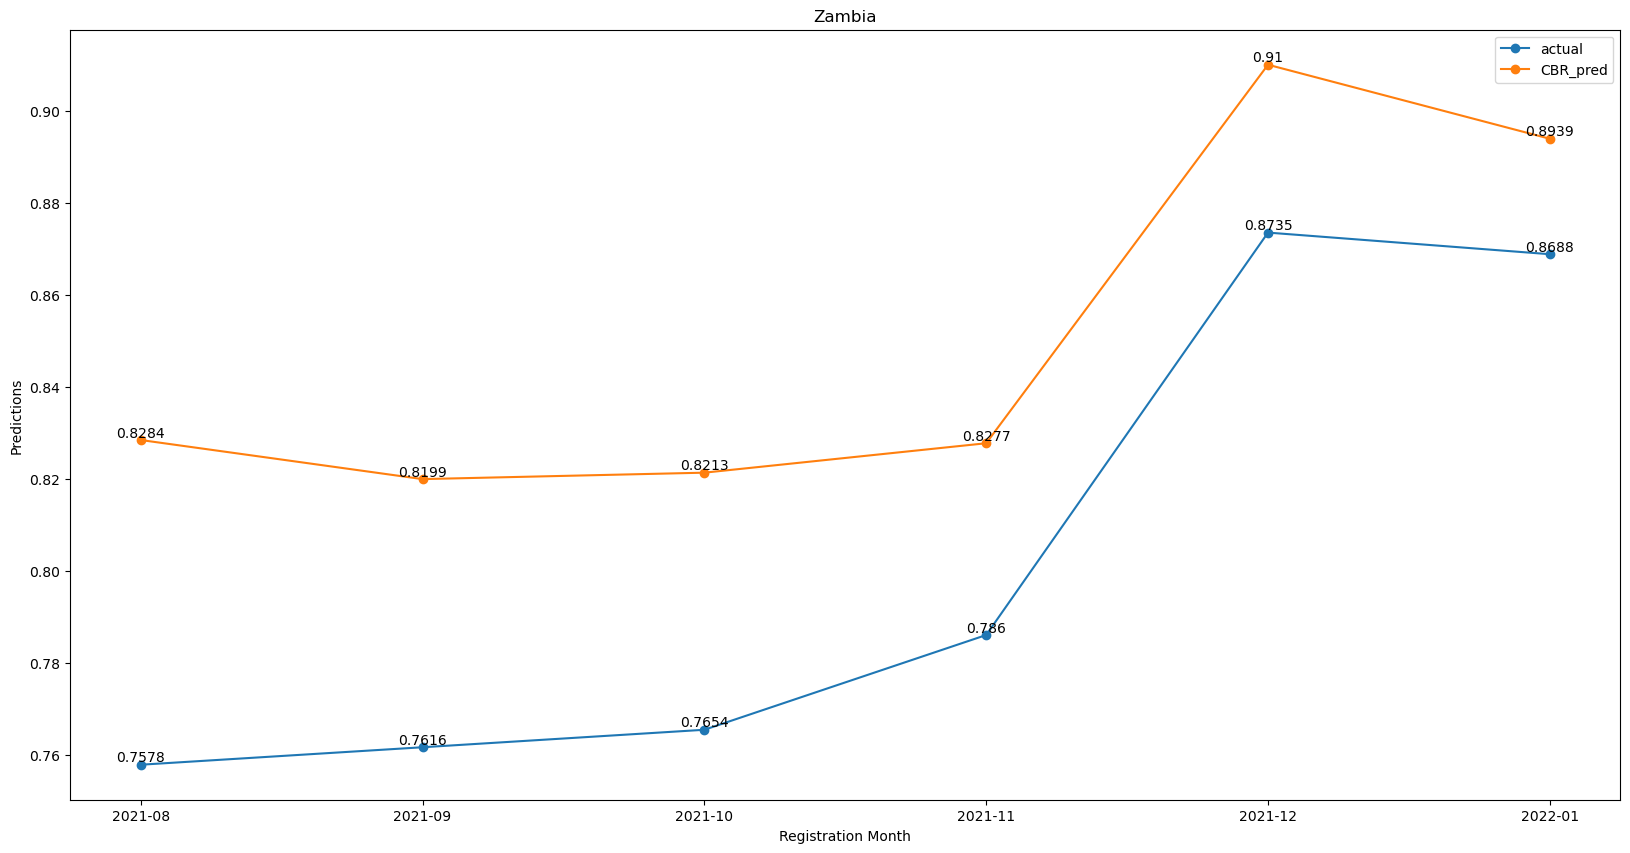

180
Avg error actual and pred: 0.0208


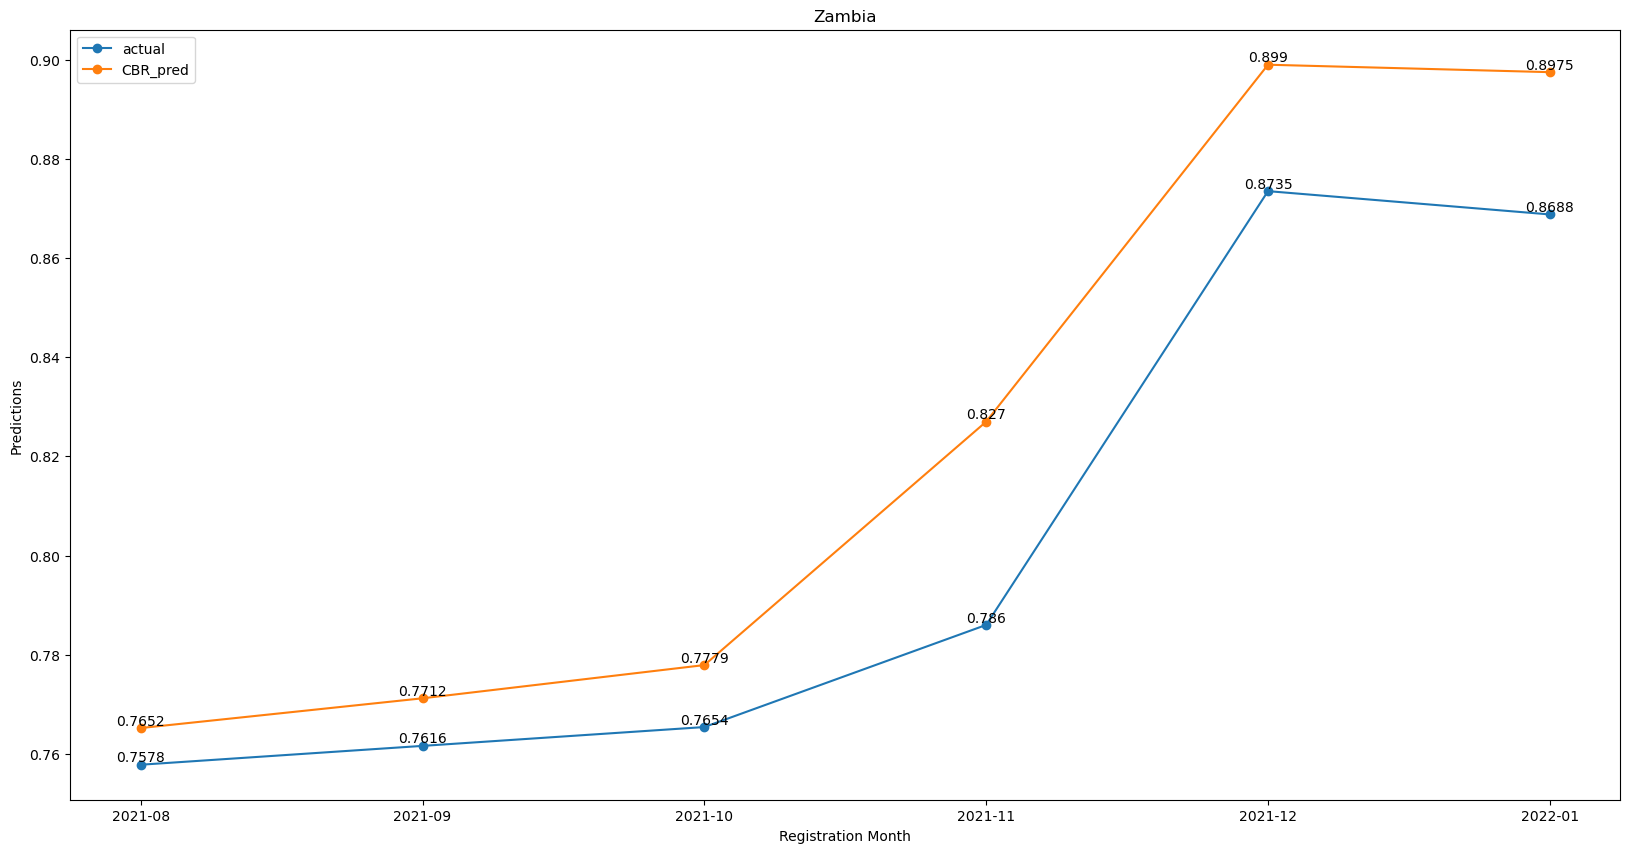

270
Avg error actual and pred: 0.0372


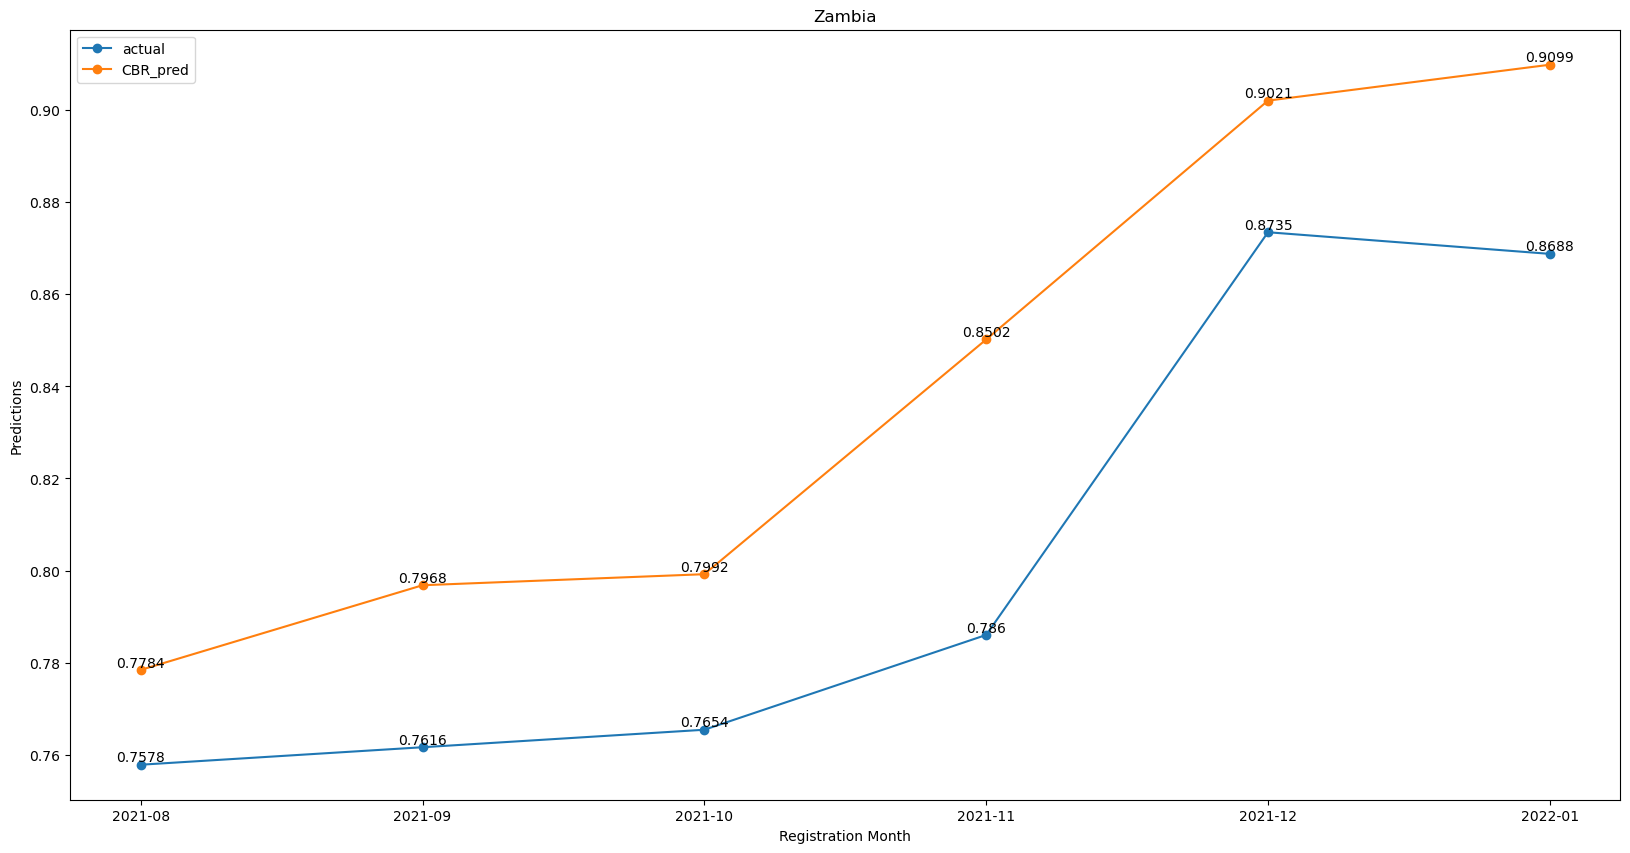

360
Avg error actual and pred: 0.0168


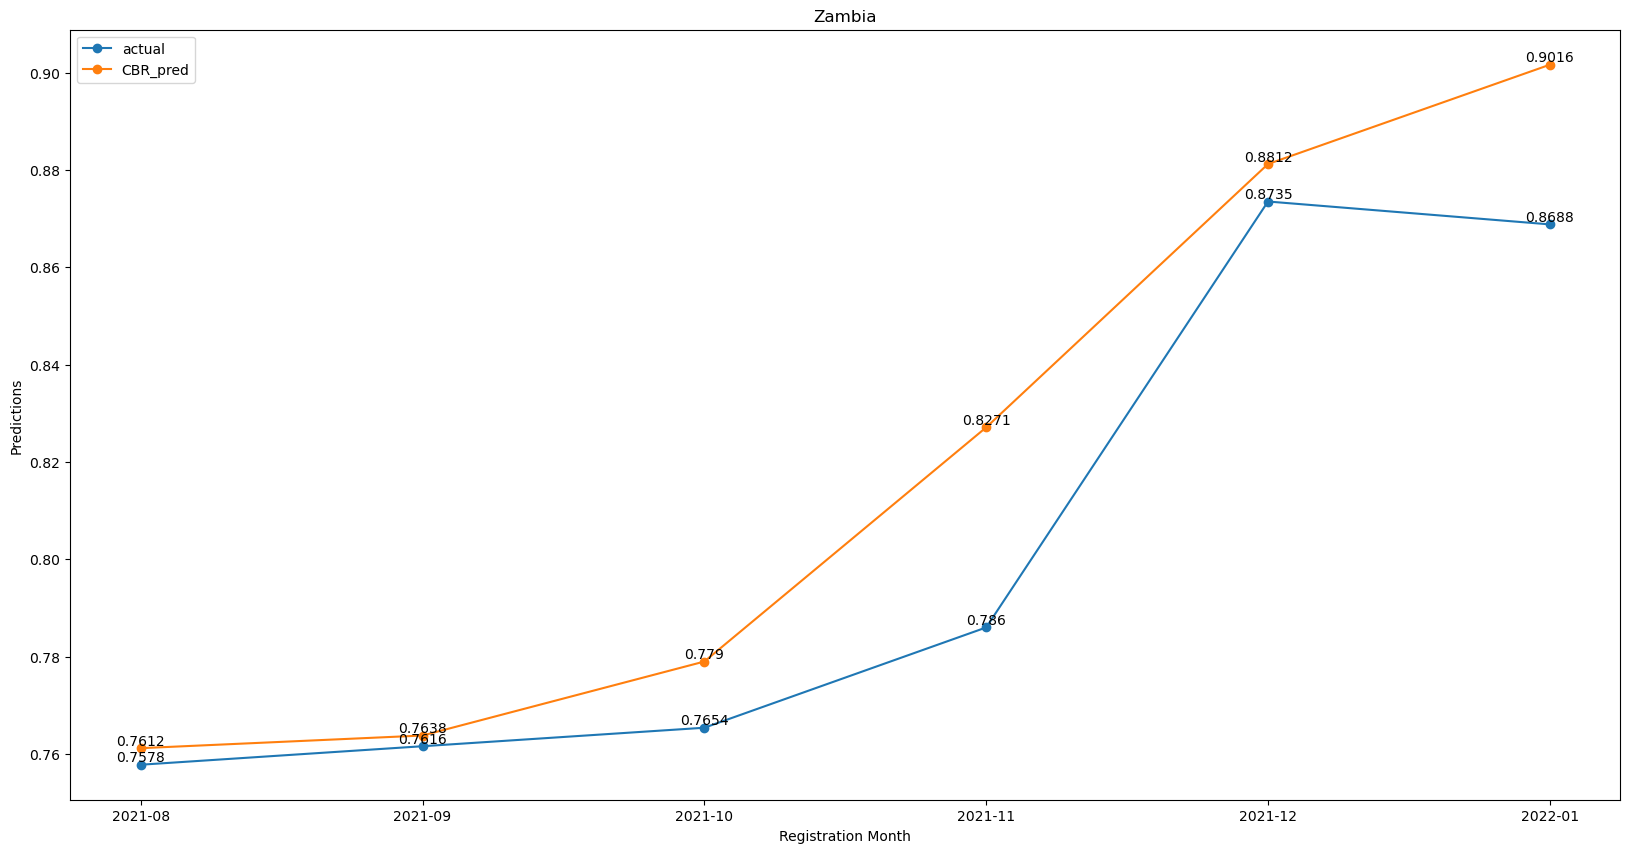

450
Avg error actual and pred: 0.011


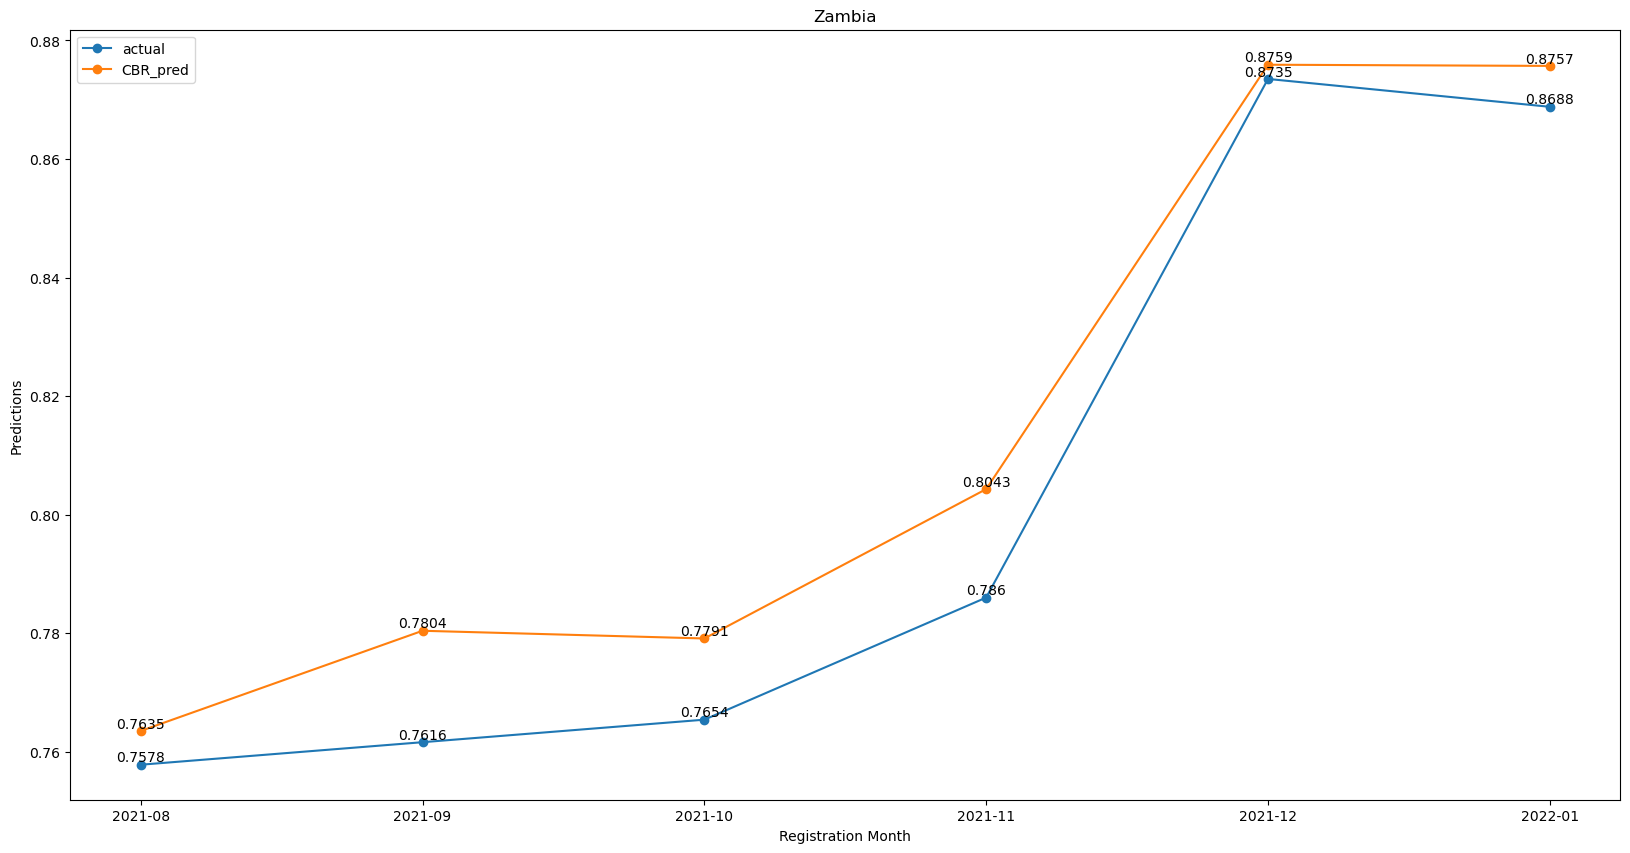

540
Avg error actual and pred: 0.0119


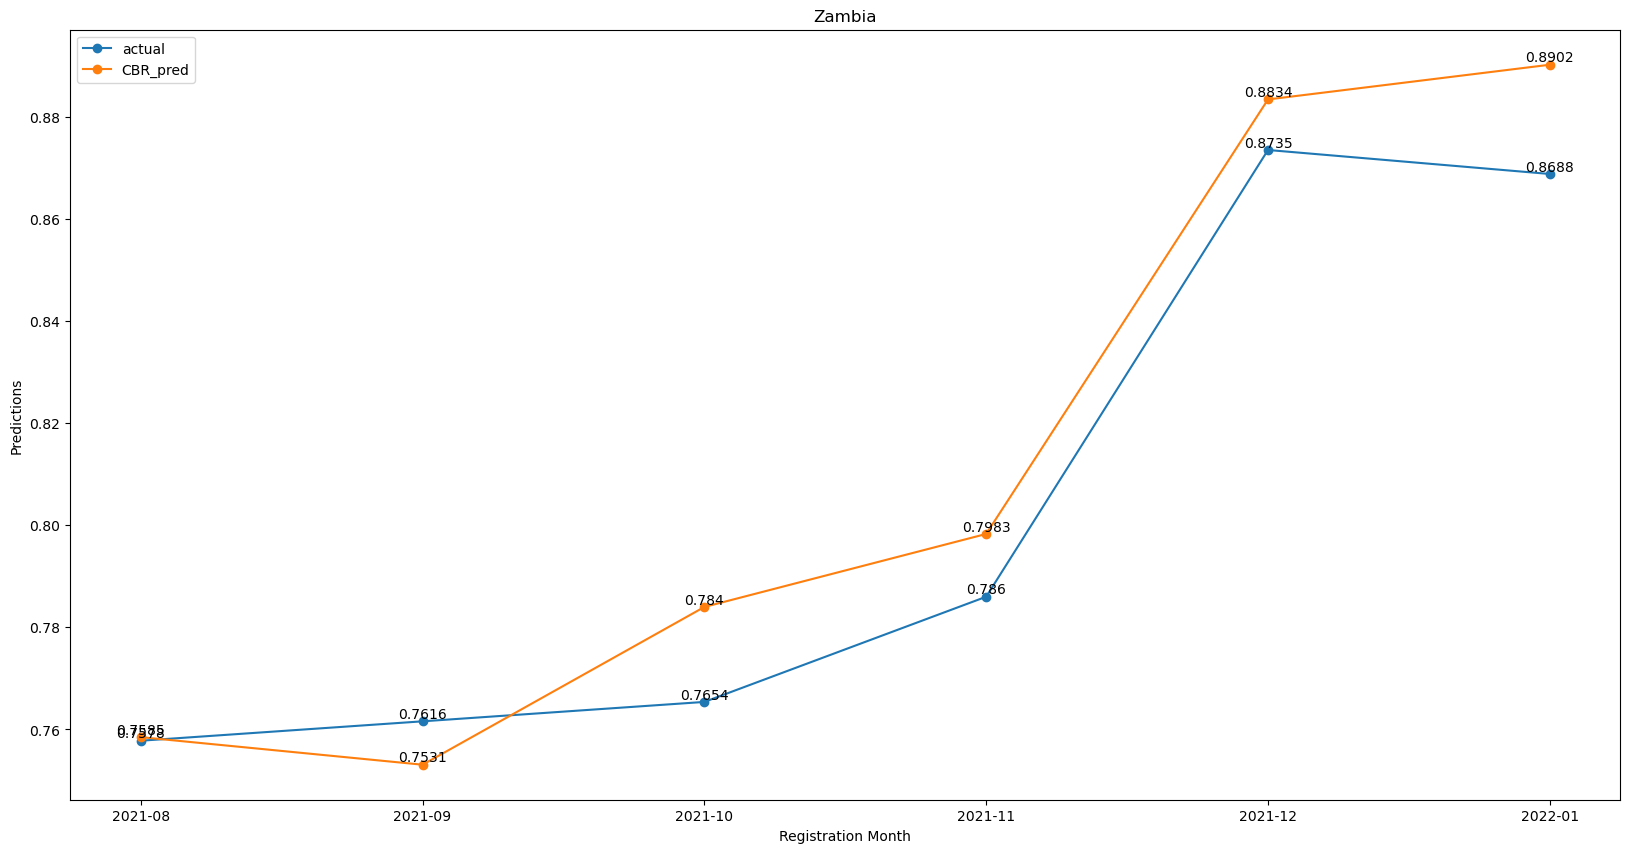

630
Avg error actual and pred: 0.0108


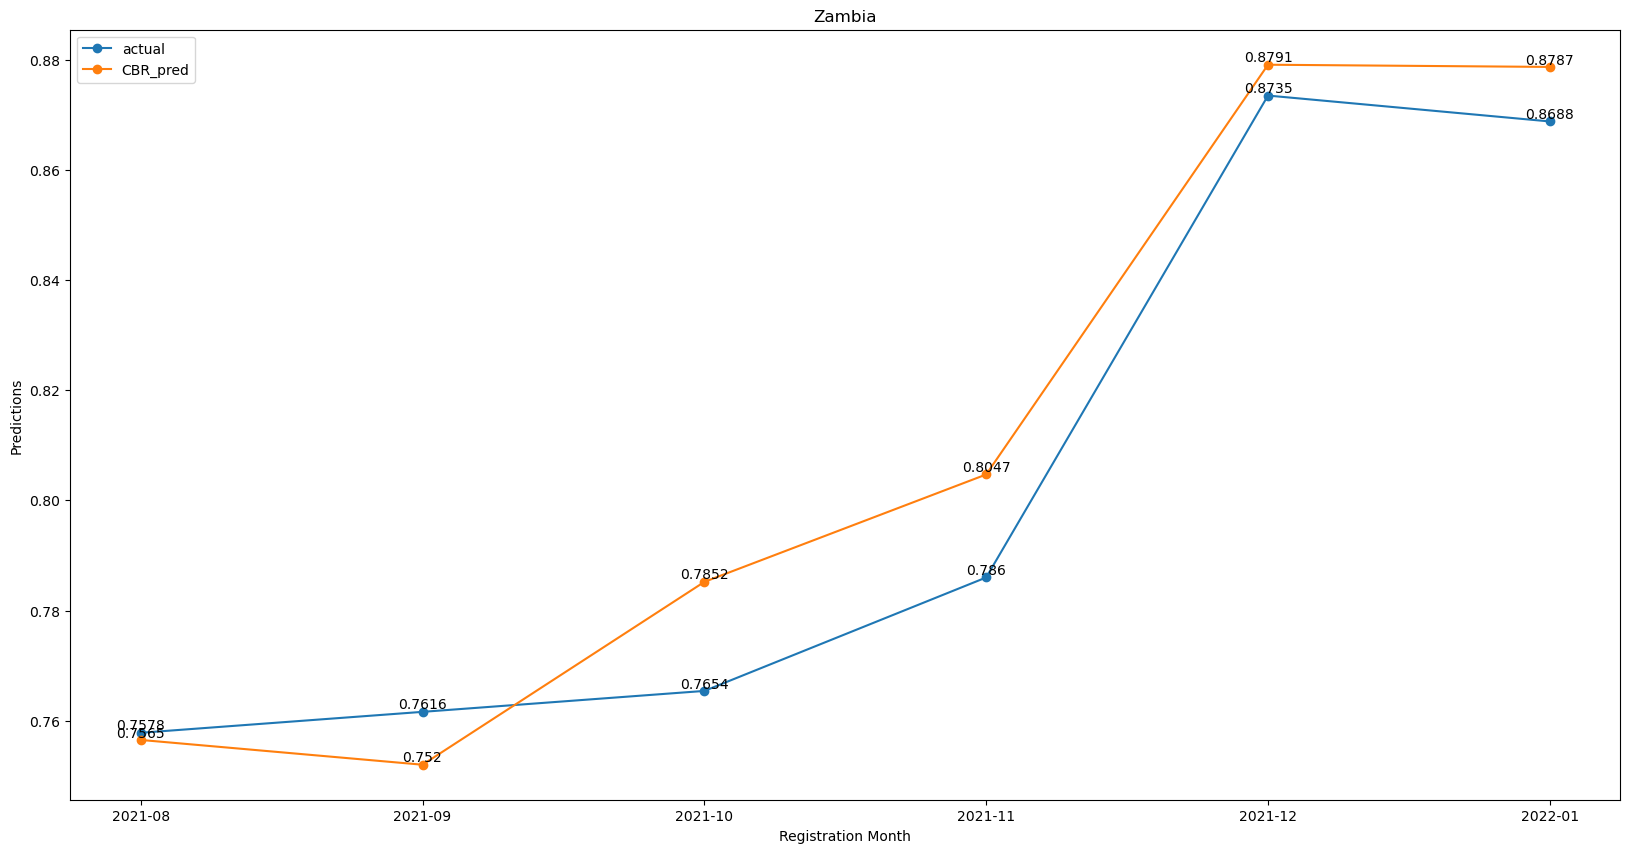

720
Avg error actual and pred: 0.005


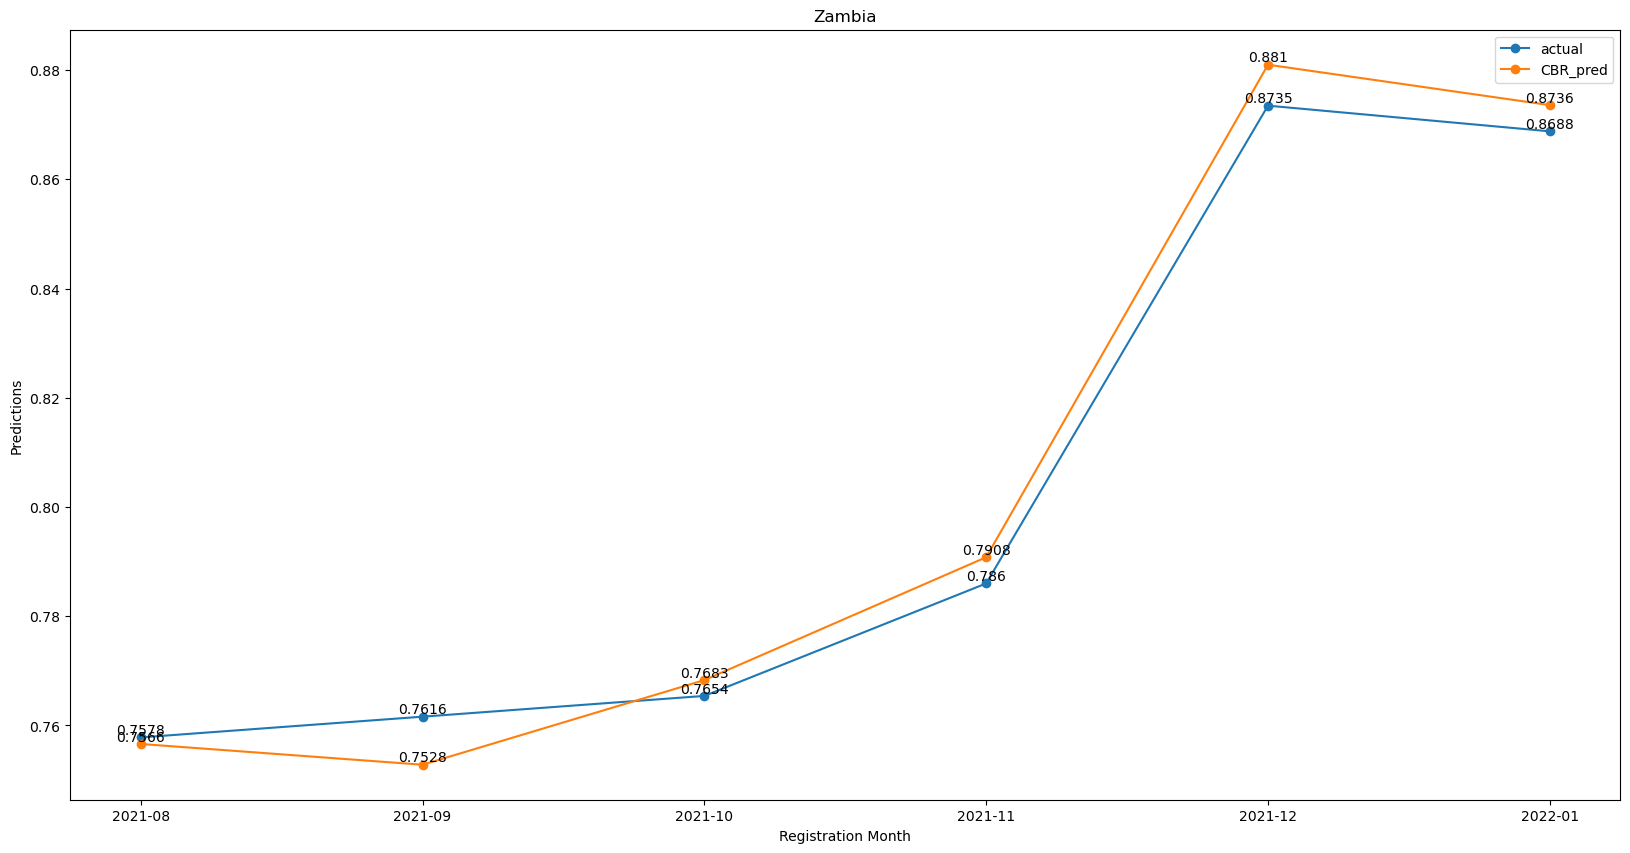

----------------------------------------------------------------------


In [23]:
for country in list_countries:

    print(country)
    
    for btl in [30, 60, 90, 180, 270, 360, 450, 540, 630, 720]:
        
        print(btl)

        df_comparison_country = df_comparison_country_wise[(df_comparison_country_wise['Country']==country) & (df_comparison_country_wise['Backtesting']==btl)].reset_index().drop(columns='index')
        print('Avg error actual and pred:',np.round(np.abs(df_comparison_country['actual']- df_comparison_country['CBR_pred']).mean(),4))

        plot_preds_actuals(df_comparison_country, 'Month',["actual","CBR_pred"],
                  'Registration Month','Predictions',country)

    print('----------------------------------------------------------------------')   